#Uniswap V2 + futures/lending hedge

In [149]:
import numpy as np
import scipy
import scipy.integrate as integrate
from scipy.special import erf

from scipy.optimize import fsolve

from matplotlib import pyplot as plt

In [150]:
class Portfolio_UniV2:
    def __init__(self, beta, l, t, mu, sigma, kappa, iota, r_a, r_b, r_cd, r_be, theta, D):
        """
        Инициализация поставщика ликвидности.

        """
        self.beta = beta
        self.l = l
        self.t = t
        self.mu = mu
        self.sigma = sigma
        self.kappa = kappa
        self.iota = iota
        self.r_a = r_a
        self.r_b = r_b
        self.r_cd = r_cd
        self.r_be = r_be
        self.theta = theta
        self.D_fh = D
        self.D_lh = D

        self.Time = 0 #Костыль

        self.price_history = np.array([])

        #Futures hedge
        self.portfolio_history = np.array([])
        self.MBP_history = np.array([])

        #Lending hedge
        self.lh_portfolio_history = np.array([])
        self.lh_MBP_history = np.array([])

        self.time_grid = np.array([])

        self.rebalance(beta, l, t, mu, sigma, kappa, iota, r_a, r_b, r_cd, r_be, theta)

    def rebalance(self, b, l, t, mu, sigma, kappa, iota, r_a, r_b, r_cd, r_be, theta):
        #Simulation
        n_paths = 10
        n_steps = 500

        if (self.price_history.size == 0):
            S_0 = 3000
        else:
            S_0 = self.price_history[-1]

        paths = self.gbm_path_generator(n_paths, n_steps, t, mu, sigma, S_0)
        self.price_history = np.concatenate((self.price_history, paths['S'][0]))

        #Optimal alpha searching
        MBP = max(self.optimal_MBP(b, t, mu, sigma, kappa, iota, r_a, r_b, l, self.D_fh), (1 - theta) / (1 + theta)) #MBP = margin balance percentage = alpha
        MBP_values = np.zeros(n_steps + 1)

        lh_MBP = max(self.lh_optimal_MBP(b, l, t, mu, sigma, r_cd, r_be, theta, self.D_lh), (1 - theta) / (1 + theta))
        lh_MBP_values = np.zeros(n_steps + 1)

        #Integrals calculation
        fees_int = np.zeros(n_steps + 1)
        futures_int = np.zeros(n_steps + 1)

        exp_arr = np.zeros(n_steps + 1)
        for i in range(0, n_steps + 1):
          exp_arr[i] = np.exp(-l * i / n_steps)

        for i in range(0, n_steps + 1):
          fees_int[i] = integrate.trapezoid(np.sqrt(paths['S'][0][:i]) * exp_arr[:i], dx = 1/n_steps)
          futures_int[i] = integrate.trapezoid(paths['S'][0][:i], dx = 1/n_steps) * ((kappa-iota)/(kappa + r_b - r_a) - 1)

        #Portfolio value
        portfolio = np.zeros(n_steps + 1)
        lh_portfolio = np.zeros(n_steps + 1)
        for i in range(0, n_steps + 1):
            AMM = self.D_fh*(1 - MBP)*np.sqrt(paths['S'][0][i]/S_0) + b*self.D_fh*(1 - MBP)/np.sqrt(S_0)*fees_int[i]
            lh_AMM = self.D_lh*(1 - lh_MBP)*np.sqrt(paths['S'][0][i]/S_0) + b*self.D_lh*(1 - lh_MBP)/np.sqrt(S_0)*fees_int[i]

            #Futures position
            if (MBP == 0):
              MB = 0
            else:
              MB = MBP*self.D_fh - self.D_fh*(1 - MBP)/(2*S_0)*(paths['S'][0][i] - S_0) + self.D_fh*(1 - MBP)/(2*S_0) * kappa*futures_int[i]

            #Lending position
            if (lh_MBP == 0):
                lending_position = 0
            else:
                lending_position = self.D_lh*(1 + lh_MBP)/2 *np.exp(r_cd * i / n_steps) - self.D_lh * (1 - lh_MBP)/(2*S_0) * paths['S'][0][i] * np.exp(r_be * i / n_steps)

            #portfolio[i] = D*(1 - alpha)*np.sqrt(paths['S'][0][i]/S_0) + b*D*(1 - alpha)/np.sqrt(S_0)*fees_int[i] + alpha*D - D*(1 - alpha)/(2*S_0)*(paths['S'][0][i] - S_0) + D*(1 - alpha)/(2*S_0) * kappa*futures_int[i]
            portfolio[i] = AMM + MB
            MBP_values[i] = MB / (AMM + MB)

            lh_portfolio[i] = lh_AMM + lending_position
            lh_MBP_values[i] = lending_position / (lh_AMM + lending_position)


        self.portfolio_history = np.concatenate((self.portfolio_history, portfolio))
        self.MBP_history = np.concatenate((self.MBP_history, MBP_values))

        self.lh_portfolio_history = np.concatenate((self.lh_portfolio_history, lh_portfolio))
        self.lh_MBP_history = np.concatenate((self.lh_MBP_history, lh_MBP_values))

        self.time_grid = np.concatenate((self.time_grid, np.array(paths['time']) + self.Time))
        self.Time += t

        self.D_fh = portfolio[-1]
        self.D_lh = lh_portfolio[-1]
        #Graphics
        #GBM = paths['S']
        #time_grid = paths['time']

    def show(self):
        plt.figure(figsize = (10, 6))
        plt.plot(self.time_grid, self.portfolio_history, self.time_grid, self.lh_portfolio_history)
        plt.grid()
        plt.xlabel('t (years)')
        plt.ylabel('Profit ($)')
        plt.legend (('AMM + Futures hedge', 'AMM + Lending hedge'))

        plt.figure(figsize = (10, 6))
        plt.plot(self.time_grid, self.price_history)
        plt.grid()
        plt.xlabel('t')
        plt.ylabel('Price')

        plt.figure(figsize = (10, 6))
        plt.plot(self.time_grid, self.MBP_history, self.time_grid, self.lh_MBP_history)
        plt.grid()
        plt.xlabel('t')
        plt.ylabel('Margin balance percentage')
        plt.legend (('CEX Margin balance percentage', 'Lending position percentage'))

    def gbm_path_generator(self, n_paths, n_steps, T, mu, sigma, S_0):

        # Create
        Z = np.random.normal(0.0, 1.0, [n_paths, n_steps])
        X = np.zeros([n_paths, n_steps + 1])
        time = np.zeros(n_steps + 1)

        X[:, 0] = np.log(S_0)
        dt = T / float(n_steps)

        for k in range(0, n_steps):
            X[:, k+1] = X[:, k] + (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, k]
            time[k+1] = time[k] + dt
        S = np.exp(X)
        paths = {'S': S, 'time': time}

        return paths

    #Функции для лендинга #lh = lending ledge
    def lh_optimal_MBP(self, b, l, t, u, sigma, r_cd, r_be, theta, D):
        MBP = 0
        roots = fsolve(self.lh_mean_first_derivative, 0, args = (b, l, t, u, sigma, r_cd, r_be, theta, D))
        if (roots[0] < 0):
            MBP = 0
        else:
            MBP = roots[0]

        print(MBP)
        return MBP

    def lh_mean_first_derivative(self, x, b, l, t, u, s, r_cd, r_be, theta, D):
        derivative = (D * np.exp(t * (u + r_be)) * (-(((theta * (x + 1)) / (1 - x))**(2 * (u / s**2 + (r_be - r_cd) / s**2 + 1 / 2)) * (1 - erf((np.log((theta * (x + 1)) / (1 - x)) + t * (u + s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (x + 1)) / (1 - x)) - t * (u + s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1)) / 2 - (D * np.exp(t * (u + r_be)) * (1 - x) * (-((u / s**2 + (r_be - r_cd) / s**2 + 1 / 2) * (1 - x) * ((theta * (x + 1)) / (1 - x))**(2 * (u / s**2 + (r_be - r_cd) / s**2 + 1 / 2)) * ((theta * (x + 1)) / (1 - x)**2 + theta / (1 - x)) * (1 - erf((np.log((theta * (x + 1)) / (1 - x)) + t * (u + s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / (theta * (x + 1)) + ((1 - x) * ((theta * (x + 1)) / (1 - x))**(2 * (u / s**2 + (r_be - r_cd) / s**2 + 1 / 2)) * ((theta * (x + 1)) / (1 - x)**2 + theta / (1 - x)) * np.exp(-(np.log((theta * (x + 1)) / (1 - x)) + t * (u + s**2 / 2 - r_cd + r_be))**2 / (2 * s**2 * t))) / (np.sqrt(2) * np.sqrt(np.pi) * theta * s * np.sqrt(t) * (x + 1)) + ((1 - x) * ((theta * (x + 1)) / (1 - x)**2 + theta / (1 - x)) * np.exp(-(np.log((theta * (x + 1)) / (1 - x)) - t * (u + s**2 / 2 - r_cd + r_be))**2 / (2 * s**2 * t))) / (np.sqrt(2) * np.sqrt(np.pi) * theta * s * np.sqrt(t) * (x + 1)))) / 2 + (D * np.exp(r_cd * t) * (-(((theta * (x + 1)) / (1 - x))**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (x + 1)) / (1 - x)) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (x + 1)) / (1 - x)) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1)) / 2 + (D * np.exp(r_cd * t) * (x + 1) * (-((u / s**2 + (r_be - r_cd) / s**2 - 1 / 2) * (1 - x) * ((theta * (x + 1)) / (1 - x))**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * ((theta * (x + 1)) / (1 - x)**2 + theta / (1 - x)) * (1 - erf((np.log((theta * (x + 1)) / (1 - x)) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / (theta * (x + 1)) + ((1 - x) * ((theta * (x + 1)) / (1 - x))**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * ((theta * (x + 1)) / (1 - x)**2 + theta / (1 - x)) * np.exp(-(np.log((theta * (x + 1)) / (1 - x)) + t * (u - s**2 / 2 - r_cd + r_be))**2 / (2 * s**2 * t))) / (np.sqrt(2) * np.sqrt(np.pi) * theta * s * np.sqrt(t) * (x + 1)) + ((1 - x) * ((theta * (x + 1)) / (1 - x)**2 + theta / (1 - x)) * np.exp(-(np.log((theta * (x + 1)) / (1 - x)) - t * (u - s**2 / 2 - r_cd + r_be))**2 / (2 * s**2 * t))) / (np.sqrt(2) * np.sqrt(np.pi) * theta * s * np.sqrt(t) * (x + 1)))) / 2 - (D * b * (np.exp(t * (-l + u / 2 - s**2 / 8)) - 1)) / (-l + u / 2 - s**2 / 8) - D * np.exp(t * (u / 2 - s**2 / 8))
        return derivative

    def lh_portfolio_mean(self, x, b, l, t, u, s, r_cd, r_be, theta, D):
        mean = -(D * np.exp(t * (u + r_be)) * (1 - x) * (-(((theta * (x + 1)) / (1 - x))**(2 * (u / s**2 + (r_be - r_cd) / s**2 + 1 / 2)) * (1 - erf((np.log((theta * (x + 1)) / (1 - x)) + t * (u + s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (x + 1)) / (1 - x)) - t * (u + s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1)) / 2 + (D * np.exp(r_cd * t) * (x + 1) * (-(((theta * (x + 1)) / (1 - x))**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (x + 1)) / (1 - x)) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (x + 1)) / (1 - x)) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1)) / 2 + (D * b * (np.exp(t * (-l + u / 2 - s**2 / 8)) - 1) * (1 - x)) / (-l + u / 2 - s**2 / 8) + D * np.exp(t * (u / 2 - s**2 / 8)) * (1 - x)
        return mean

    def lh_liquidation_probability(self, x, b, l, t, u, s, r_cd, r_be, theta, D):
        probability = (((theta * (x + 1)) / (1 - x))**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (x + 1)) / (1 - x)) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 + (1 - erf((np.log((theta * (x + 1)) / (1 - x)) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2
        return probability

    #Функции для фьючерсов #fh = futures hedge
    def optimal_MBP(self, b, t, u, sigma, kappa, iota, r_a, r_b, l, D):
        MBP = 0
        roots = fsolve(self.mean_first_derivative, 0, args = (b, t, u, sigma, kappa, iota, r_a, r_b, l, D))
        if (roots[0] < 0):
            MBP = 0
        else:
            MBP = roots[0]

        print(MBP)
        return MBP

    def mean_first_derivative(self, x, b, t, u, s, k, i, n, r, v, D):
        derivative = (D * (-(((x + 1) / (1 - x))**((2 * u) / s**2 - 1) * (1 - erf(np.log((x + 1) / (1 - x)) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log((x + 1) / (1 - x)) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1)) / 2 + (D * (x + 1) * (-(((2 * u) / s**2 - 1) * (1 - x) * ((x + 1) / (1 - x))**((2 * u) / s**2 - 1) * ((x + 1) / (1 - x)**2 + 1 / (1 - x)) * (1 - erf(np.log((x + 1) / (1 - x)) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / (2 * (x + 1)) + ((1 - x) * ((x + 1) / (1 - x))**((2 * u) / s**2 - 1) * ((x + 1) / (1 - x)**2 + 1 / (1 - x)) * np.exp(-(np.log((x + 1) / (1 - x)) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))**2)) / (np.sqrt(2) * np.sqrt(np.pi) * s * np.sqrt(t) * (x + 1)) + ((1 - x) * ((x + 1) / (1 - x)**2 + 1 / (1 - x)) * np.exp(-(np.log((x + 1) / (1 - x)) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))**2)) / (np.sqrt(2) * np.sqrt(np.pi) * s * np.sqrt(t) * (x + 1)))) / 2 - (D * ((k * (-r + n - i)) / (k - i) - 1) * np.exp(t * u) * (1 - x) * ((2 * (u / s**2 + 1 / 2) * (1 - x) * ((x + 1) / (1 - x))**(2 * (u / s**2 + 1 / 2)) * ((x + 1) / (1 - x)**2 + 1 / (1 - x)) * (1 - erf((np.log((x + 1) / (1 - x)) + s**2 * t * (u / s**2 + 1 / 2)) / (np.sqrt(2) * s * np.sqrt(t))))) / (x + 1) - (np.sqrt(2) * (1 - x) * ((x + 1) / (1 - x))**(2 * (u / s**2 + 1 / 2)) * ((x + 1) / (1 - x)**2 + 1 / (1 - x)) * np.exp(-(np.log((x + 1) / (1 - x)) + s**2 * t * (u / s**2 + 1 / 2))**2 / (2 * s**2 * t))) / (np.sqrt(np.pi) * s * np.sqrt(t) * (x + 1)) - (np.sqrt(2) * (1 - x) * ((x + 1) / (1 - x)**2 + 1 / (1 - x)) * np.exp(-(np.log((x + 1) / (1 - x)) - s**2 * t * (u / s**2 + 1 / 2))**2 / (2 * s**2 * t))) / (np.sqrt(np.pi) * s * np.sqrt(t) * (x + 1)))) / 4 - (D * ((k * (-r + n - i)) / (k - i) - 1) * (np.exp(t * u) - (np.exp(t * u) * (((x + 1) / (1 - x))**(2 * (u / s**2 + 1 / 2)) * (1 - erf((np.log((x + 1) / (1 - x)) + s**2 * t * (u / s**2 + 1 / 2)) / (np.sqrt(2) * s * np.sqrt(t)))) - erf((np.log((x + 1) / (1 - x)) - s**2 * t * (u / s**2 + 1 / 2)) / (np.sqrt(2) * s * np.sqrt(t))) + 1)) / 2)) / 2 - (D * b * (np.exp(t * (-v + u / 2 - s**2 / 8)) - 1)) / (-v + u / 2 - s**2 / 8) - D * np.exp(t * (u / 2 - s**2 / 8))
        return derivative

    def portfolio_mean(self, x, b, t, u, s, k, i, n, r, v, D):
        mean = (D*(1+x)*(-(((x+1)/(1-x))**((2*u)/s**2-1)*(1-erf(np.log((x+1)/(1-x))/(np.sqrt(2)*s*np.sqrt(t))+(np.sqrt(t)*(u/s-s/2))/np.sqrt(2))))/2-(1-erf(np.log((x+1)/(1-x))/(np.sqrt(2)*s*np.sqrt(t))-(np.sqrt(t)*(u/s-s/2))/np.sqrt(2)))/2+1))/2+(k/(k-i)*(n-r-i)-1)*(D*(1-x)*(np.exp(t*u)-(np.exp(t*u)*(((x+1)/(1-x))**(2*(u/s**2+1/2))*(1-erf((np.log((x+1)/(1-x))+s**2*t*(u/s**2+1/2))/(np.sqrt(2)*s*np.sqrt(t))))-erf((np.log((x+1)/(1-x))-s**2*t*(u/s**2+1/2))/(np.sqrt(2)*s*np.sqrt(t)))+1))/2))/2+(D*b*(np.exp(t*(-v+u/2-s**2/8))-1)*(1-x))/(-v+u/2-s**2/8)+D*np.exp(t*(u/2-s**2/8))*(1-x)
        return mean

    def liquidation_probability(self, x, b, t, u, s, k, i, n, r, v, D):
        probability = (((x + 1) / (1 - x))**((2 * u) / s**2 - 1) * (1 - erf(np.log((x + 1) / (1 - x)) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 + (1 - erf(np.log((x + 1) / (1 - x)) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2
        return probability

    def APY_MBP_dependency(self, b, t, u, sigma, kappa, iota, r_a, r_b, l, D):
        n_points = 1000
        APY = np.zeros(n_points)
        MBP = np.linspace(0.0, 1.0, n_points)

        for i in range (0, n_points):
          APY[i] = self.portfolio_mean(MBP[i], t, u, sigma, kappa, iota, r_a, r_b, l, D)

        plt.figure(figsize = (10, 6))
        plt.plot(MBP, APY)
        plt.grid()
        plt.xlabel('MBP')
        plt.ylabel('APY')

    def liquidation_probability_dependency(self, b, t, u, s, k, i, n, r, v, D):
        n_points = 1000
        liq_probs = np.zeros(n_points)
        MBP = np.linspace(0.0, 1.0, n_points)

        for i in range (0, n_points):
          liq_probs[i] = self.liquidation_probability(MBP[i], b, t, u, s, k, i, n, r, v, D)

        plt.figure(figsize = (10, 6))
        plt.plot(MBP, liq_probs)
        plt.grid()
        plt.xlabel('Alpha')
        plt.ylabel('Liquidation probability')


In [151]:
#Parameters

params = {
    'b': 0.3,
    'l': 0.05,
    't': 1,
    'u': -0.6,
    's': 0.5,
    'kappa': 0.05,
    'iota': 0.01,
    'r_a': 0.05,
    'r_b': 0.0174,
    'r_cd': 0.03,
    'r_be': 0.05,
    'theta': 0.9,
    'D': 1
    }

0.20989106693346515
0.29202322945888054


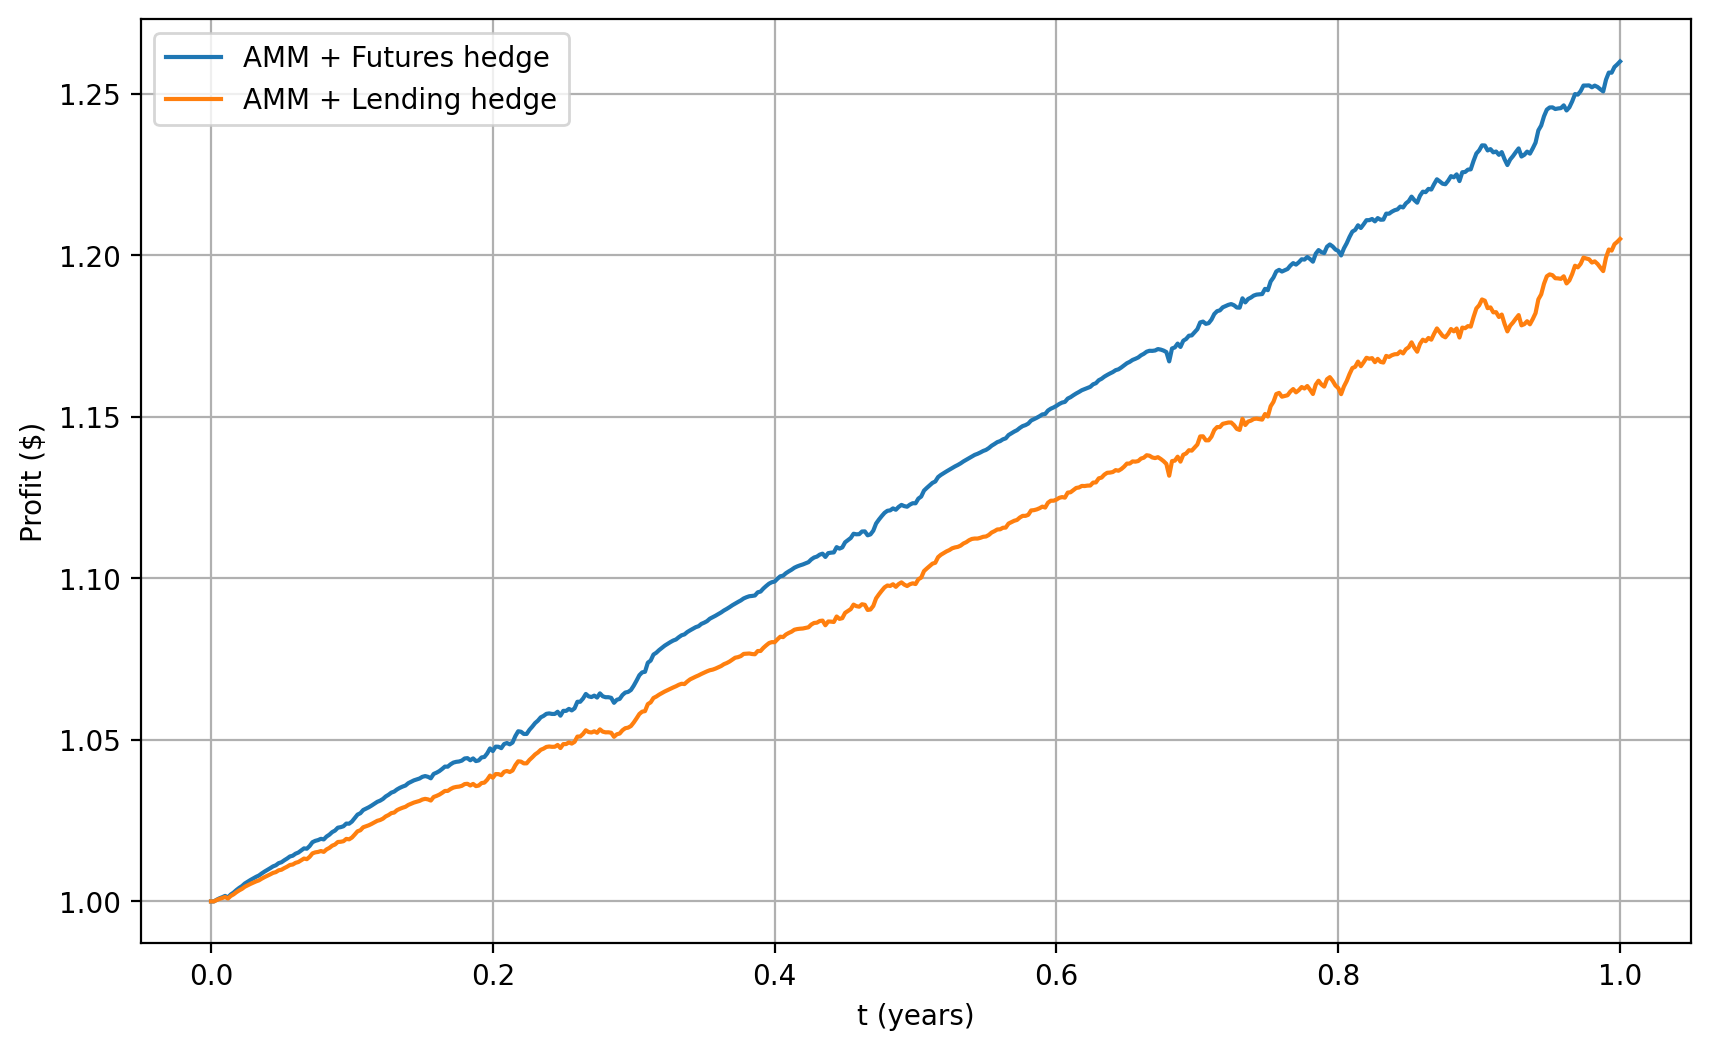

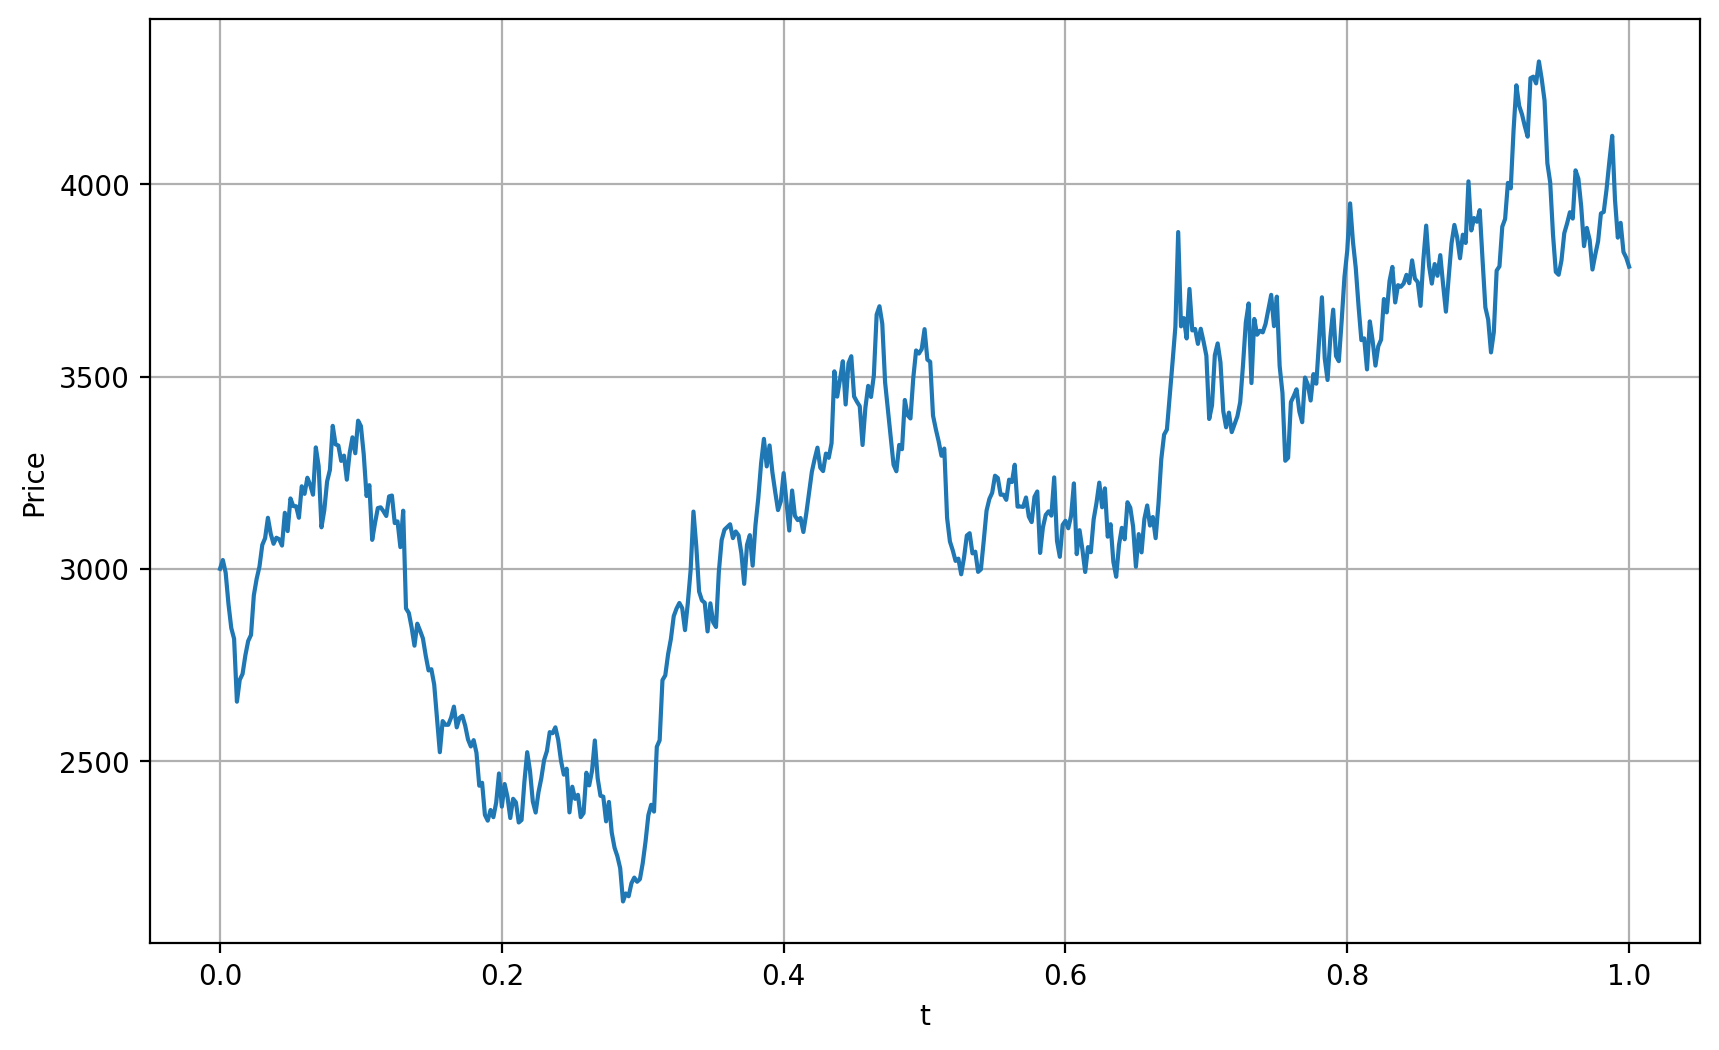

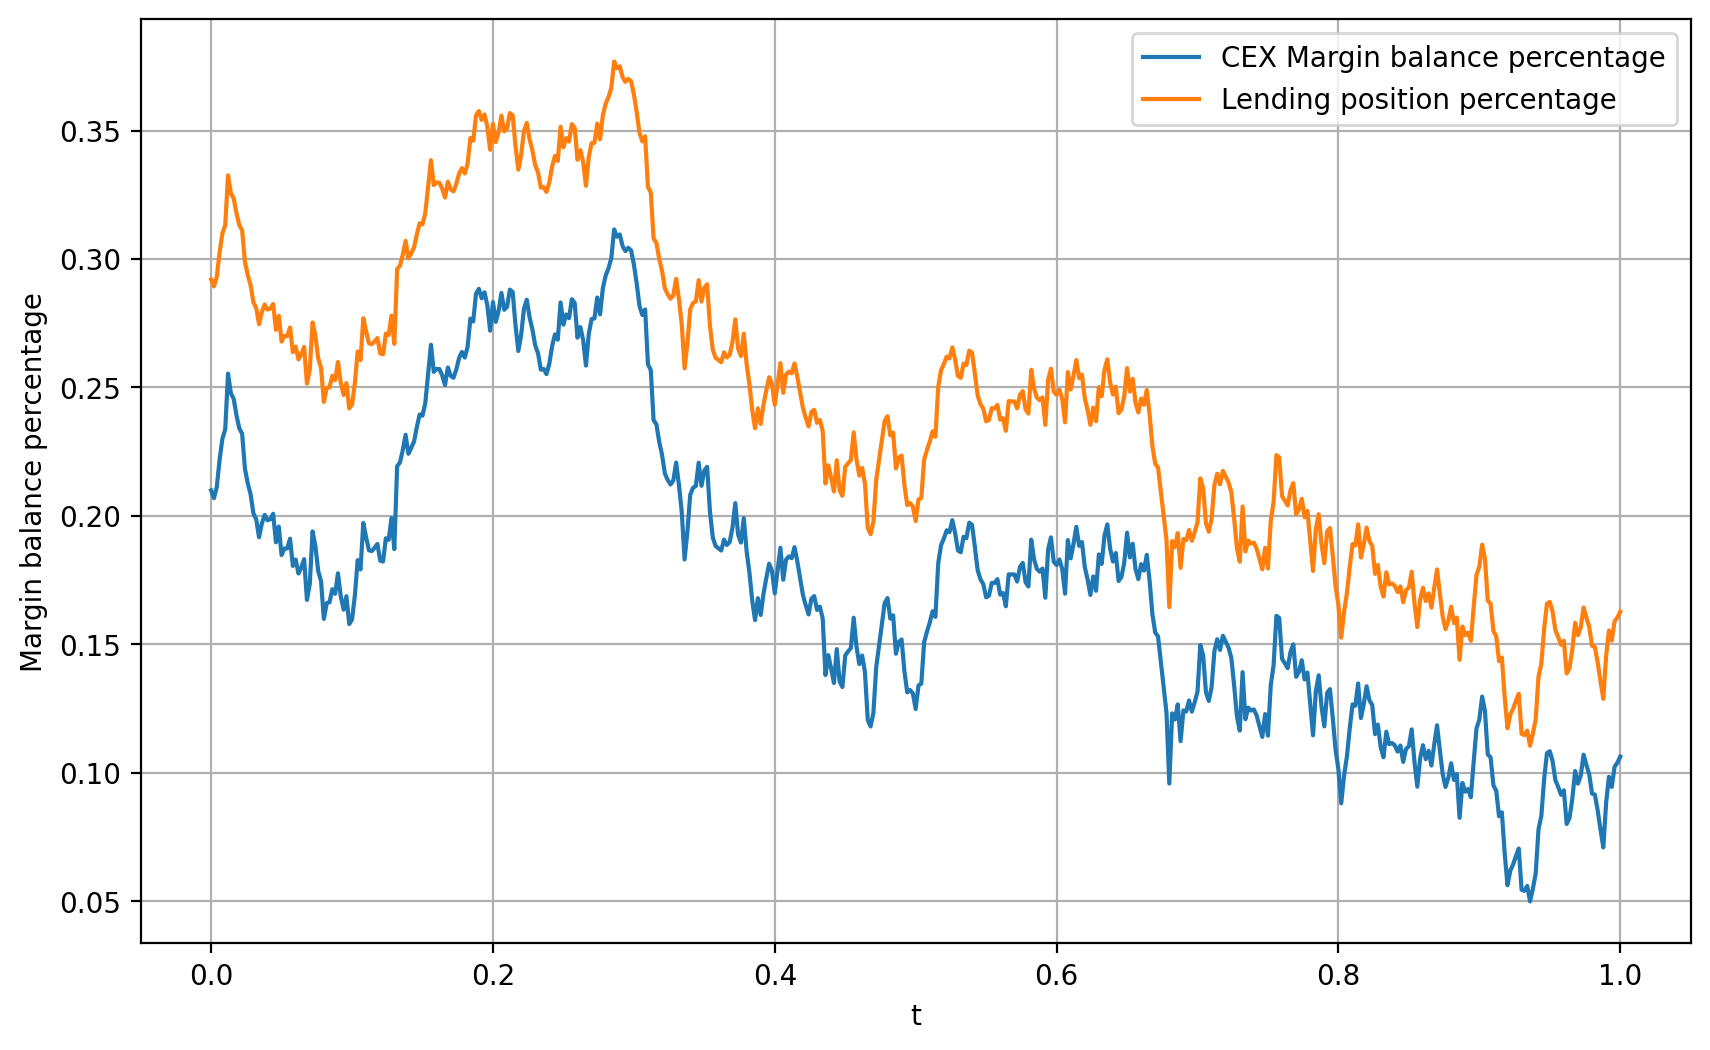

In [152]:
#Можно потыкать
lp = Portfolio_UniV2(params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['r_cd'], params['r_be'], params['theta'], params['D'])
lp.show()

<ipython-input-150-2254577897>:196: RuntimeWarning: divide by zero encountered in scalar divide
  probability = (((x + 1) / (1 - x))**((2 * u) / s**2 - 1) * (1 - erf(np.log((x + 1) / (1 - x)) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 + (1 - erf(np.log((x + 1) / (1 - x)) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2


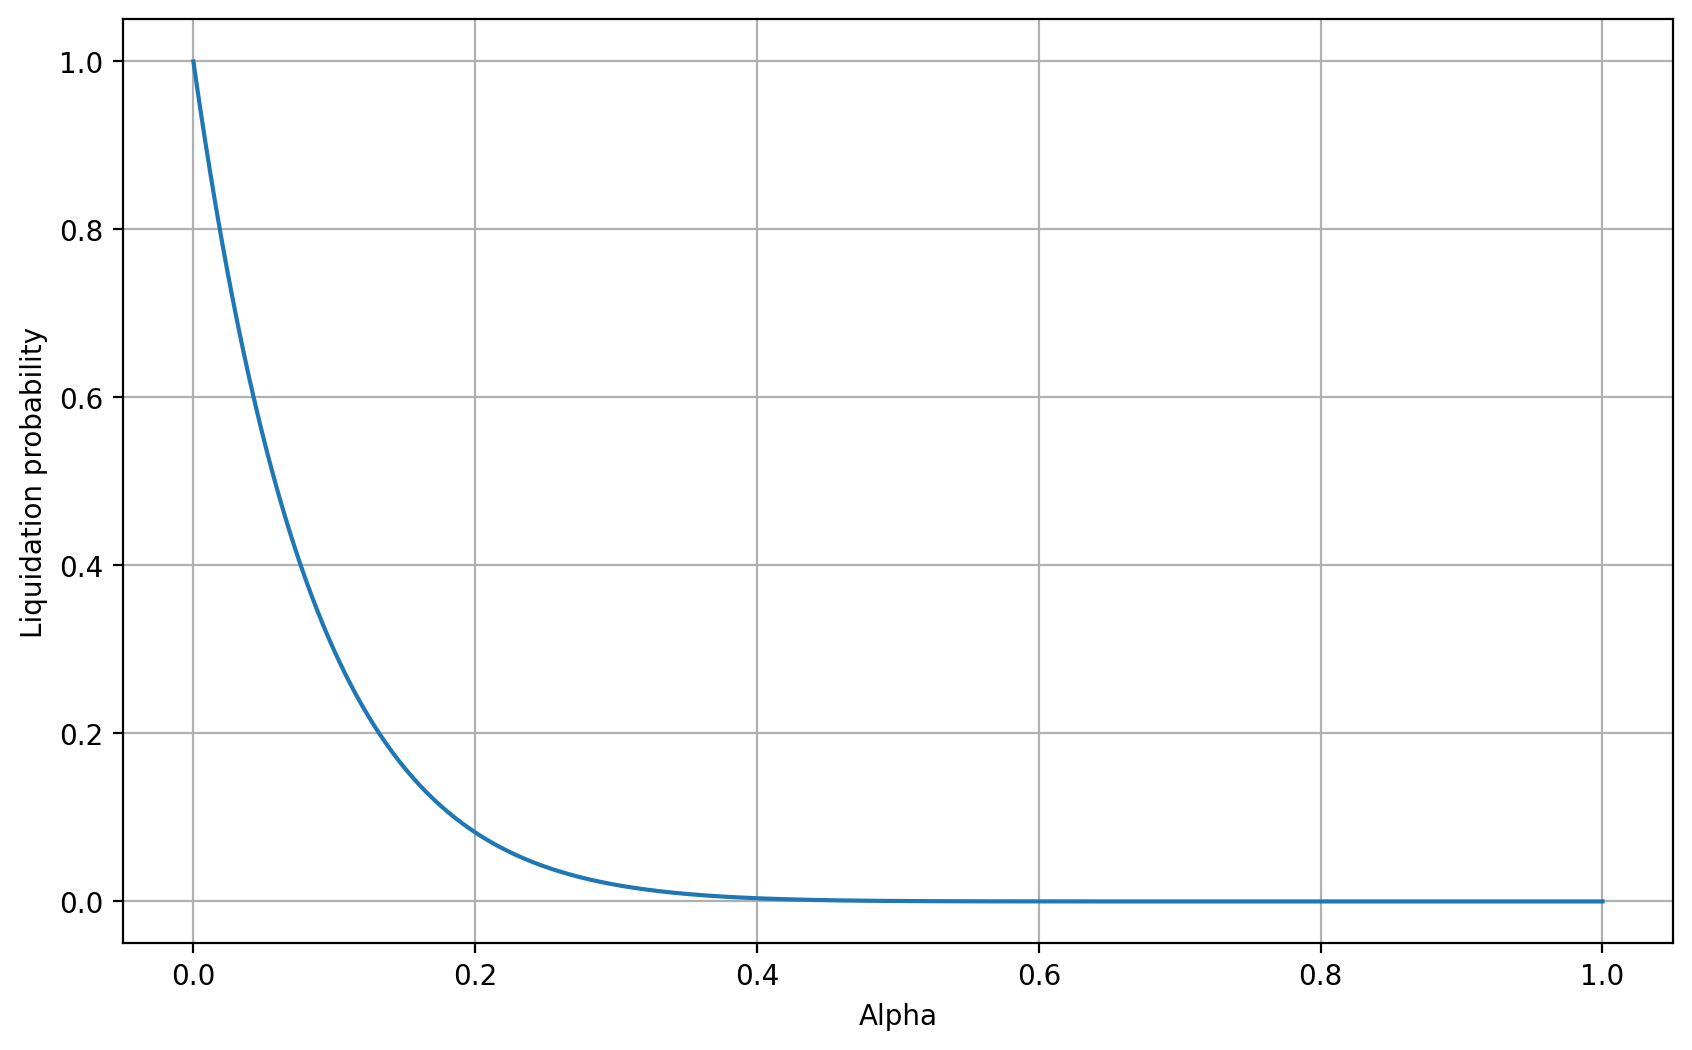

In [153]:
lp.liquidation_probability_dependency(params['b'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['l'], params['D'])

0.20989106693346524
0.29202322945888054


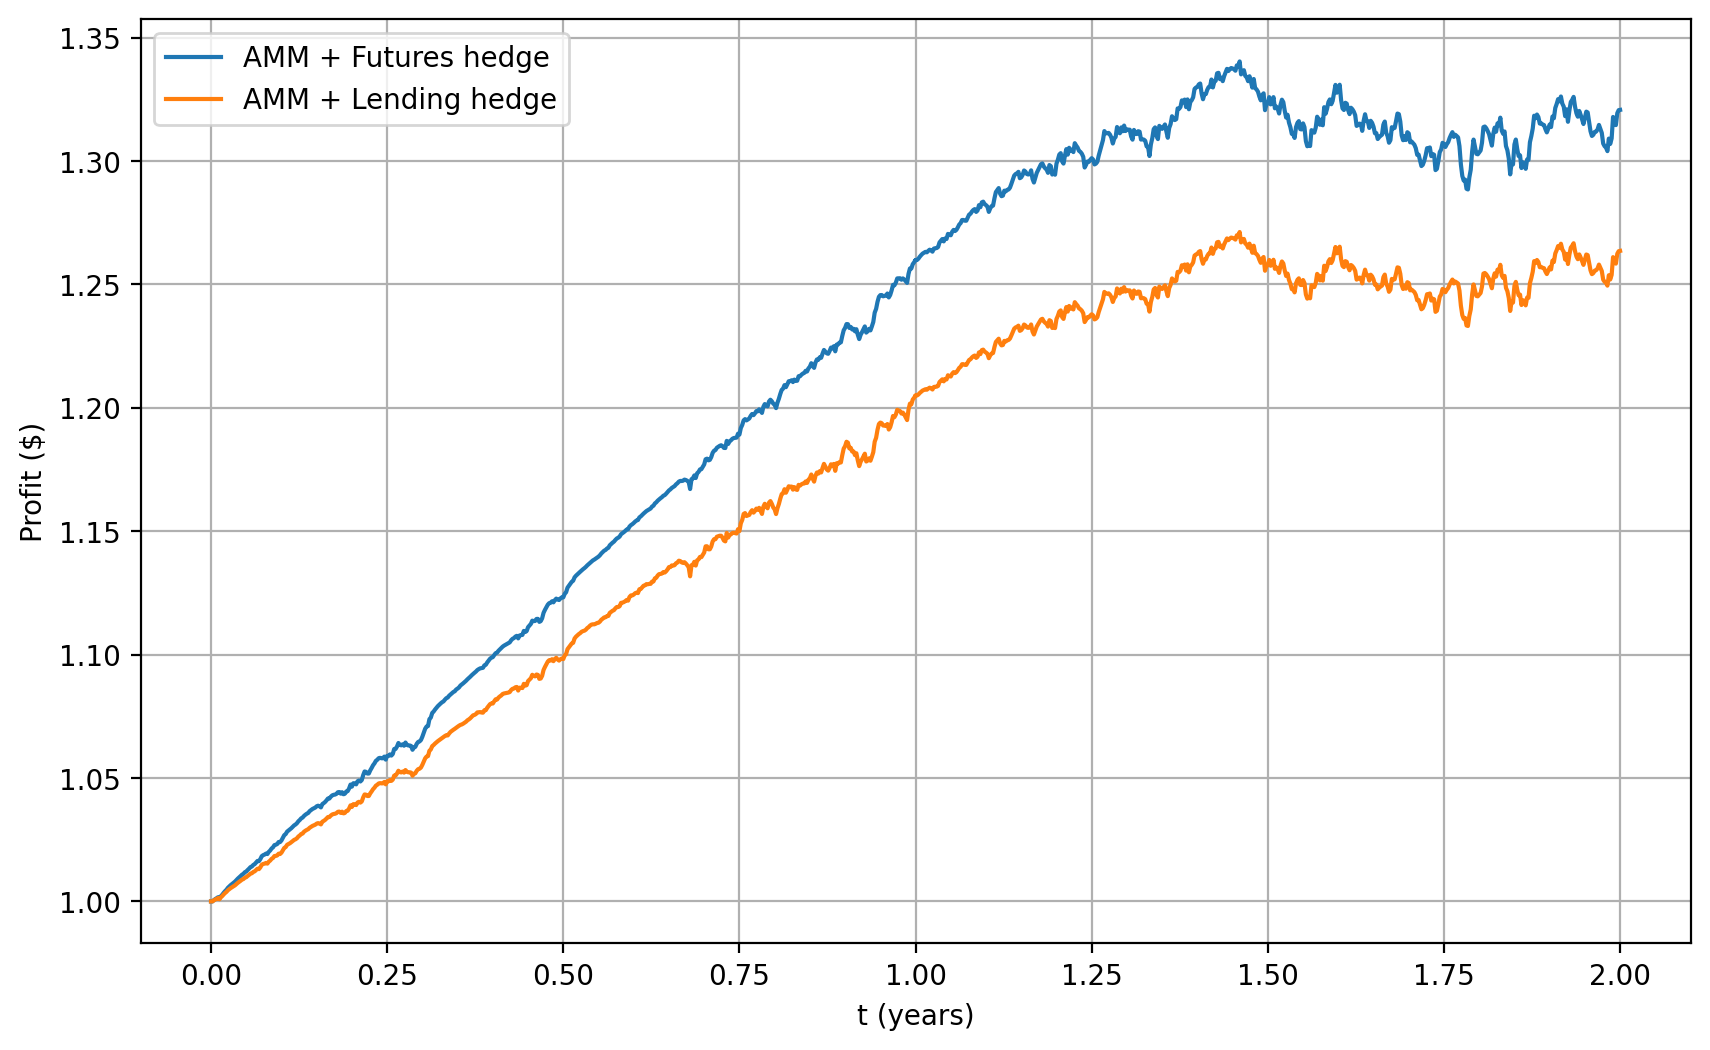

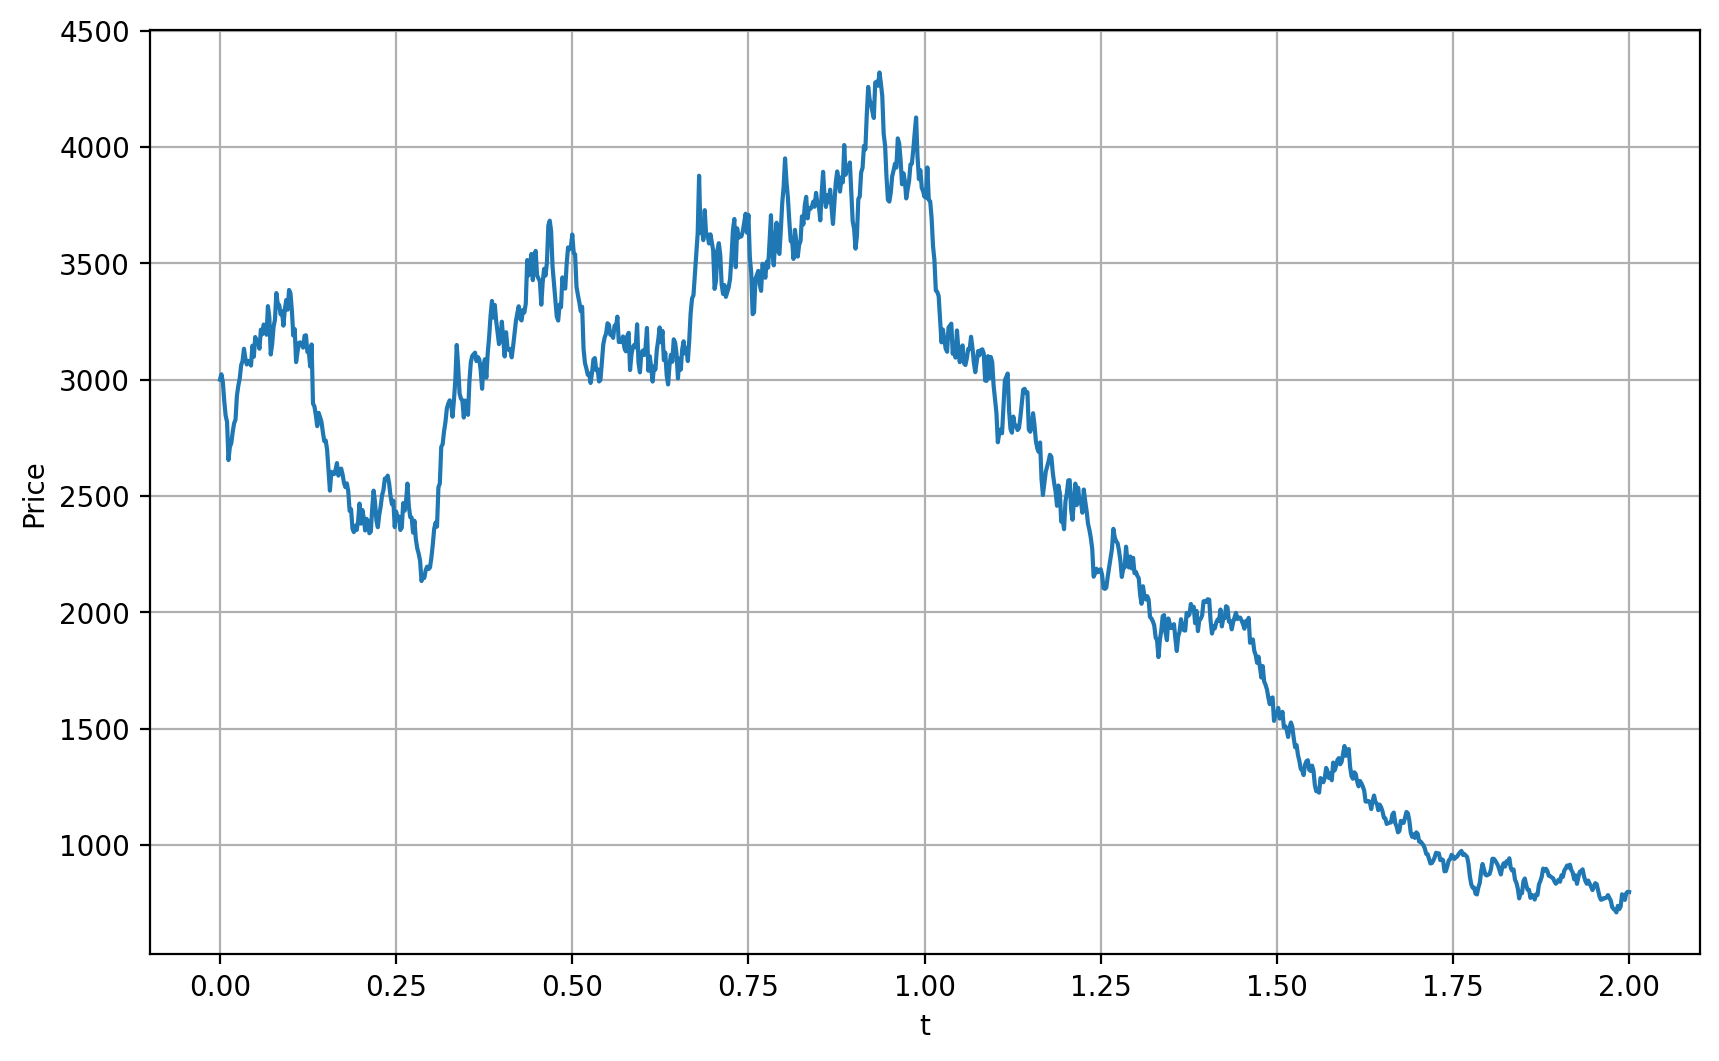

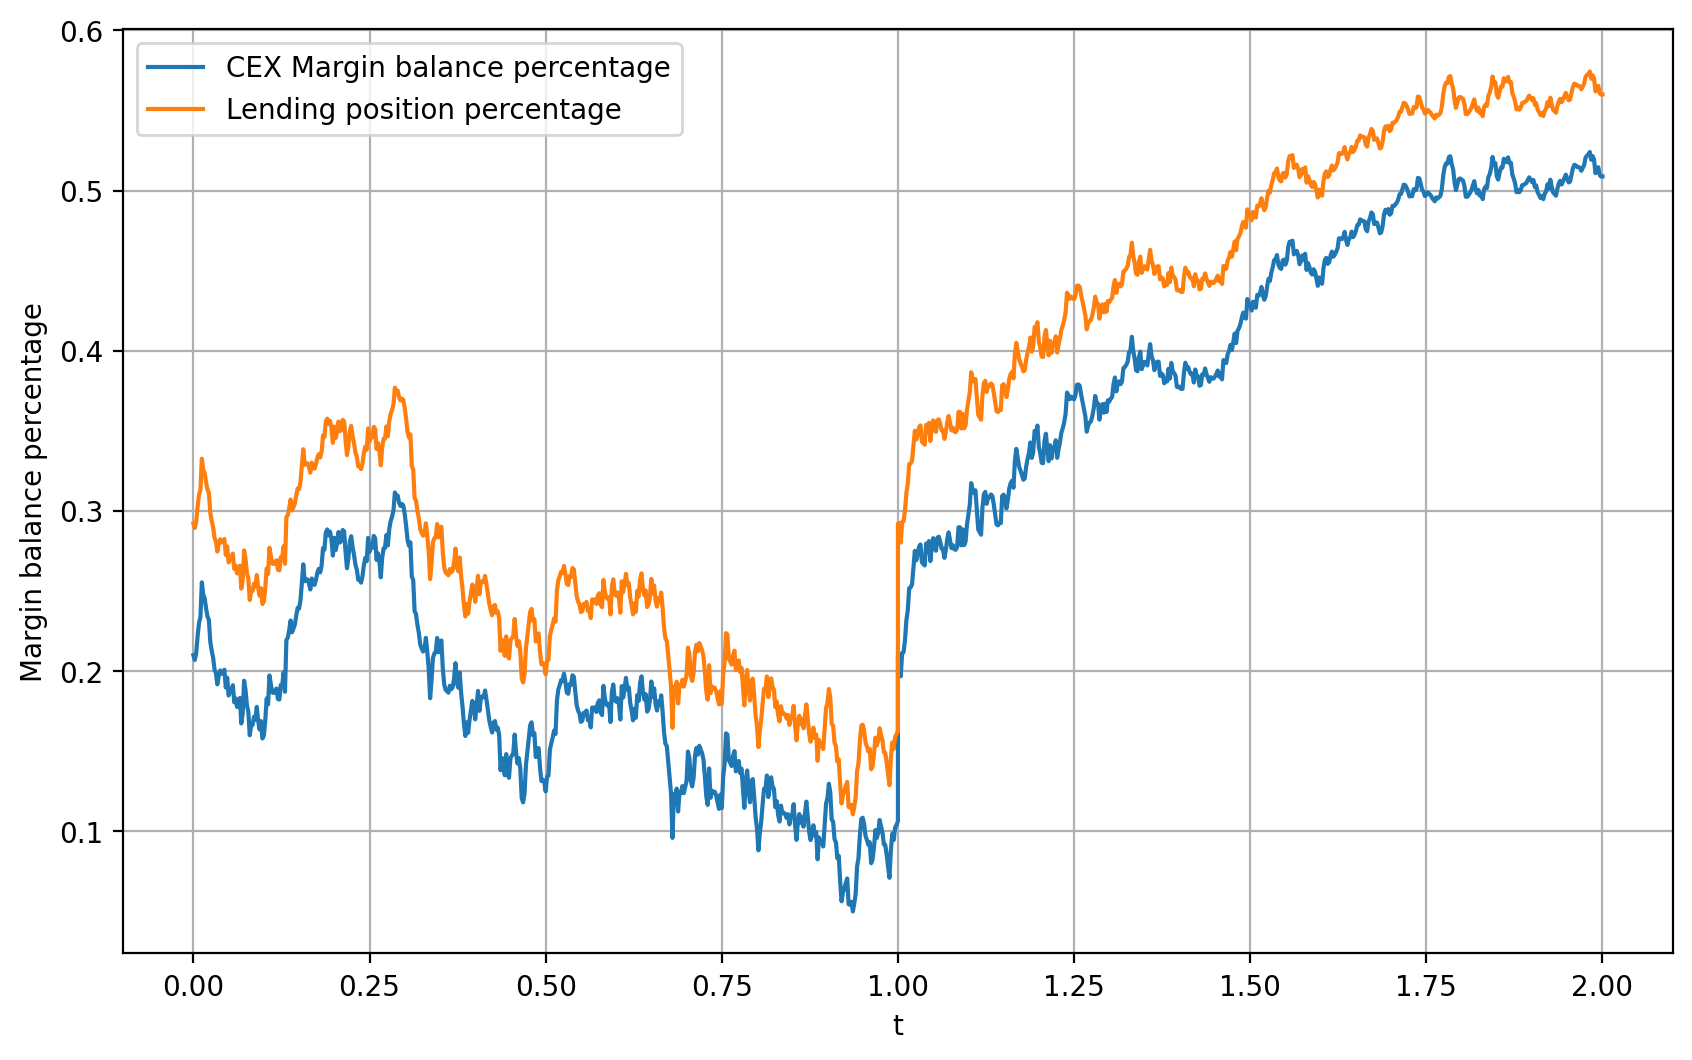

In [154]:
#Можно потыкать
lp.rebalance(params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['r_cd'], params['r_be'], params['theta'])
lp.show()

In [155]:
def MBP_dependency(b, t, u, sigma, kappa, iota, r_a, r_b, l, D):
    n_points = 100
    param_grid = {
    'param_b': np.linspace(0.1, 0.3, n_points),
    'param_t': np.linspace(0, 1.0, n_points),
    'param_u': np.linspace(-2, 2, n_points),
    'param_s': np.linspace(0, 2, n_points),
    'param_kappa': np.linspace(0, 0.5, n_points),
    'param_iota': np.linspace(0, 0.5, n_points),
    'param_r_a': np.linspace(0, 1.0, n_points),
    'param_r_b': np.linspace(0, 1.0, n_points)
    }

    MBPs = np.zeros(n_points)
    #Beta
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (param_grid['param_b'][i], t, u, sigma, kappa, iota, r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_b'], MBPs)
    plt.grid()
    plt.xlabel('Beta')
    plt.ylabel('Margin balance percentage')

    #Time
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, param_grid['param_t'][i], u, sigma, kappa, iota, r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_t'], MBPs)
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Margin balance percentage')

    #Mu
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, param_grid['param_u'][i], sigma, kappa, iota, r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_u'], MBPs)
    plt.grid()
    plt.xlabel('Mu')
    plt.ylabel('Margin balance percentage')

    #Sigma
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, u, param_grid['param_s'][i], kappa, iota, r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_s'], MBPs)
    plt.grid()
    plt.xlabel('Sigma')
    plt.ylabel('Margin balance percentage')

    #Kappa
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, u, sigma, param_grid['param_kappa'][i], iota, r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_kappa'], MBPs)
    plt.grid()
    plt.xlabel('Kappa')
    plt.ylabel('Margin balance percentage')

    #Iota
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, u, sigma, kappa, param_grid['param_iota'][i], r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_iota'], MBPs)
    plt.grid()
    plt.xlabel('Iota')
    plt.ylabel('Margin balance percentage')

    #Risk-less asset
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, u, sigma, kappa, iota, param_grid['param_r_a'][i], r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_r_a'], MBPs)
    plt.grid()
    plt.xlabel('Risk-less asset rate')
    plt.ylabel('Margin balance percentage')

    #Risk asset
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, u, sigma, kappa, iota, r_a, param_grid['param_r_b'][i], l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_r_b'], MBPs)
    plt.grid()
    plt.xlabel('Risk asset rate')
    plt.ylabel('Margin balance percentage')


In [156]:
#Можно потыкать
MBP_dependency(params['b'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['l'], params['D'])

NameError: name 'mean_first_derivative' is not defined

#Uniswap V3 + futures/lending hedge

In [157]:
import numpy as np
import scipy
import scipy.integrate as integrate
from scipy.special import erf
from scipy.optimize import minimize_scalar, differential_evolution

from matplotlib import pyplot as plt

from joblib import Parallel, delayed
import time

In [158]:
from dataclasses import dataclass

@dataclass
class Strategy:
    p_0: float
    p_a: float
    p_b: float
    hedge_percentage: float
    L: float
    only_inbound_prices: list



In [159]:
class Portfolio_UniV3:
    def __init__(self, p_0, p_a, p_b, beta, l, t, mu, sigma, kappa, iota, r_a, r_b, r_cd, r_be, theta, D, rebalance_ind, simulation_params):
        """
        Инициализация поставщика ликвидности.

        """
        #Simulation parameters
        self.n_paths = simulation_params['paths']
        self.n_steps = simulation_params['steps']

        #Market params
        self.p_0 = p_0
        self.p_a = p_a
        self.p_b = p_b
        self.beta = beta
        self.l = l
        self.t = t
        self.mu = mu
        self.sigma = sigma
        self.kappa = kappa
        self.iota = iota
        self.r_a = r_a
        self.r_b = r_b
        self.r_cd = r_cd
        self.r_be = r_be
        self.theta = theta
        self.fh_D = np.full(self.n_paths + 1, D, dtype=float)
        self.lh_D = np.full(self.n_paths + 1, D, dtype=float)

        #Additional
        self.exp_arr = np.exp(-l * np.arange(self.n_steps) / self.n_steps)
        self.rebalance_ind = rebalance_ind

        self.Time = 0 #Костыль

        self.price_history = np.array([[]])

        #Auxiliary arrays

        ##Futures hedge
        self.fh_portfolio_history = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.fh_AMM_fees_history = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.fh_portfolio_history_wr = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.MBP_history = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.futures_position_history = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.funding_fees_history = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.margin_collateral_history = np.zeros((self.n_paths + 1, self.n_steps + 1))

        self.fh_liquidation_prob_history = np.array([[]])
        self.fh_APY_history = np.array([[]])
        self.fh_delta_history = np.array([[]])

        self.fh_upper_bound = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.fh_lower_bound = np.zeros((self.n_paths + 1, self.n_steps + 1))

        ##Lending hedge
        self.lh_portfolio_history = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.lh_AMM_fees_history = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.lh_portfolio_history_wr = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.LHP_history = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.collateral_history = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.debt_history = np.zeros((self.n_paths + 1, self.n_steps + 1))

        self.lh_liquidation_prob_history = np.array([[]])
        self.lh_APY_history = np.array([[]])
        self.lh_delta_history = np.array([[]])

        self.lh_upper_bound = np.zeros((self.n_paths + 1, self.n_steps + 1))
        self.lh_lower_bound = np.zeros((self.n_paths + 1, self.n_steps + 1))

        #Rebalance points for visualisation
        self.portfolio_points = {
              # Стратегии с ребалансировкой (with rebalancing)
              "with_rebalancing": {
                  "futures_hedge": {
                      "liquidation": [],
                      "high_liquidation_risk": [],
                      "low_expected_return": [],
                      "high_delta": []
                  },
                  "lending_hedge": {
                      "liquidation": [],
                      "high_liquidation_risk": [],
                      "low_expected_return": [],
                      "high_delta": []
                  }
              },

              # Стратегии без ребалансировки (without rebalancing)
              "without_rebalancing": {
                  "futures_hedge": {
                      "liquidation": []  # Только точки ликвидации
                  },
                  "lending_hedge": {
                      "liquidation": []  # Только точки ликвидации
                  }
              }
          }

        self.time_grid = np.array([])

        self.start(p_a, p_b, beta, l, t, mu, sigma, kappa, iota, r_a, r_b, r_cd, r_be, theta)

    def start(self, p_a, p_b, b, l, t, mu, sigma, kappa, iota, r_a, r_b, r_cd, r_be, theta):
        #Simulation
        p_0 = self.p_0

        paths = self.gbm_path_generator(self.n_paths, self.n_steps, t, mu, sigma, p_0)
        self.price_history = paths['S']

        #Portfolio simulation
        for j in range(0, self.n_paths):
            print("------------------Path ", j, "-----------------------------------------------------------")
            p = paths['S'][j]

            #Position opening
            fh_p_0, fh_p_a, fh_p_b, MBP, fh_L, self.fh_D[j], fh_only_inbound_prices = self.fh_rebalance(p, p_0, p_a, p_b, b, l, t, mu, sigma, kappa, iota, r_a, r_b, self.fh_D[j])
            lh_p_0, lh_p_a, lh_p_b, LHP, lh_L, self.lh_D[j], lh_only_inbound_prices = self.lh_rebalance(p, p_0, p_a, p_b, b, l, t, mu, sigma, r_cd, r_be, theta, self.lh_D[j])

            #Position opening without future rebalances
            fh_p_0_wr, fh_p_a_wr, fh_p_b_wr, MBP_wr, fh_L_wr, fh_D_wr, fh_only_inbound_prices_wr = fh_p_0, fh_p_a, fh_p_b, MBP, fh_L, self.fh_D[j], fh_only_inbound_prices.copy() #wr - without rebalancing
            lh_p_0_wr, lh_p_a_wr, lh_p_b_wr, LHP_wr, lh_L_wr, lh_D_wr, lh_only_inbound_prices_wr = lh_p_0, lh_p_a, lh_p_b, LHP, lh_L, self.lh_D[j], lh_only_inbound_prices.copy()

            #Integrals
            fh_fees_int = np.zeros(self.n_steps + 1)
            lh_fees_int = np.zeros(self.n_steps + 1)
            futures_int = np.zeros(self.n_steps + 1)

            fh_last_rebalance_time = 0
            lh_last_rebalance_time = 0
            fh_liquidation_flag_wr = 0
            lh_liquidation_flag_wr = 0

            #Portfolio value
            for i in range(0, self.n_steps + 1):
                #AMM position
                fh_AMM, fh_fees = self.AMM_position(p[i], fh_p_a, fh_p_b, fh_L, fh_only_inbound_prices, i)
                lh_AMM, lh_fees= self.AMM_position(p[i], lh_p_a, lh_p_b, lh_L, lh_only_inbound_prices, i)

                fh_AMM_wr, fh_fees_wr = self.AMM_position(p[i], fh_p_a_wr, fh_p_b_wr, fh_L_wr, fh_only_inbound_prices_wr, i) #without rebalancing
                lh_AMM_wr, lh_fees_wr= self.AMM_position(p[i], lh_p_a_wr, lh_p_b_wr, lh_L_wr, lh_only_inbound_prices_wr, i)

                fh_AMM += fh_fees
                lh_AMM += lh_fees
                fh_AMM_wr += fh_fees_wr
                lh_AMM_wr += lh_fees_wr

                #Futures position
                MB, futures_pnl, funding_fees = self.futures_position(p[fh_last_rebalance_time:i], p[i], fh_p_0, fh_p_a, fh_p_b, MBP, self.fh_D[j])
                MB_wr, futures_pnl_wr, funding_fees_wr = self.futures_position(p[:i], p[i], fh_p_0_wr, fh_p_a_wr, fh_p_b_wr, MBP_wr, fh_D_wr)

                #Lending position
                collateral, debt = self.lending_position(p[i], lh_p_0, lh_p_a, lh_p_b, LHP, self.lh_D[j], i - lh_last_rebalance_time)
                collateral_wr, debt_wr = self.lending_position(p[i], lh_p_0_wr, lh_p_a_wr, lh_p_b_wr, LHP_wr, lh_D_wr, i)
                lending_pos = collateral - debt

                #Portfolio & hedge components values
                self.fh_portfolio_history[j][i] = fh_AMM + MB
                self.fh_AMM_fees_history[j][i] = fh_fees
                self.fh_portfolio_history_wr[j][i] = fh_AMM_wr + MB_wr
                self.MBP_history[j][i] = MB / (fh_AMM + MB)
                self.fh_upper_bound[j][i] = fh_p_b
                self.fh_lower_bound[j][i] = fh_p_a
                self.futures_position_history[j][i] = futures_pnl
                self.funding_fees_history[j][i] = funding_fees
                self.margin_collateral_history[j][i] = self.fh_D[j] * MBP

                self.lh_portfolio_history[j][i] = lh_AMM + lending_pos
                self.lh_AMM_fees_history[j][i] = lh_fees
                self.lh_portfolio_history_wr[j][i] = lh_AMM_wr + (collateral_wr - debt_wr)
                self.LHP_history[j][i] = lending_pos / (lh_AMM + lending_pos)
                self.lh_upper_bound[j][i] = lh_p_b
                self.lh_lower_bound[j][i] = lh_p_a
                self.collateral_history[j][i] = collateral
                self.debt_history[j][i] = debt

                #Rebalancing indicators
                fh_delta = fh_L * (1 / np.sqrt(p[i]) - 1 / np.sqrt(fh_p_0))
                lh_delta = lh_L * (1 / np.sqrt(p[i]) - 1 / np.sqrt(lh_p_0))

                fh_return = self.fh_portfolio_mean(self.MBP_history[j][i], p[i], fh_p_a, fh_p_b, b, l, t, mu, sigma, kappa, iota, r_a, r_b, self.fh_D[j]) / self.fh_D[j]
                lh_return = self.lh_portfolio_mean(self.LHP_history[j][i], p[i], lh_p_a, lh_p_b, b, l, t, mu, sigma, r_cd, r_be, theta, self.lh_D[j]) / self.lh_D[j]

                fh_liq_prob = self.fh_liquidation_probability(self.MBP_history[j][i], p[i], fh_p_a, fh_p_b, b, l, t, mu, sigma, kappa, iota, r_a, r_b, self.fh_portfolio_history[j][i])
                lh_liq_prob = self.lh_liquidation_probability(self.LHP_history[j][i], p[i], lh_p_a, lh_p_b, b, l, t, mu, sigma, r_cd, r_be, theta, self.lh_portfolio_history[j][i])

                #Костыли
                if (fh_liq_prob > 1):
                    print(
                    "MBP -", self.MBP_history[j][i],  # Текущая цена актива
                    "Цена:", p[i],              # Вероятностная оценка
                    "fh_p_a:", fh_p_a,                 # Вес актива A в портфеле
                    "fh_p_b:", fh_p_b,                 # Вес актива B в портфеле
                    "Стоимость портфеля:", self.fh_portfolio_history[j][i]  # Общая стоимость портфеля MBP
                    )

                if (lh_liq_prob > 1):
                    print(
                      "LHP -", self.LHP_history[j][i],  # Текущая цена актива
                      "Цена:", p[i],              # Вероятностная оценка
                      "lh_p_a:", lh_p_a,                 # Вес актива A в портфеле
                      "lh_p_b:", lh_p_b,                 # Вес актива B в портфеле
                      "Стоимость портфеля:", self.lh_portfolio_history[j][i]  # Общая стоимость портфеля MBP
                      )

                #Futures liquidation
                fh_liquidation_flag = 0
                if (MB <= 0 and MBP != 0):
                    fh_liquidation_flag = 1
                    fh_only_inbound_prices[:i + 1] = 0
                    self.portfolio_points["with_rebalancing"]["futures_hedge"]["liquidation"].append((i / self.n_steps, self.fh_portfolio_history[j][i]))
                    fh_p_0, fh_p_a, fh_p_b, MBP, fh_L, self.fh_D[j], fh_only_inbound_prices[i + 1:] = self.fh_rebalance(p[i + 1:], p[i], fh_p_a, fh_p_b, b, l, t, mu, sigma, kappa, iota, r_a, r_b, self.fh_portfolio_history[j][i])
                    print("Futures liquidation")

                   #without rebelancing
                if (fh_liquidation_flag_wr != 1 and MB_wr <= 0 and MBP_wr != 0):
                    fh_liquidation_flag_wr = 1
                    MB_wr = 0
                    self.portfolio_points["without_rebalancing"]["futures_hedge"]["liquidation"].append((i / self.n_steps, self.fh_portfolio_history_wr[j][i]))
                    print("Futures without rebalancing liquidation")

                #Lending liquidation
                lh_liquidation_flag = 0
                if (theta * collateral <= debt and LHP != 0):
                    lh_liquidation_flag = 1
                    lh_only_inbound_prices[:i + 1] = 0
                    self.portfolio_points["with_rebalancing"]["lending_hedge"]["liquidation"].append((i / self.n_steps, self.lh_portfolio_history[j][i]))
                    lh_p_0, lh_p_a, lh_p_b, LHP, lh_L, self.lh_D[j], lh_only_inbound_prices[i + 1:] = self.lh_rebalance(p[i + 1:], p[i], lh_p_a, lh_p_b, b, l, t, mu, sigma, r_cd, r_be, theta, self.lh_portfolio_history[j][i])
                    last_rebalance_time = i
                    print("Lending liquidation")

                if (lh_liquidation_flag_wr != 1 and theta * collateral_wr <= debt_wr and LHP_wr != 0):
                    lh_liquidation_flag_wr = 1
                    collateral_wr = 0
                    debt_wr = 0
                    self.portfolio_points["without_rebalancing"]["lending_hedge"]["liquidation"].append((i / self.n_steps, self.lh_portfolio_history_wr[j][i]))
                    print("Lending without rebalancing liquidation")

                #Rebalancing
                fh_delta_condition = np.abs(fh_delta) > self.rebalance_ind['delta']
                fh_liquidation_condition = fh_liq_prob > self.rebalance_ind['liq_prob']
                fh_return_condition = fh_return < self.rebalance_ind['APY']
                if fh_liquidation_flag != 1 and any([fh_delta_condition, fh_liquidation_condition, fh_return_condition]) and (i - fh_last_rebalance_time >= 20): #Костыль
                    # Добавление точек в соответствующие массивы
                    if fh_delta_condition:
                        self.portfolio_points["with_rebalancing"]["futures_hedge"]["high_delta"].append((i / self.n_steps, self.fh_portfolio_history[j][i]))
                        print("Futures rebalancing by delta")
                    elif fh_liquidation_condition:
                        self.portfolio_points["with_rebalancing"]["futures_hedge"]["high_liquidation_risk"].append((i / self.n_steps, self.fh_portfolio_history[j][i]))
                        print("Futures rebalancing by high liquidation probability")
                    elif fh_return_condition:
                        self.portfolio_points["with_rebalancing"]["futures_hedge"]["low_expected_return"].append((i / self.n_steps, self.fh_portfolio_history[j][i]))
                        print("Futures rebalancing by low expected return")

                    # Выполнение действия (ребалансировка)
                    fh_only_inbound_prices[:i + 1] = 0
                    fh_p_0, fh_p_a, fh_p_b, MBP, fh_L, self.fh_D[j], fh_only_inbound_prices[i + 1:] = self.fh_rebalance(p[i + 1:], p[i], fh_p_a, fh_p_b, b, l, t, mu, sigma, kappa, iota, r_a, r_b, self.fh_portfolio_history[j][i])
                    fh_last_rebalance_time = i

                lh_delta_condition = np.abs(lh_delta) > self.rebalance_ind['delta']
                lh_liquidation_condition = lh_liq_prob > self.rebalance_ind['liq_prob']
                lh_return_condition = lh_return < self.rebalance_ind['APY']
                if lh_liquidation_flag != 1 and any([lh_delta_condition, lh_liquidation_condition, lh_return_condition]) and (i - lh_last_rebalance_time >= 20): #Костыль

                    # Добавление точек в соответствующие массивы
                    if lh_delta_condition:
                        self.portfolio_points["with_rebalancing"]["lending_hedge"]["high_delta"].append((i / self.n_steps, self.lh_portfolio_history[j][i]))
                        print("Lending rebalancing by delta")
                    elif lh_liquidation_condition:
                        self.portfolio_points["with_rebalancing"]["lending_hedge"]["high_liquidation_risk"].append((i / self.n_steps, self.lh_portfolio_history[j][i]))
                        print("Lending rebalancing by high liquidation probability")
                    elif lh_return_condition:
                        self.portfolio_points["with_rebalancing"]["lending_hedge"]["low_expected_return"].append((i / self.n_steps, self.lh_portfolio_history[j][i]))
                        print("Lending rebalancing by low expected return")

                    # Выполнение действия (ребалансировка)
                    lh_only_inbound_prices[:i + 1] = 0
                    lh_p_0, lh_p_a, lh_p_b, LHP, lh_L, self.lh_D[j], lh_only_inbound_prices[i + 1:] = self.lh_rebalance(p[i + 1:], p[i], lh_p_a, lh_p_b, b, l, t, mu, sigma, r_cd, r_be, theta, self.lh_portfolio_history[j][i])
                    lh_last_rebalance_time = i

                # if (fh_liquidation_flag != 1):
                #     if (np.abs(fh_delta) > self.rebalance_ind['delta'] or fh_APY < self.rebalance_ind['APY'] or fh_liq_prob > self.rebalance_ind['liq_prob'])
                #     self.fh_rebalance_points.append(self.fh_portfolio_history[j][i])
                #     self.fh_rebalance_times.append(i / self.n_steps)
                #     fh_only_inbound_prices[:i + 1] = 0
                #     fh_p_0, fh_p_a, fh_p_b, MBP, fh_L, self.fh_D[j], fh_only_inbound_prices[i + 1:] = self.fh_rebalance(p[i + 1:], p[i], fh_p_a, fh_p_b, b, l, t, mu, sigma, kappa, iota, r_a, r_b, self.fh_portfolio_history[j][i])

                # if (lh_liquidation_flag != 1 and (np.abs(lh_delta) > self.rebalance_ind['delta'] or lh_APY < self.rebalance_ind['APY'] or lh_liq_prob > self.rebalance_ind['liq_prob'])):
                #     self.lh_rebalance_points.append(self.lh_portfolio_history[j][i])
                #     self.lh_rebalance_times.append(i / self.n_steps)
                #     lh_only_inbound_prices[:i + 1] = 0
                #     lh_p_0, lh_p_a, lh_p_b, LHP, lh_L, self.lh_D[j], lh_only_inbound_prices[i + 1:] = self.lh_rebalance(p[i + 1:], p[i], lh_p_a, lh_p_b, b, l, t, mu, sigma, r_cd, r_be, theta, self.lh_portfolio_history[j][i])
                #     last_rebalance_time = i

        self.time_grid = np.array(paths['time'])


    def AMM_position(self, p_curr, p_a, p_b, L, only_inbound_prices, i):
        if (p_curr < p_a):
          AMM = L * p_curr * (np.sqrt(p_b) - np.sqrt(p_a)) / np.sqrt(p_b * p_a)
        elif (p_curr >= p_a and p_curr <= p_b):
          AMM = L * (2 * np.sqrt(p_curr) - p_curr / np.sqrt(p_b) - np.sqrt(p_a))
        elif (p_curr > p_b):
          AMM = L * (np.sqrt(p_b) - np.sqrt(p_a))

        fees = L * self.beta * np.trapz(only_inbound_prices[:i] * self.exp_arr[:i], dx = 1 / self.n_steps)

        return AMM, fees

    def futures_position(self, p, p_curr, p_0, p_a, p_b, MBP, D):
        if (MBP == 0):
          MB = 0
          futures_pnl = 0
          funding_fees = 0
        else:
          futures_int = np.trapz(p, dx = 1 / self.n_steps) * ((self.kappa - self.iota) / (self.kappa + self.r_b - self.r_a) - 1) #Futures integral
          futures_pnl = D * (1 - MBP) / (2 * np.sqrt(p_0) - p_0 / np.sqrt(p_b) - np.sqrt(p_a)) * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (p_curr - p_0)
          funding_fees = D * (1 - MBP) / (2 * np.sqrt(p_0) - p_0 / np.sqrt(p_b) - np.sqrt(p_a)) * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * self.kappa * futures_int
          MB = MBP * D - (futures_pnl - funding_fees)

        return MB, futures_pnl, funding_fees

    def lending_position(self, p_curr, p_0, p_a, p_b, LHP, D, i):
        if (LHP == 0):
            debt = 0
            collateral = 0
        else:
            collateral = D * (p_0 * (1 - LHP) / (2 * np.sqrt(p_0) - p_0 / np.sqrt(p_b) - np.sqrt(p_a)) * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) + LHP) * np.exp(self.r_cd * i / self.n_steps)
            debt = D * (1 - LHP) / (2 * np.sqrt(p_0) - p_0 / np.sqrt(p_b) - np.sqrt(p_a)) * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * p_curr * np.exp(self.r_be * i / self.n_steps)

        return collateral, debt


    def fh_rebalance(self, p, p_curr, p_a, p_b, b, l, t, mu, sigma, kappa, iota, r_a, r_b, D):
        #New price range for liquidity providing
        range_size = p_b - p_a
        p_a = p_curr - range_size / 2 if p_curr - range_size / 2 >= 0 else 0
        p_b = p_curr + range_size / 2

        #Optimal alpha searching
        MBP = self.optimal_MBP(p_curr, p_a, p_b, b, l, t, mu, sigma, kappa, iota, r_a, r_b, D)

        #L constant
        fh_L = D * (1 - MBP) / (2 * np.sqrt(p_curr) - p_curr / np.sqrt(p_b) - np.sqrt(p_a))

        only_inbound_prices = [1 if p_a <= x <= p_b else 0 for x in p]
        only_inbound_prices = (2 * np.sqrt(p) -  p / np.sqrt(p_b) - np.sqrt(p_a)) * only_inbound_prices

        return p_curr, p_a, p_b, MBP, fh_L, D, only_inbound_prices

    def lh_rebalance(self, p, p_curr, p_a, p_b, b, l, t, mu, sigma, r_cd, r_be, theta, D):
        #New price range for liquidity providing
        range_size = p_b - p_a
        p_a = p_curr - range_size / 2 if p_curr - range_size / 2 >= 0 else 0
        p_b = p_curr + range_size / 2

        #Optimal alpha searching
        LHP = self.optimal_LHP(p_curr, p_a, p_b, b, l, t, mu, sigma, r_cd, r_be, theta, D)

        #L constant
        lh_L = D * (1 - LHP) / (2 * np.sqrt(p_curr) - p_curr / np.sqrt(p_b) - np.sqrt(p_a))

        only_inbound_prices = [1 if p_a <= x <= p_b else 0 for x in p]
        only_inbound_prices = (2 * np.sqrt(p) -  p / np.sqrt(p_b) - np.sqrt(p_a)) * only_inbound_prices

        return p_curr, p_a, p_b, LHP, lh_L, D, only_inbound_prices

    def gbm_path_generator(self, n_paths, n_steps, T, mu, sigma, S_0):
        # Create
        Z = np.random.normal(0.0, 1.0, [n_paths, n_steps])
        X = np.zeros([n_paths, n_steps + 1])
        time = np.zeros(n_steps + 1)

        X[:, 0] = np.log(S_0)
        dt = T / float(n_steps)

        for k in range(0, n_steps):
            X[:, k+1] = X[:, k] + (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, k]
            time[k+1] = time[k] + dt
        S = np.exp(X)
        paths = {'S': S, 'time': time}

        return paths

    #fh = futures hedge
    def optimal_MBP(self, p_0, p_a, p_b, b, l, t, u, s, k, i, n, r, D):
        # Инвертируем функцию для поиска глобального максимума
        def f_neg(x_array):
            #x = x_array[0]  # Извлекаем скаляр из массива
            return -self.fh_portfolio_mean(x_array, p_0, p_a, p_b, b, l, t, u, s, k, i, n, r, D)

        # Глобальная оптимизация методом дифференциальной эволюции
        result = differential_evolution(f_neg, bounds=[(0, 1)], strategy='best1bin', tol=1e-6)
        MBP = result.x[0]
        f_max = result.fun

        if (f_neg(0) <= f_max):
            MBP = 0

        if (1 - MBP < 1e-6):
            MBP = 1

        #print("MBP: ", MBP)

        return MBP

    def fh_portfolio_mean(self, x, p_0, p_a, p_b, b, v, t, u, s, k, i, n, r, D):
        #Liquidity provider's position mean
        V_P = (D * (-(p_0 * np.exp(t * u) * (erf((np.log(p_b / p_0) - t * (u + s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))) - erf((np.log(p_a / p_0) - t * (u + s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))))) / (2 * np.sqrt(p_b)) + (p_0 * (np.sqrt(p_b) - np.sqrt(p_a)) * np.exp(t * u) * (erf((np.log(p_a / p_0) - t * (u + s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))) + 1)) / (2 * np.sqrt(p_a * p_b)) + (np.sqrt(p_b) - np.sqrt(p_a)) * (1 - (erf((np.log(p_b / p_0) - t * (u - s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))) + 1) / 2) - (np.sqrt(p_a) * (erf((np.log(p_b / p_0) - t * (u - s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))) - erf((np.log(p_a / p_0) - t * (u - s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 + np.sqrt(p_0) * np.exp(t * (u / 2 - s**2 / 8)) * (erf((np.log(p_b / p_0) - t * u) / (np.sqrt(2) * s * np.sqrt(t))) - erf((np.log(p_a / p_0) - t * u) / (np.sqrt(2) * s * np.sqrt(t))))) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))

        #Accumulated fees mean
        # Векторизованные вычисления
        time_arr = np.arange(1, self.n_steps + 1) / self.n_steps

        # Общие компоненты
        sqrt_t = np.sqrt(time_arr)
        s_sq = s**2
        log_pb = np.log(p_b/p_0)
        log_pa = np.log(p_a/p_0)

        # Вычисление всех erf-компонентов
        erf_arg1 = (log_pb - time_arr*(u + s_sq/2)) / (np.sqrt(2)*sqrt_t*s)
        erf_arg2 = (log_pa - time_arr*(u + s_sq/2)) / (np.sqrt(2)*sqrt_t*s)
        erf_arg3 = (log_pb - time_arr*(u - s_sq/2)) / (np.sqrt(2)*sqrt_t*s)
        erf_arg4 = (log_pa - time_arr*(u - s_sq/2)) / (np.sqrt(2)*sqrt_t*s)
        erf_arg5 = (log_pb - time_arr*u) / (np.sqrt(2)*sqrt_t*s)
        erf_arg6 = (log_pa - time_arr*u) / (np.sqrt(2)*sqrt_t*s)

        # Основные компоненты
        term1 = p_0 * np.exp(time_arr*(u - v)) * (erf(erf_arg1) - erf(erf_arg2))
        term2 = np.sqrt(p_a) * np.exp(-v*time_arr) * (erf(erf_arg3) - erf(erf_arg4))
        term3 = np.sqrt(p_0) * np.exp(time_arr*(u/2 - s_sq/8 - v)) * (erf(erf_arg5) - erf(erf_arg6))

        denominator = -p_0/np.sqrt(p_b) - np.sqrt(p_a) + 2*np.sqrt(p_0)

        # Собираем выражение
        result = D * b * (-term1/(2*np.sqrt(p_b)) - term2/2 + term3) * (1 - x) / denominator

        # Создаем итоговый массив
        int_expression = np.zeros(self.n_steps + 1)
        int_expression[1:] = result

        V_F = np.trapz(int_expression, dx = 1 / self.n_steps)

        #Futures hedge mean
        V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**(2 * (u / s**2 + 1 / 2)) * (1 - erf((np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) + s**2 * t * (u / s**2 + 1 / 2)) / (np.sqrt(2) * s * np.sqrt(t)))) - erf((np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) - s**2 * t * (u / s**2 + 1 / 2)) / (np.sqrt(2) * s * np.sqrt(t))) + 1)) / 2)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))

        mean = V_P + V_F + V_H
        return mean

    def fh_liquidation_probability(self, x, p_0, p_a, p_b, b, v, t, u, s, k, i, n, r, D):
        probability = ((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 + (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2
        return probability

    #lh = lending ledge
    def optimal_LHP(self, p_0, p_a, p_b, b, l, t, mu, sigma, r_cd, r_be, theta, D):
        # Инвертируем функцию для поиска глобального максимума
        f_neg = lambda x: -self.lh_portfolio_mean(x, p_0, p_a, p_b, b, l, t, mu, sigma, r_cd, r_be, theta, D)

        # Глобальная оптимизация методом дифференциальной эволюции
        result = differential_evolution(f_neg, bounds=[(0, 1)], strategy='best1bin', tol=1e-6)
        LHP = result.x[0]
        f_max = result.fun

        if (LHP != 0):
          LHP = max(LHP, (1 - theta) / (1 - theta + theta / p_0 * (2 * np.sqrt(p_0) - p_0 / np.sqrt(p_b) - np.sqrt(p_a)) / (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b))))

        if (f_neg(0) <= f_max):
            LHP = 0

        if (1 - LHP < 1e-5):
            LHP = 1

        #print("LHP: ", LHP)

        return LHP

    def lh_portfolio_mean(self, x, p_0, p_a, p_b, b, v, t, u, s, r_cd, r_be, theta, D):
        #Liquidity provider's position mean
        V_P = (D * (-(p_0 * np.exp(t * u) * (erf((np.log(p_b / p_0) - t * (u + s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))) - erf((np.log(p_a / p_0) - t * (u + s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))))) / (2 * np.sqrt(p_b)) + (p_0 * (np.sqrt(p_b) - np.sqrt(p_a)) * np.exp(t * u) * (erf((np.log(p_a / p_0) - t * (u + s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))) + 1)) / (2 * np.sqrt(p_a * p_b)) + (np.sqrt(p_b) - np.sqrt(p_a)) * (1 - (erf((np.log(p_b / p_0) - t * (u - s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))) + 1) / 2) - (np.sqrt(p_a) * (erf((np.log(p_b / p_0) - t * (u - s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))) - erf((np.log(p_a / p_0) - t * (u - s**2 / 2)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 + np.sqrt(p_0) * np.exp(t * (u / 2 - s**2 / 8)) * (erf((np.log(p_b / p_0) - t * u) / (np.sqrt(2) * s * np.sqrt(t))) - erf((np.log(p_a / p_0) - t * u) / (np.sqrt(2) * s * np.sqrt(t))))) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))

        #Accumulated fees mean
        # Векторизованные вычисления
        time_arr = np.arange(1, self.n_steps + 1) / self.n_steps

        # Общие компоненты
        sqrt_t = np.sqrt(time_arr)
        s_sq = s**2
        log_pb = np.log(p_b/p_0)
        log_pa = np.log(p_a/p_0)

        # Вычисление всех erf-компонентов
        erf_arg1 = (log_pb - time_arr*(u + s_sq/2)) / (np.sqrt(2)*sqrt_t*s)
        erf_arg2 = (log_pa - time_arr*(u + s_sq/2)) / (np.sqrt(2)*sqrt_t*s)
        erf_arg3 = (log_pb - time_arr*(u - s_sq/2)) / (np.sqrt(2)*sqrt_t*s)
        erf_arg4 = (log_pa - time_arr*(u - s_sq/2)) / (np.sqrt(2)*sqrt_t*s)
        erf_arg5 = (log_pb - time_arr*u) / (np.sqrt(2)*sqrt_t*s)
        erf_arg6 = (log_pa - time_arr*u) / (np.sqrt(2)*sqrt_t*s)

        # Основные компоненты
        term1 = p_0 * np.exp(time_arr*(u - v)) * (erf(erf_arg1) - erf(erf_arg2))
        term2 = np.sqrt(p_a) * np.exp(-v*time_arr) * (erf(erf_arg3) - erf(erf_arg4))
        term3 = np.sqrt(p_0) * np.exp(time_arr*(u/2 - s_sq/8 - v)) * (erf(erf_arg5) - erf(erf_arg6))

        denominator = -p_0/np.sqrt(p_b) - np.sqrt(p_a) + 2*np.sqrt(p_0)

        # Собираем выражение
        result = D * b * (-term1/(2*np.sqrt(p_b)) - term2/2 + term3) * (1 - x) / denominator

        # Создаем итоговый массив
        int_expression = np.zeros(self.n_steps + 1)
        int_expression[1:] = result

        V_F = np.trapz(int_expression, dx = 1 / self.n_steps)

        #Lending hedge mean
        if (x == 0): #Костыль?
          theta = 1

        V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 + 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u + s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u + s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))

        mean = V_P + V_F + V_H
        return mean

    def lh_liquidation_probability(self, x, p_0, p_a, p_b, b, v, t, u, s, r_cd, r_be, theta, D):
        probability = (((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 + (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2
        return probability

    def APY_MBP_dependency(self, p_0, p_a, p_b, beta, l, t, mu, sigma, kappa, iota, r_a, r_b, D):
        optimal_MBP = self.optimal_MBP(p_0, p_a, p_b, beta, l, t, mu, sigma, kappa, iota, r_a, r_b, D)
        print("Optimal MBP:: ", optimal_MBP)
        n_points = 1000
        APY = np.zeros(n_points)
        MBP = np.linspace(0.0, 1.0, n_points)

        for i in range (0, n_points):
          APY[i] = self.fh_portfolio_mean(MBP[i], p_0, p_a, p_b, beta, l, t, mu, sigma, kappa, iota, r_a, r_b, D)

        plt.figure(figsize = (10, 6))
        plt.plot(MBP, APY)
        plt.grid()
        plt.xlabel('Share')
        plt.ylabel('Return')

    def APY_LHP_dependency(self, p_0, p_a, p_b, beta, l, t, mu, sigma, r_cd, r_be, theta, D):
        optimal_LHP = self.optimal_LHP(p_0, p_a, p_b, beta, l, t, mu, sigma, r_cd, r_be, theta, D)
        print("Optimal LHP: ", optimal_LHP)

        n_points = 1000
        APY = np.zeros(n_points)
        LHPs = np.linspace(0.0, 1.0, n_points)
        LHP_min = (1 - theta) / (1 - theta + theta / p_0 * (2 * np.sqrt(p_0) - p_0 / np.sqrt(p_b) - np.sqrt(p_a)) / (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)))
        for i in range (0, n_points):
          if (i == 0):
            LHP = 0
          else:
            LHP = max(LHPs[i], LHP_min)

          APY[i] = self.lh_portfolio_mean(LHP, p_0, p_a, p_b, beta, l, t, mu, sigma, r_cd, r_be, theta, D)

        plt.figure(figsize = (10, 6))
        plt.scatter(LHPs[0], APY[0], color="r", s=100)
        plt.plot(LHPs[LHPs > LHP_min], APY[LHPs > LHP_min])
        plt.grid()
        plt.xlabel('Share')
        plt.ylabel('Return')

    def fh_liquidation_probability_dependency(self, p_0, p_a, p_b, b, l, t, u, s, k, i, n, r, D):
        n_points = 1000
        liq_probs = np.zeros(n_points)
        MBP = np.linspace(0.0, 1.0, n_points)

        for i in range (0, n_points):
          liq_probs[i] = self.fh_liquidation_probability(MBP[i], p_0, p_a, p_b, b, l, t, u, s, k, i, n, r, D)

        plt.figure(figsize = (10, 6))
        plt.plot(MBP, liq_probs)
        plt.grid()
        plt.xlabel('Alpha')
        plt.ylabel('Liquidation probability')

    def show(self):
        plt.figure(figsize = (10, 6))
        plt.plot(self.time_grid, self.fh_portfolio_history, self.time_grid, self.lh_portfolio_history)
        plt.grid()
        plt.xlabel('t (years)')
        plt.ylabel('Profit ($)')
        plt.legend (('AMM + Futures hedge', 'AMM + Lending hedge'))

        plt.figure(figsize = (10, 6))
        plt.plot(self.time_grid, self.price_history)
        plt.grid()
        plt.xlabel('t')
        plt.ylabel('Price')

        plt.figure(figsize = (10, 6))
        plt.plot(self.time_grid, self.MBP_history, self.time_grid, self.LHP_history)
        plt.grid()
        plt.xlabel('t')
        plt.ylabel('Margin balance percentage')
        plt.legend (('CEX Margin balance percentage', 'Lending position percentage'))

#Simulations

In [160]:
#Parameters

params = {
    'p_0': 3000,
    'p_a' : 2400,
    'p_b' : 3600,
    'b': 0.3,
    'l': 0.05,
    't': 1,
    'u': -0.3,
    's': 0.2,
    'kappa': 0.05,
    'iota': 0.01,
    'r_a': 0.05,
    'r_b': 0.0174,
    'r_cd': 0.05, #0.03 as default
    'r_be': 0.07,
    'theta': 0.9,
    'D': 1
    }

rebalance_cond = {
    'delta': 0.05,
    'APY' : 1.06,
    'liq_prob' : 0.06
    }

simulation_params = {
    'paths': 40,
    'steps' : 500,
    }

simulation_params_chart = {
    'paths': 1,
    'steps' : 100,
    }

In [161]:
lp = Portfolio_UniV3(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['r_cd'], params['r_be'], params['theta'], params['D'], rebalance_cond, simulation_params_chart)

------------------Path  0 -----------------------------------------------------------
Lending rebalancing by low expected return


<ipython-input-159-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)
<ipython-input-159-2872108846>:514: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)
<ipython-input-159-2872108846>:306: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fees = L * self.beta * np.trapz(only_inbound_prices[:i] * self.exp_arr[:i], dx = 1 / self.n_steps)
<ipython-input-159-2872108846>:316: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  futures_int = np.trapz(p, dx = 1 / self.n_steps) * ((self.kappa - self.iota) / (self.kappa + self

Futures rebalancing by low expected return


In [162]:
#Можно потыкать
simulations = Portfolio_UniV3(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['r_cd'], params['r_be'], params['theta'], params['D'], rebalance_cond, simulation_params)

------------------Path  0 -----------------------------------------------------------
Lending rebalancing by low expected return


<ipython-input-159-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)
<ipython-input-159-2872108846>:514: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)
<ipython-input-159-2872108846>:306: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fees = L * self.beta * np.trapz(only_inbound_prices[:i] * self.exp_arr[:i], dx = 1 / self.n_steps)
<ipython-input-159-2872108846>:316: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  futures_int = np.trapz(p, dx = 1 / self.n_steps) * ((self.kappa - self.iota) / (self.kappa + self

Futures rebalancing by low expected return
Lending rebalancing by high liquidation probability
------------------Path  1 -----------------------------------------------------------
Lending rebalancing by low expected return
Futures rebalancing by low expected return
Lending rebalancing by low expected return
Futures rebalancing by low expected return
Futures rebalancing by high liquidation probability
Lending rebalancing by low expected return
------------------Path  2 -----------------------------------------------------------


<ipython-input-159-2872108846>:446: RuntimeWarning: invalid value encountered in scalar power
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) - n

MBP - 0.022721557704301218 Цена: 3661.1758666068795 fh_p_a: 2400.0 fh_p_b: 3600.0 Стоимость портфеля: 1.1339633006581022
Futures rebalancing by high liquidation probability
LHP - 0.08512003300256753 Цена: 3726.017383499524 lh_p_a: 2400.0 lh_p_b: 3600.0 Стоимость портфеля: 1.0947131160533037
Lending rebalancing by high liquidation probability
Futures rebalancing by low expected return
Futures without rebalancing liquidation
Lending rebalancing by low expected return


<ipython-input-159-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x)

Lending without rebalancing liquidation
Futures rebalancing by low expected return
Lending rebalancing by low expected return
Futures rebalancing by low expected return
Lending rebalancing by low expected return
Futures rebalancing by low expected return
Lending rebalancing by low expected return
Futures rebalancing by low expected return
Lending rebalancing by low expected return


<ipython-input-159-2872108846>:520: RuntimeWarning: divide by zero encountered in divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x) * (-((

Futures rebalancing by low expected return
Lending rebalancing by low expected return
Lending rebalancing by low expected return
Lending rebalancing by low expected return
Futures rebalancing by low expected return
Lending rebalancing by low expected return
------------------Path  3 -----------------------------------------------------------
Lending rebalancing by low expected return
LHP - 0.06938384268934772 Цена: 3470.230044968574 lh_p_a: 2145.6559156854873 lh_p_b: 3345.6559156854873 Стоимость портфеля: 1.1204065834261814
Lending rebalancing by high liquidation probability
Lending rebalancing by low expected return
Lending rebalancing by low expected return
Lending rebalancing by low expected return
------------------Path  4 -----------------------------------------------------------
Lending rebalancing by low expected return
Futures rebalancing by low expected return
Lending rebalancing by low expected return
Futures rebalancing by low expected return
Lending rebalancing by low expe

#Visualization code

In [163]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

def visualize_portfolio_simulations_matplotlib(
    time_grid,
    portfolio_rebalanced,
    portfolio_unrebalanced,
    portfolio_points,
    figsize=(12, 8),
    max_trajectories=100,
    y_limits=(0.7, 1.3),
    legend_outside=True,
    show_strategies=('futures_hedge', 'lending_hedge')  # Новый параметр
):
    # Вычисление статистики
    final_rebalanced = portfolio_rebalanced[:, -1]
    final_unrebalanced = portfolio_unrebalanced[:, -1]
    mean_rebalanced = np.mean(final_rebalanced)
    var_rebalanced = np.var(final_rebalanced)
    mean_unrebalanced = np.mean(final_unrebalanced)
    var_unrebalanced = np.var(final_unrebalanced)
    print(f'Mean with rebalance: {mean_rebalanced:.4f}')
    print(f'Std with rebalance: {np.sqrt(var_rebalanced):.4f}')
    print(f'Mean without rebalance: {mean_unrebalanced:.4f}')
    print(f'Std without rebalance: {np.sqrt(var_unrebalanced):.4f}')

    # Ограничение количества траекторий
    n_total = portfolio_rebalanced.shape[0]
    n_plot = min(n_total, max_trajectories)

    if n_total > n_plot:
        print(f"Displaying {n_plot}/{n_total} random trajectories")
        indices = np.random.choice(n_total, n_plot, replace=False)
        portfolio_rebalanced = portfolio_rebalanced[indices]
        portfolio_unrebalanced = portfolio_unrebalanced[indices]
    else:
        indices = np.arange(n_total)

    fig, ax = plt.subplots(figsize=figsize)
    colors = [
        '#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A',
        '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52'
    ]

    # 1. Visualization of trajectories
    segments_rebalanced = [np.column_stack([time_grid, y]) for y in portfolio_rebalanced]
    segments_unrebalanced = [np.column_stack([time_grid, y]) for y in portfolio_unrebalanced]

    lc_rebalanced = LineCollection(
        segments_rebalanced,
        colors=[colors[i % len(colors)] for i in range(len(portfolio_rebalanced))],
        linewidths=0.8,
        linestyles='solid',
        alpha=0.5
    )
    lc_unrebalanced = LineCollection(
        segments_unrebalanced,
        colors=[colors[i % len(colors)] for i in range(len(portfolio_unrebalanced))],
        linewidths=0.8,
        linestyles='dotted',
        alpha=0.5
    )

    ax.add_collection(lc_rebalanced)
    ax.add_collection(lc_unrebalanced)

    # 2. Styles for points
    point_styles = {
        'with_rebalancing': {
            'liquidation': {'color': '#d62728', 'marker': 'x', 's': 36, 'label': 'Liquidation (rebalanced)', 'zorder': 10},
            'high_liquidation_risk': {'color': '#ff7f0e', 'marker': '^', 's': 24, 'label': 'High Liquidation Risk', 'zorder': 9},
            'low_expected_return': {'color': '#1f77b4', 'marker': 's', 's': 24, 'label': 'Low Expected Return', 'zorder': 8},
            'high_delta': {'color': '#2ca02c', 'marker': 'D', 's': 24, 'label': 'High Delta', 'zorder': 7}
        },
        'without_rebalancing': {
            'liquidation': {'color': '#7f7f7f', 'marker': 'X', 's': 42, 'label': 'Liquidation (unrebalanced)', 'zorder': 11}
        }
    }

    # 3. Filtering and visualization of points (with a choice of strategies)
    for rebalance_type, strategies in portfolio_points.items():
        for strategy, conditions in strategies.items():
            if strategy not in show_strategies:
                continue

            for condition_type, points in conditions.items():
                if points and condition_type in point_styles.get(rebalance_type, {}):
                    style = point_styles[rebalance_type][condition_type]
                    filtered_points = []
                    for point in points:
                        if len(point) == 3:
                            sim_idx, t, value = point
                            if sim_idx in indices:
                                filtered_points.append((t, value))
                        else:
                            filtered_points.append(point)

                    if filtered_points:
                        x = [p[0] for p in filtered_points]
                        y = [p[1] for p in filtered_points]

                        ax.scatter(
                            x, y,
                            s=style['s'],
                            color=style['color'],
                            marker=style['marker'],
                            alpha=0.9,
                            zorder=style['zorder'],
                            edgecolors='black' if style['marker'] in ['s', 'D', '^'] else 'none',
                            linewidths=0.8
                        )

    #4. Creating a Legend
    legend_elements = [
        Line2D([0], [0], color='gray', lw=1, ls='-', label='With rebalancing'),
        Line2D([0], [0], color='gray', lw=1, ls=':', label='Without rebalancing')
    ]

    for rebalance_type in point_styles.values():
        for style in rebalance_type.values():
            legend_elements.append(
                Line2D([0], [0],
                    marker=style['marker'],
                    color='w',
                    markerfacecolor=style['color'],
                    markeredgecolor='black' if style['marker'] in ['s', 'D', '^'] else style['color'],
                    markersize=8,
                    label=style['label'])
            )

    #5. Legend Placement
    if legend_outside:
        leg = ax.legend(
            handles=legend_elements,
            loc='upper left',
            bbox_to_anchor=(1.05, 1),
            framealpha=0.9,
            fontsize=9
        )
        plt.tight_layout(rect=[0, 0, 0.85, 1])
    else:
        leg = ax.legend(
            handles=legend_elements,
            loc='best',
            framealpha=0.9,
            fontsize=9
        )
        plt.tight_layout()

    #6. Adjusting the axes
    ax.set_xlim(time_grid.min(), time_grid.max())
    ax.set_ylim(*y_limits)

    strategies_names = {
        'futures_hedge': 'Futures Hedge',
        'lending_hedge': 'Lending Hedge'
    }
    title_parts = [strategies_names[s] for s in show_strategies]
    title = 'Portfolio Simulations: ' + ' & '.join(title_parts)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Portfolio Value', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color('grey')

    return fig

In [164]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_portfolio_components(
    time_grid,
    portfolio_total,
    portfolio_points,
    strategy_name='futures_hedge',  # 'futures_hedge' или 'lending_hedge'
    amm_position=None,
    fees_accumulated=None,
    margin_collateral=None,
    futures_pnl=None,
    funding_fees=None,
    debt_value=None,
    collateral_value=None,
    figsize=(14, 10),
    line_width=1.5,
    legend_outside=True
):
    """
    Визуализация компонентов портфеля с точками событий

    Args:
        time_grid: временная сетка
        portfolio_total: общая стоимость портфеля
        portfolio_points: словарь со всеми точками событий
        strategy_name: имя стратегии ('futures_hedge' или 'lending_hedge')
        amm_position: позиция в AMM
        fees_accumulated: накопленные комиссии
        margin_collateral: залог под фьючерсы (только для futures_hedge)
        futures_pnl: PnL фьючерсов (только для futures_hedge)
        funding_fees: фандинговые платежи (только для futures_hedge)
        debt_value: стоимость долга (только для lending_hedge)
        collateral_value: стоимость залога (только для lending_hedge)
        figsize: размер фигуры
        line_width: толщина линий
        legend_outside: размещать легенду вне графика
    """
    # Создаем фигуру и оси
    fig, ax = plt.subplots(figsize=figsize)

    # Определение компонентов в зависимости от стратегии
    if strategy_name == 'lending_hedge':
        # Компоненты для лендинговой стратегии
        labels = ['Portfolio', 'Position in AMM', 'Accumulated fees', 'Debt value', 'Collateral value']
        data = [
            portfolio_total,
            amm_position,
            fees_accumulated,
            debt_value,
            collateral_value
        ]
        title = 'Lending Portfolio Components'
        line_colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b']
    else:  # 'futures_hedge'
        # Компоненты для фьючерсной стратегии
        labels = ['Portfolio', 'Position in AMM', 'Accumulated fees', 'Margin collateral', 'Futures PnL', 'Funding fees']
        data = [
            portfolio_total,
            amm_position,
            fees_accumulated,
            margin_collateral,
            futures_pnl,
            funding_fees
        ]
        title = 'Futures Portfolio Components'
        line_colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd', '#8c564b']

    # Добавляем линии для каждого компонента
    for i, (label, series) in enumerate(zip(labels, data)):
        if series is not None:
            ax.plot(time_grid, series,
                   color=line_colors[i],
                   linewidth=line_width,
                   label=label,
                   alpha=0.9)

    # Стили для точек событий
    point_styles = {
        'liquidation': {'color': '#d62728', 'marker': 'x', 's': 100, 'label': 'Liquidation'},
        'high_liquidation_risk': {'color': '#ff7f0e', 'marker': '^', 's': 70, 'label': 'High Liquidation Risk'},
        'low_expected_return': {'color': '#1f77b4', 'marker': 's', 's': 70, 'label': 'Low Expected Return'},
        'high_delta': {'color': '#2ca02c', 'marker': 'D', 's': 70, 'label': 'High Delta'}
    }

    # Извлекаем точки для текущей стратегии
    strategy_points = {}
    for rebalance_type in ['with_rebalancing', 'without_rebalancing']:
        if strategy_name in portfolio_points.get(rebalance_type, {}):
            for condition_type, points in portfolio_points[rebalance_type][strategy_name].items():
                if points:
                    # Для без ребалансировки показываем только ликвидацию
                    if rebalance_type == 'without_rebalancing' and condition_type != 'liquidation':
                        continue

                    # Фильтруем точки
                    filtered_points = []
                    for point in points:
                        if len(point) == 2:  # (time, value)
                            filtered_points.append(point)
                        elif len(point) == 3:  # (sim_idx, time, value)
                            filtered_points.append((point[1], point[2]))

                    if filtered_points:
                        # Собираем точки по типам
                        if condition_type not in strategy_points:
                            strategy_points[condition_type] = []
                        strategy_points[condition_type].extend(filtered_points)

    # Визуализация точек событий
    for condition_type, points in strategy_points.items():
        if condition_type in point_styles:
            style = point_styles[condition_type]
            x = [p[0] for p in points]
            y = [p[1] for p in points]

            ax.scatter(
                x, y,
                s=style['s'],
                color=style['color'],
                marker=style['marker'],
                edgecolor='black',
                linewidths=0.8,
                zorder=10,
                label=style['label']
            )

    # Настройка оформления
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)

    # Настройка сетки
    ax.grid(True, linewidth=1, color='lightgrey', alpha=0.7)
    ax.set_facecolor('white')

    # Улучшение внешнего вида осей
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color('grey')

    # Размещение легенды
    if legend_outside:
        ax.legend(title='Components',
                 bbox_to_anchor=(1.05, 1),
                 loc='upper left',
                 frameon=True,
                 fontsize=10)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
    else:
        ax.legend(title='Components', loc='best', fontsize=10)
        plt.tight_layout()

    return fig

In [165]:
import plotly.graph_objects as go
import numpy as np

def visualize_liquidity_ranges(
    time_grid,
    price_array,
    upper_bounds,
    lower_bounds,
    rebalance_times=None,
    figsize=(1200, 600),
    line_width=1.2
):
    """
    Визуализация диапазонов предоставления ликвидности в стиле Uniswap V3 с оформлением под stacked chart
    """

    fig = go.Figure()

    # Заливка диапазона (зеленая область между границами)
    fig.add_trace(go.Scatter(
        x=np.concatenate([time_grid, time_grid[::-1]]),
        y=np.concatenate([upper_bounds, lower_bounds[::-1]]),
        fill='toself',
        fillcolor='rgba(46, 160, 44, 0.2)',  # Зеленая заливка с прозрачностью
        line=dict(width=0),
        mode='none',
        name='Диапазон ликвидности',
        hoverinfo='skip'
    ))

    # Верхняя граница диапазона
    fig.add_trace(go.Scatter(
        x=time_grid,
        y=upper_bounds,
        mode='lines',
        line=dict(color='#ff7f0e', width=line_width, dash='dash'),
        name='Верхняя граница (p_u)',
        hovertemplate='Верхняя граница<br>Время: %{x}<br>Цена: %{y:.2f}<extra></extra>'
    ))

    # Нижняя граница диапазона
    fig.add_trace(go.Scatter(
        x=time_grid,
        y=lower_bounds,
        mode='lines',
        line=dict(color='#ff7f0e', width=line_width, dash='dash'),
        name='Нижняя граница (p_a)',
        hovertemplate='Нижняя граница<br>Время: %{x}<br>Цена: %{y:.2f}<extra></extra>'
    ))

    # Линия цены актива
    fig.add_trace(go.Scatter(
        x=time_grid,
        y=price_array,
        mode='lines',
        line=dict(color='#1f77b4', width=line_width + 0.5),
        name='Цена актива',
        hovertemplate='Цена актива<br>Время: %{x}<br>Цена: %{y:.2f}<extra></extra>'
    ))

    # Вертикальные линии ребалансировок
    if rebalance_times is not None:
        for rebal_time in rebalance_times:
            fig.add_vline(
                x=rebal_time,
                line=dict(color='red', width=1, dash="dot"),
                opacity=0.7
            )
        if len(rebalance_times) > 0:
            fig.add_trace(go.Scatter(
                x=[None],
                y=[None],
                mode='lines',
                line=dict(color='red', width=1, dash='dot'),
                name='Ребалансировки'
            ))

    # Настройка оформления под стиль stacked chart
    fig.update_layout(
        title='Диапазоны предоставления ликвидности Uniswap V3',
        width=figsize[0],
        height=figsize[1],
        template='plotly_white',
        xaxis_title='Время',
        yaxis_title='Цена',
        hovermode='x unified'
    )

    # Настройка сетки
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

    fig.show()


#Charts

Mean with rebalance: 1.1997
Std with rebalance: 0.1930
Mean without rebalance: 1.0583
Std without rebalance: 0.2094


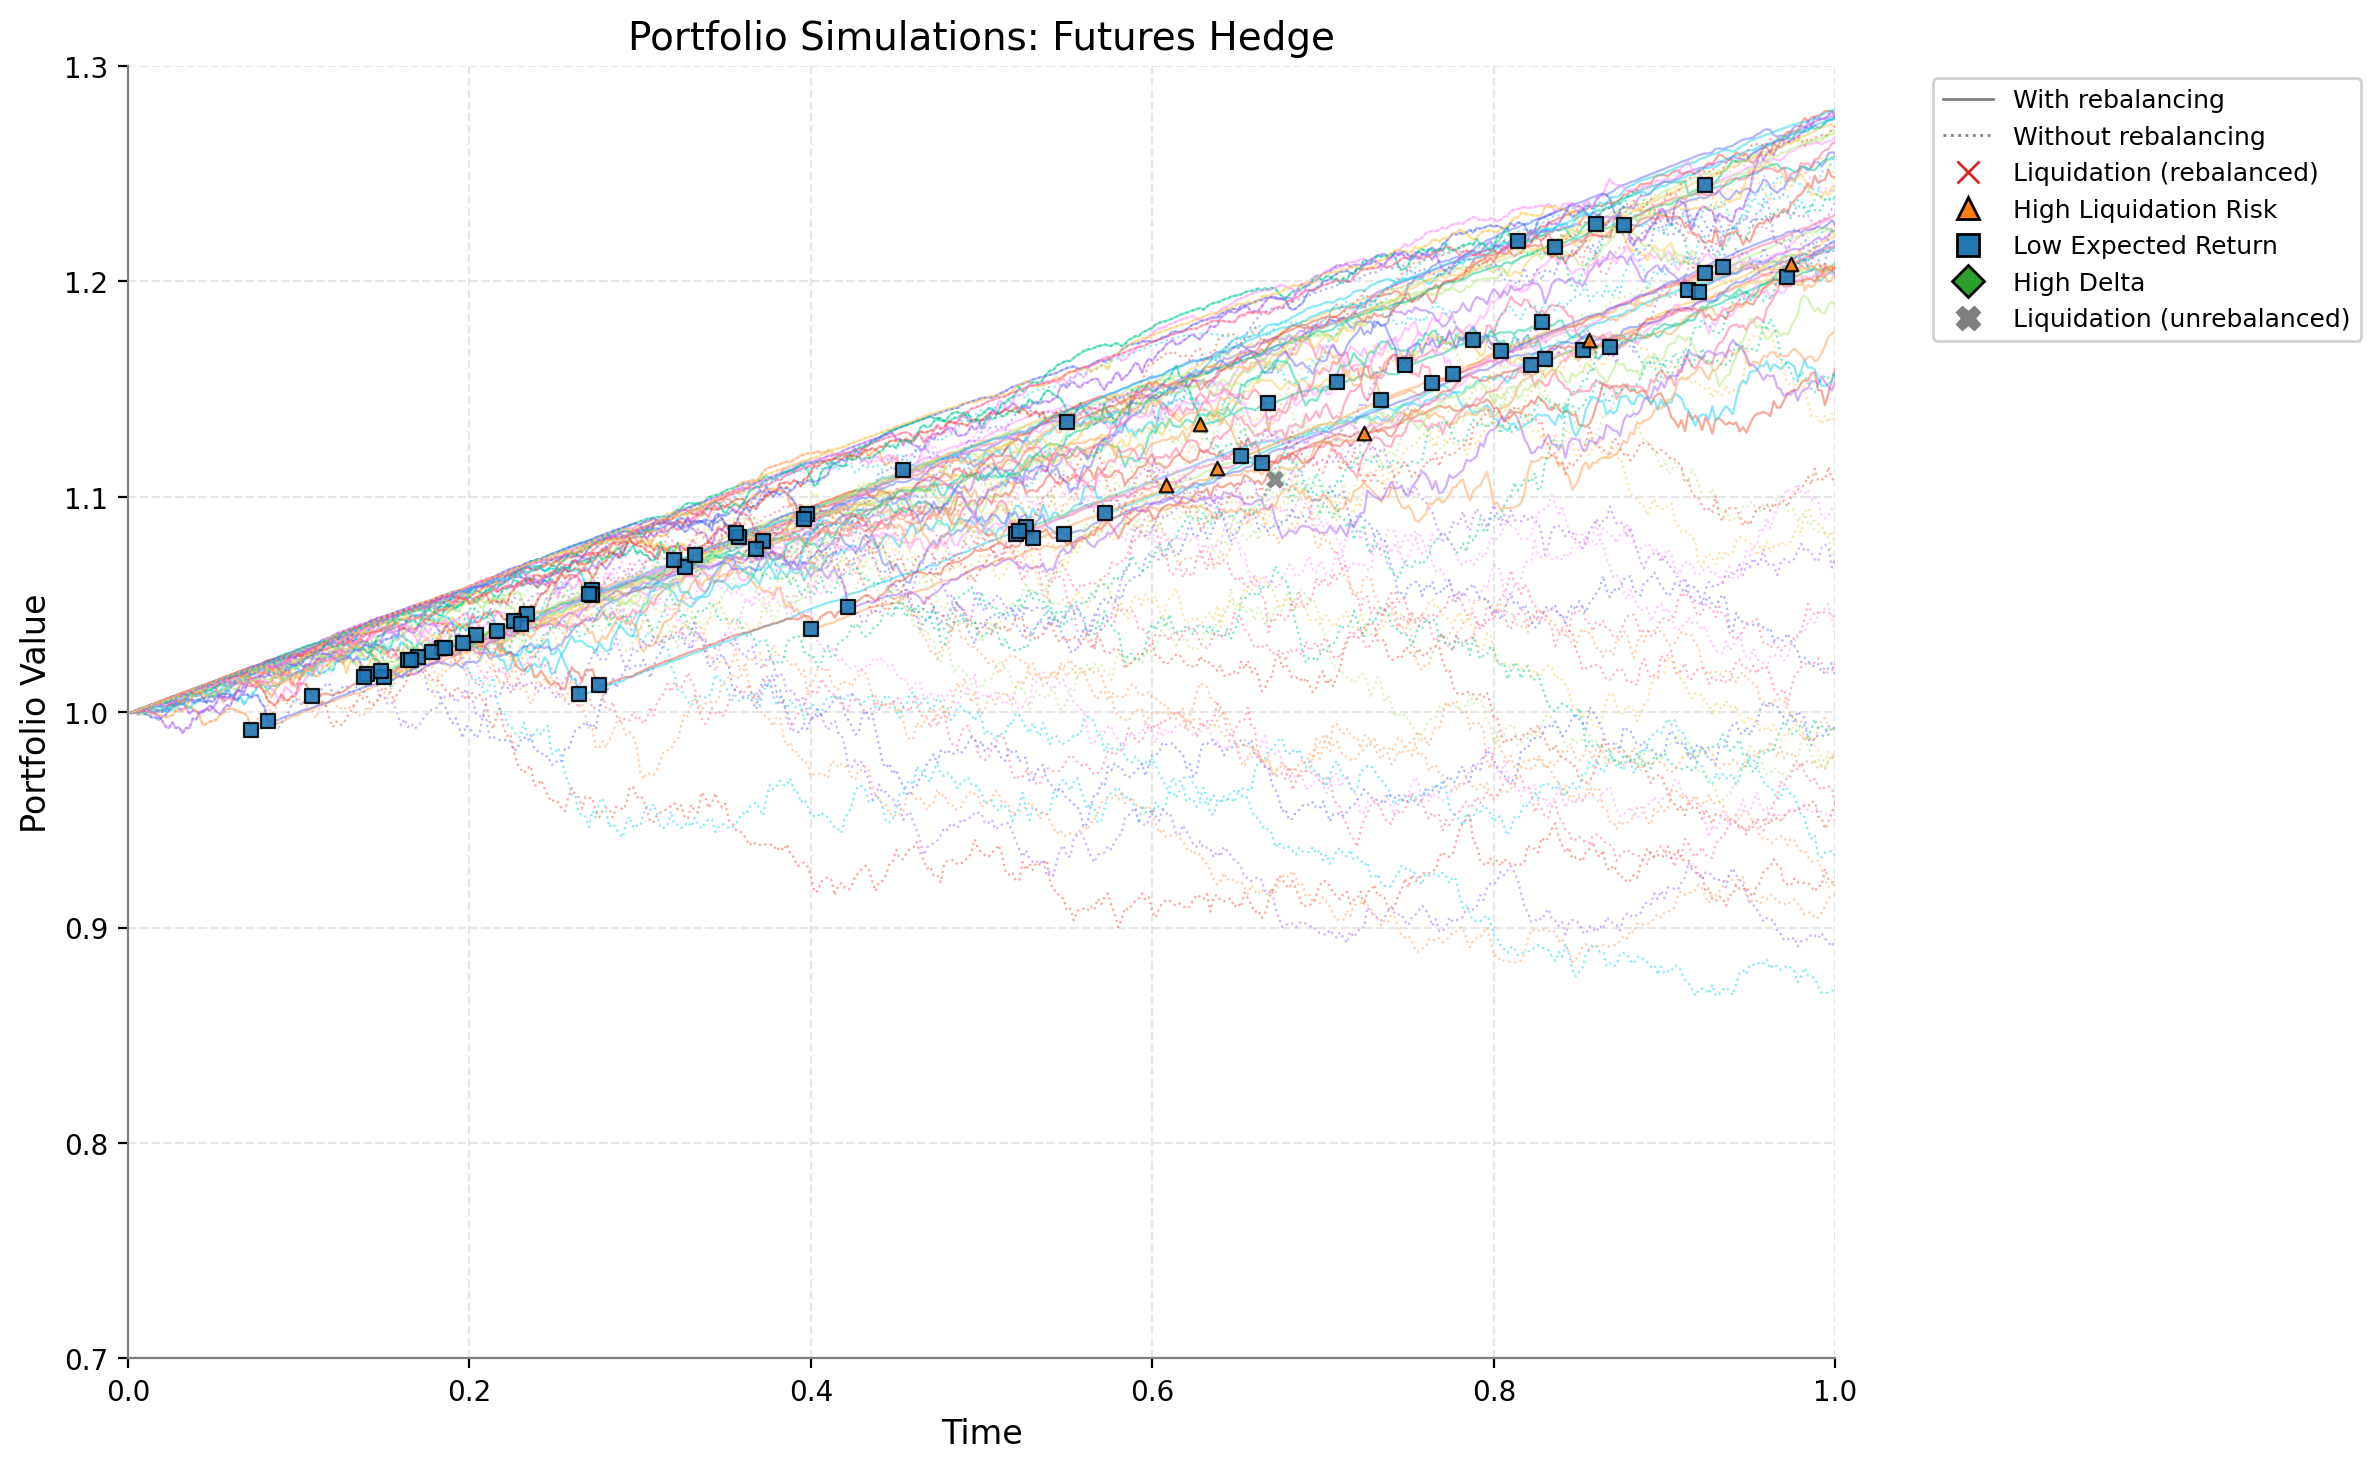

In [166]:
%config InlineBackend.figure_format = 'retina'  # Оптимизация разрешения

fig = visualize_portfolio_simulations_matplotlib(
    time_grid=simulations.time_grid,
    portfolio_rebalanced=simulations.fh_portfolio_history,
    portfolio_unrebalanced=simulations.fh_portfolio_history_wr,
    portfolio_points=simulations.portfolio_points,
    figsize=(14, 7),
    show_strategies=['futures_hedge']
)

fig.show()

Mean with rebalance: 1.1750
Std with rebalance: 0.1875
Mean without rebalance: 1.0391
Std without rebalance: 0.1969


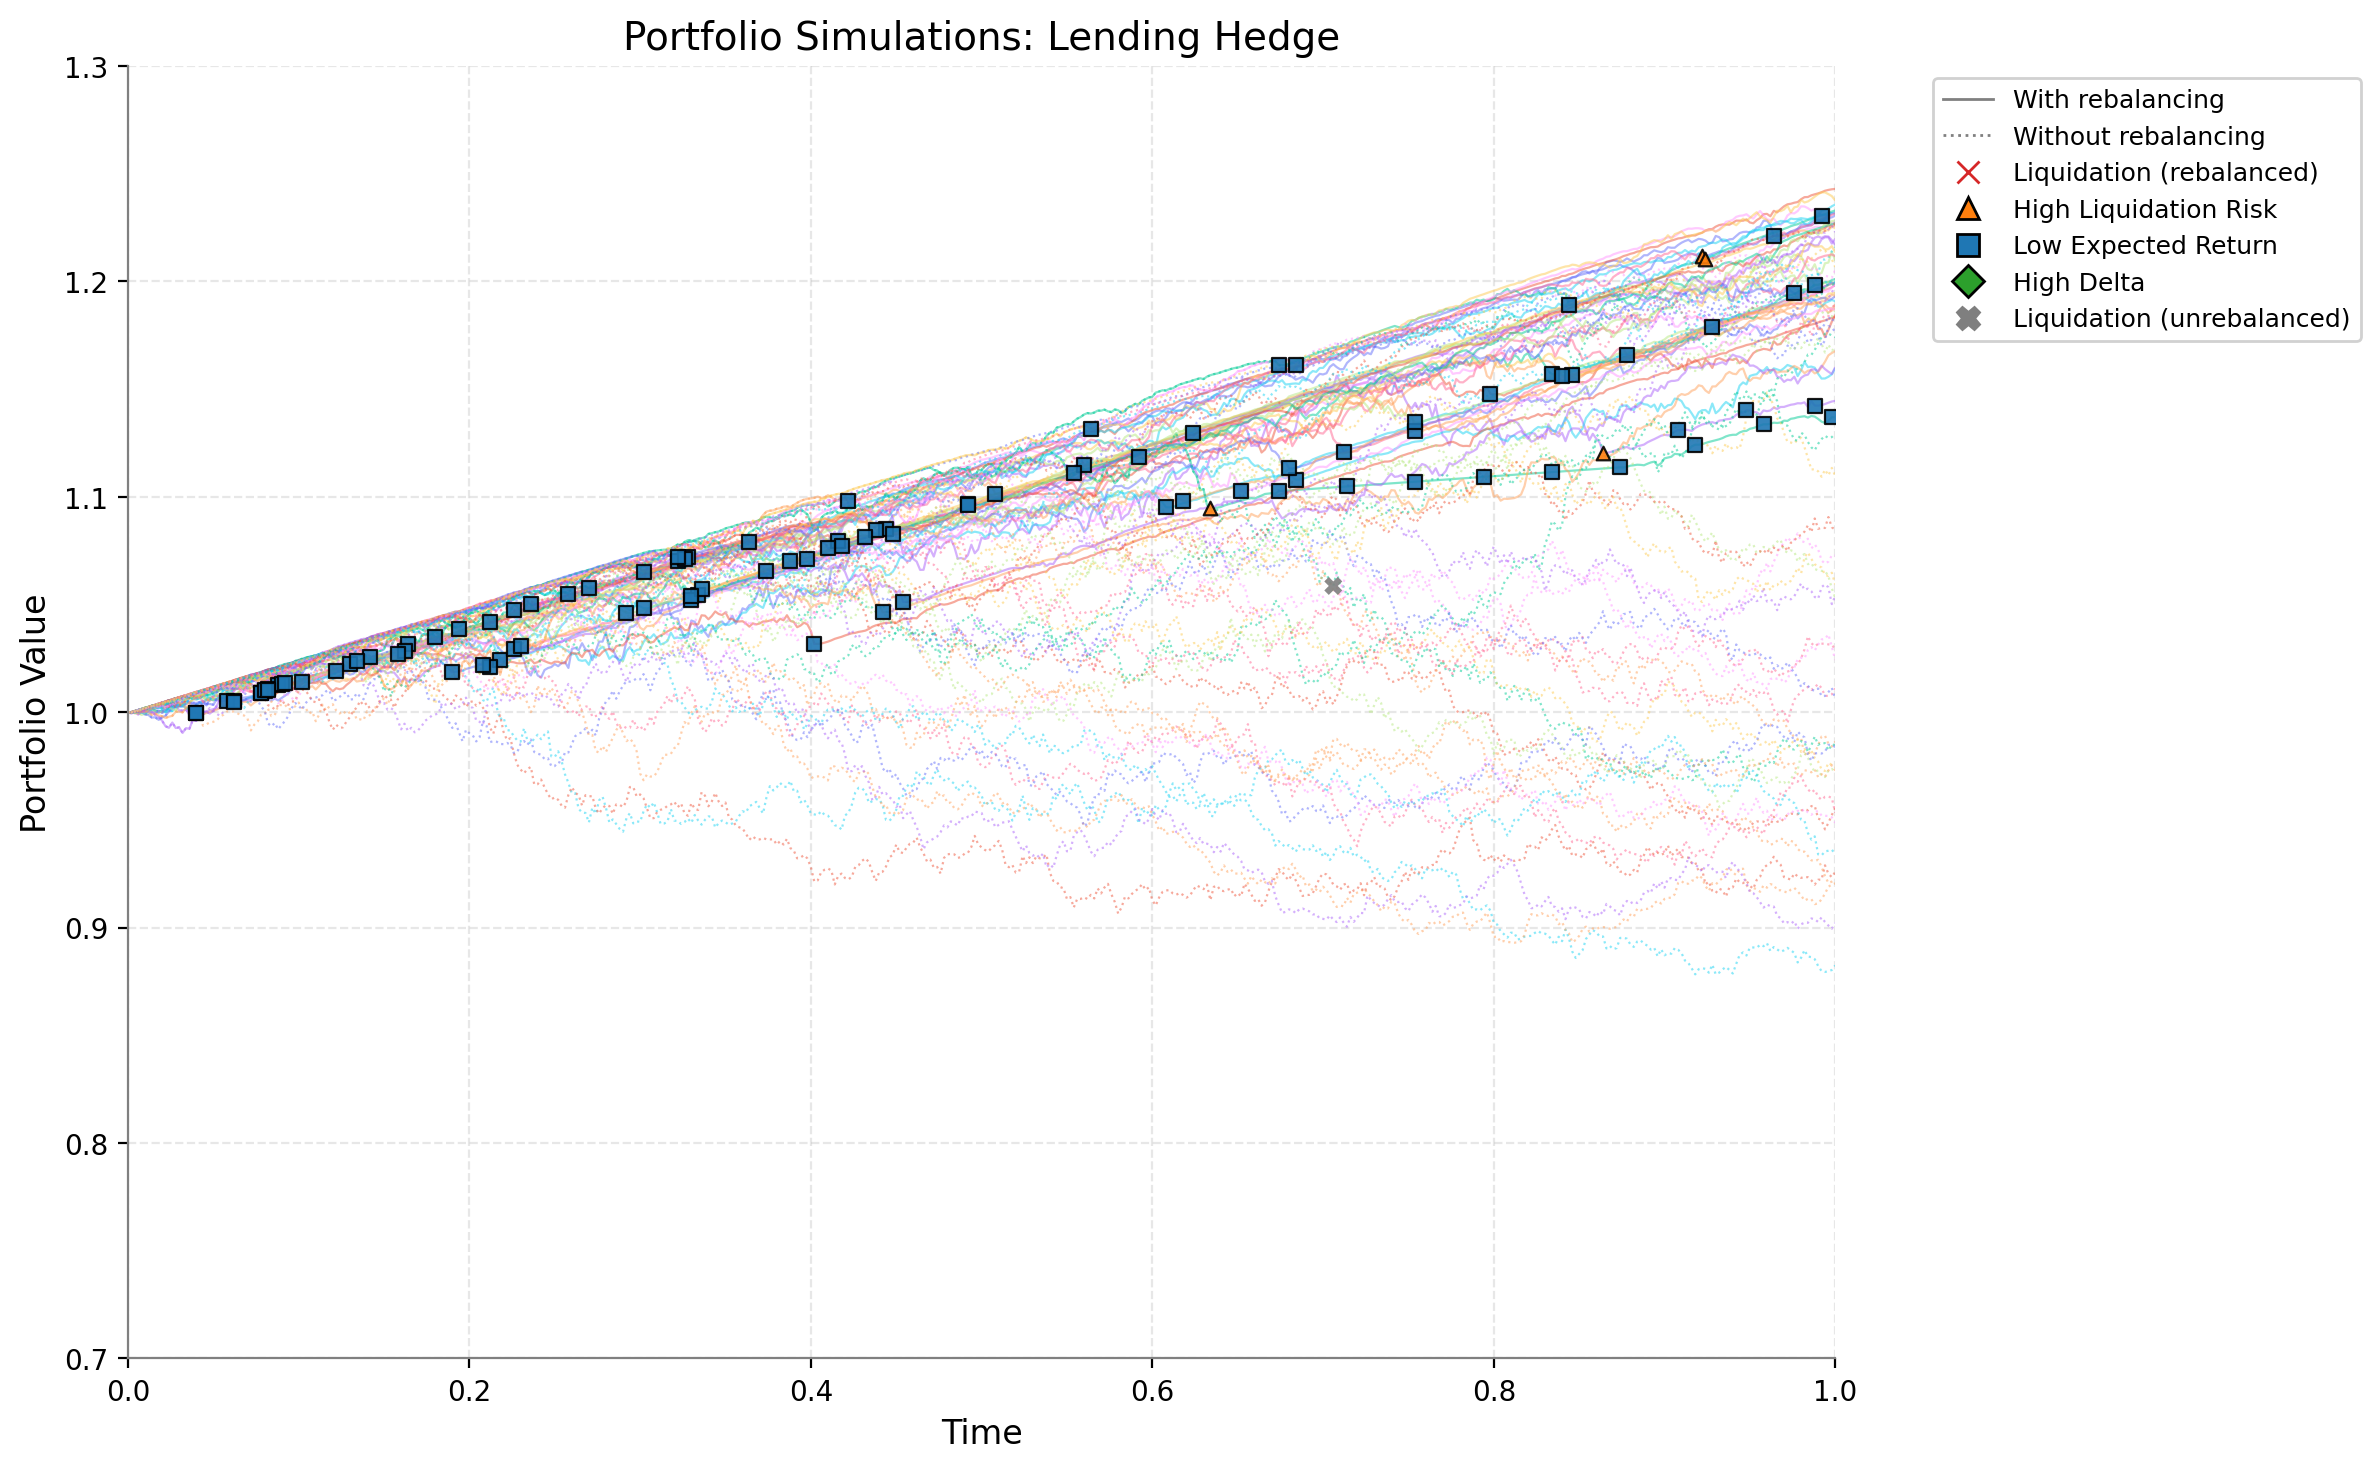

In [167]:
fig = visualize_portfolio_simulations_matplotlib(
    time_grid=simulations.time_grid,
    portfolio_rebalanced=simulations.lh_portfolio_history,
    portfolio_unrebalanced=simulations.lh_portfolio_history_wr,
    portfolio_points=simulations.portfolio_points,
    figsize=(14, 7),
    show_strategies=['lending_hedge']
)

fig.show()

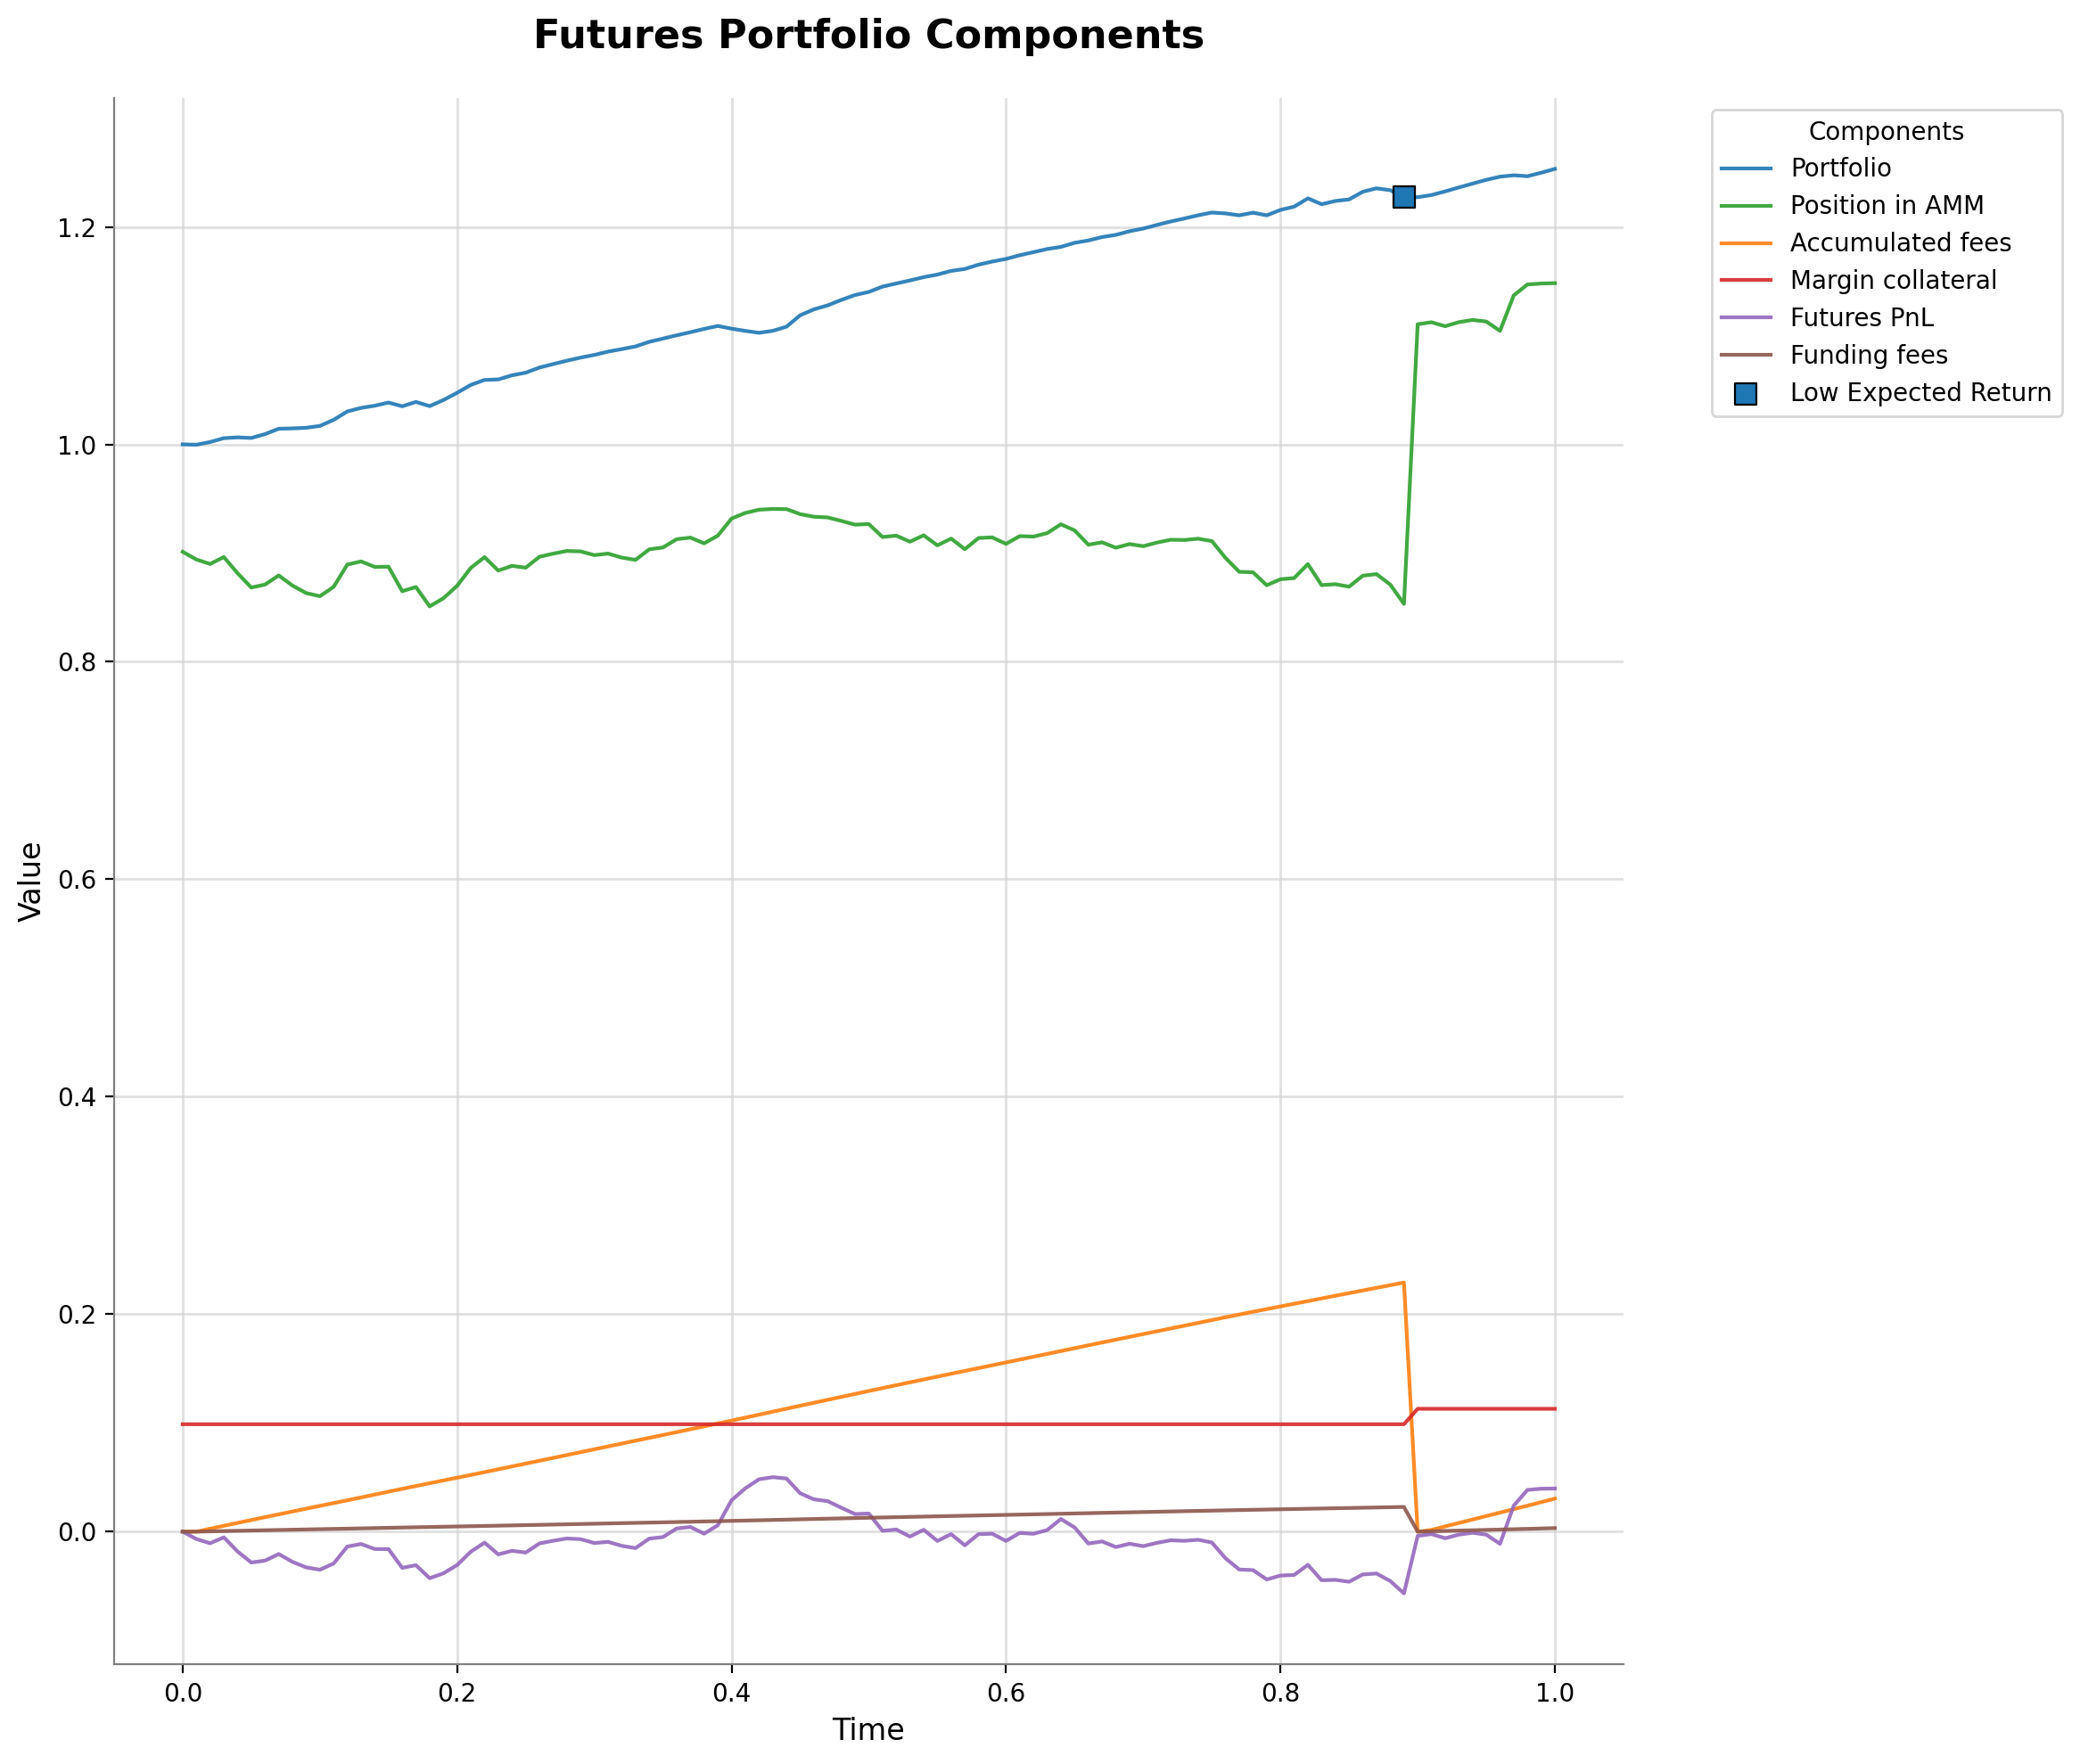

In [168]:
#Futures hedged portfolio split visualisation
fig = visualize_portfolio_components(
    time_grid=lp.time_grid,
    portfolio_total=lp.fh_portfolio_history[0],
    portfolio_points=lp.portfolio_points,
    strategy_name='futures_hedge',
    amm_position=(lp.fh_portfolio_history[0] - lp.fh_AMM_fees_history[0]) * (1 - lp.MBP_history[0]),
    fees_accumulated=lp.fh_AMM_fees_history[0],
    margin_collateral=lp.margin_collateral_history[0],
    futures_pnl=lp.futures_position_history[0],
    funding_fees=lp.funding_fees_history[0],
)

fig.show()

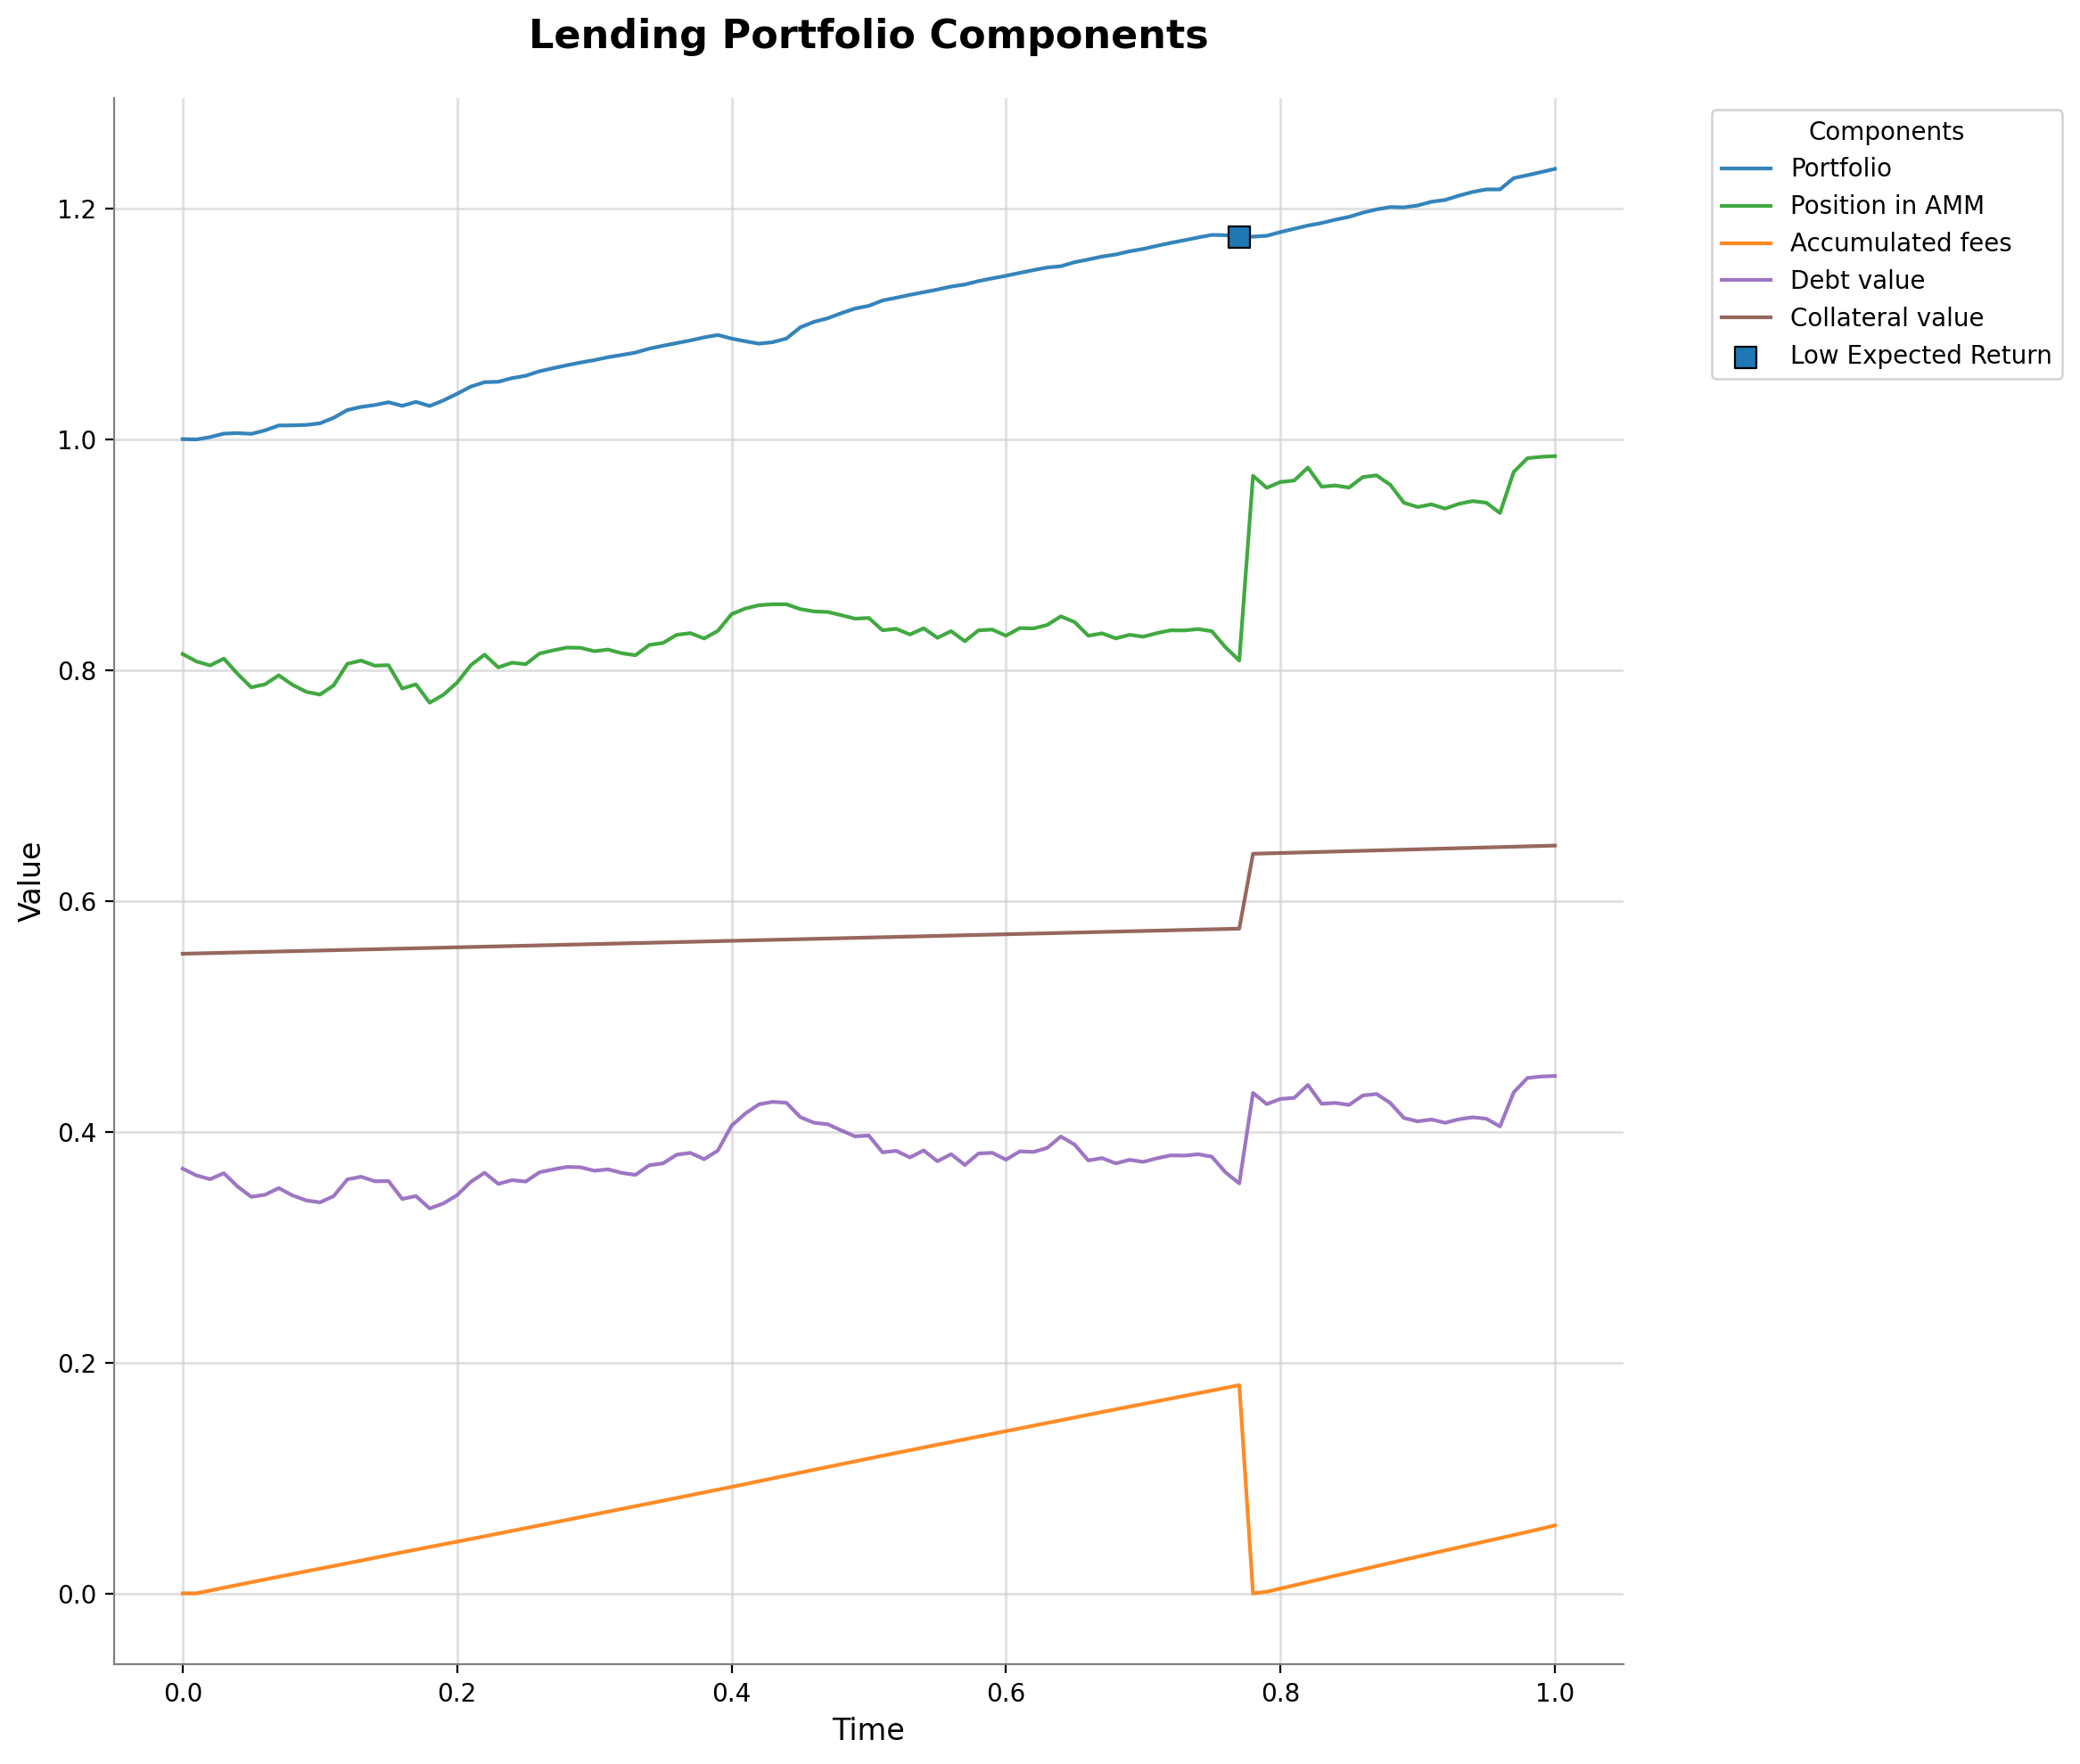

In [169]:
#Lending hedged portfolio split visualisation
fig = visualize_portfolio_components(
    time_grid=lp.time_grid,
    portfolio_total=lp.lh_portfolio_history[0],
    portfolio_points=lp.portfolio_points,
    strategy_name='lending_hedge',
    amm_position=(lp.lh_portfolio_history[0] - lp.lh_AMM_fees_history[0]) * (1 - lp.LHP_history[0]),
    fees_accumulated=lp.lh_AMM_fees_history[0],
    debt_value=lp.debt_history[0],
    collateral_value=lp.collateral_history[0]
)

fig.show()

In [170]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.graph_objects as go

def simple_visualize_amm_hedge(time_grid, amm, hedge):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=time_grid, y=amm, mode='lines', name='AMM позиция'))
    fig.add_trace(go.Scatter(x=time_grid, y=hedge, mode='lines', name='Хедж позиция'))

    fig.update_layout(title="AMM и Хедж позиции")
    fig.show()

amm = -((lp.lh_portfolio_history[0] - lp.lh_AMM_fees_history[0]) * (1 - lp.LHP_history[0]) - (lp.lh_portfolio_history[0][0] - lp.lh_AMM_fees_history[0][0]) * (1 - lp.LHP_history[0][0]))
hedge = (lp.lh_portfolio_history[0] - lp.lh_AMM_fees_history[0]) * lp.LHP_history[0] - (lp.lh_portfolio_history[0][0] - lp.lh_AMM_fees_history[0][0]) * lp.LHP_history[0][0]

simple_visualize_amm_hedge(
lp.time_grid,
amm,
hedge
)

#Grid search


In [ ]:
import numpy as np
from itertools import product
import time

class PortfolioOptimizer:
    def __init__(self):
        self.results = []

    def grid_search(self, n_steps=2, top_n=5):
        grid = {
            'x': np.linspace(0, 1, 30),
            'p_a': np.linspace(2000, 2980, n_steps),
            'p_b': np.linspace(3020, 4000, n_steps),
            'b': np.linspace(0.1, 0.3, 2),
            'u': np.linspace(-0.4, 0.4, 4),
            's': np.linspace(0.05, 0.5, 5),
            'r_cd': np.linspace(0.01, 0.05, 2),
            'r_be': np.linspace(0.01, 0.07, 2),
            'theta': np.linspace(0.85, 1.0, 1),
        }

        valid_pairs = [(pa, pb) for pa in grid['p_a'] for pb in grid['p_b'] if pa < pb]
        if not valid_pairs:
            print("Нет допустимых комбинаций p_a и p_b!")
            return

        # Правильный расчет комбинаций
        num_p0 = n_steps  # шаги для p_0
        other_params = 30 * 2 * 4 * 5 * 2 * 2 * 1  # x, b, u, s, r_cd, r_be, theta
        total_combs = len(valid_pairs) * num_p0 * other_params

        print(f"Всего комбинаций для перебора: {total_combs:,}\n")

        start_time = time.time()
        processed = 0
        report_step = max(1, total_combs // 100)  # Каждый 1%

        # Основной цикл вычислений
        for p_a, p_b in valid_pairs:
            for p_0 in np.linspace(p_a, p_b, n_steps):
                for params in product(
                    grid['x'],
                    grid['b'],
                    grid['u'],
                    grid['s'],
                    grid['r_cd'],
                    grid['r_be'],
                    grid['theta']
                ):
                    x, b, u, s, r_cd, r_be, theta = params

                    try:
                        value = lp.lh_portfolio_mean(
                            x=x, p_0=p_0, p_a=p_a, p_b=p_b,
                            b=b, v=0.1, t=1, u=u, s=s,
                            r_cd=r_cd, r_be=r_be, theta=theta, D=1
                        )
                        self.results.append((value, {
                            'x': x,
                            'p_a': p_a,
                            'p_b': p_b,
                            'p_0': p_0,
                            'b': b,
                            'u': u,
                            's': s,
                            'r_cd': r_cd,
                            'r_be': r_be,
                            'theta': theta
                        }))
                    except Exception as e:
                        print(f"Ошибка при вычислении: {e}")
                        continue

                    # Обновление прогресса
                    processed += 1
                    if processed % report_step == 0:
                        elapsed = time.time() - start_time
                        progress = processed / total_combs
                        remaining = elapsed / progress * (1 - progress) if progress > 0 else 0

                        print(f"Прогресс: {progress:.1%} | "
                              f"Затрачено: {elapsed:.1f} сек | "
                              f"Осталось: {remaining:.1f} сек | "
                              f"Обработано: {processed:,}/{total_combs:,}")

        # Вывод результатов
        total_time = time.time() - start_time
        print(f"\nПолное время выполнения: {total_time:.1f} сек")

        self.results.sort(reverse=True, key=lambda x: x[0])
        print(f"\nТоп {top_n} результатов:")
        for i, (val, params) in enumerate(self.results[:top_n]):
            print(f"\n#{i+1}: {val:.2f}")
            print("Параметры:")
            for k, v in params.items():
                print(f"  {k}: {v:.4f}")
            print("-" * 40)

In [ ]:
# Запуск оптимизации
optimizer = PortfolioOptimizer()
optimizer.grid_search(n_steps=10, top_n=5)

#Comparison of expected returns

##Bear market

In [ ]:
#Parameters

params = {
    'p_0': 3000,
    'p_a' : 2800,
    'p_b' : 3200,
    'b': 0.3,
    'l': 0.05,
    't': 1,
    'u': -0.3,
    's': 0.3,
    'kappa': 0.05,
    'iota': 0.01,
    'r_a': 0.05,
    'r_b': 0.0174,
    'r_cd': 0.03, #0.03 as default
    'r_be': 0.05,
    'theta': 0.9,
    'D': 1
    }

###Narrow price range low volatility

<ipython-input-96-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  1


<ipython-input-96-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) - 

Optimal LHP:  1


<ipython-input-96-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x) 

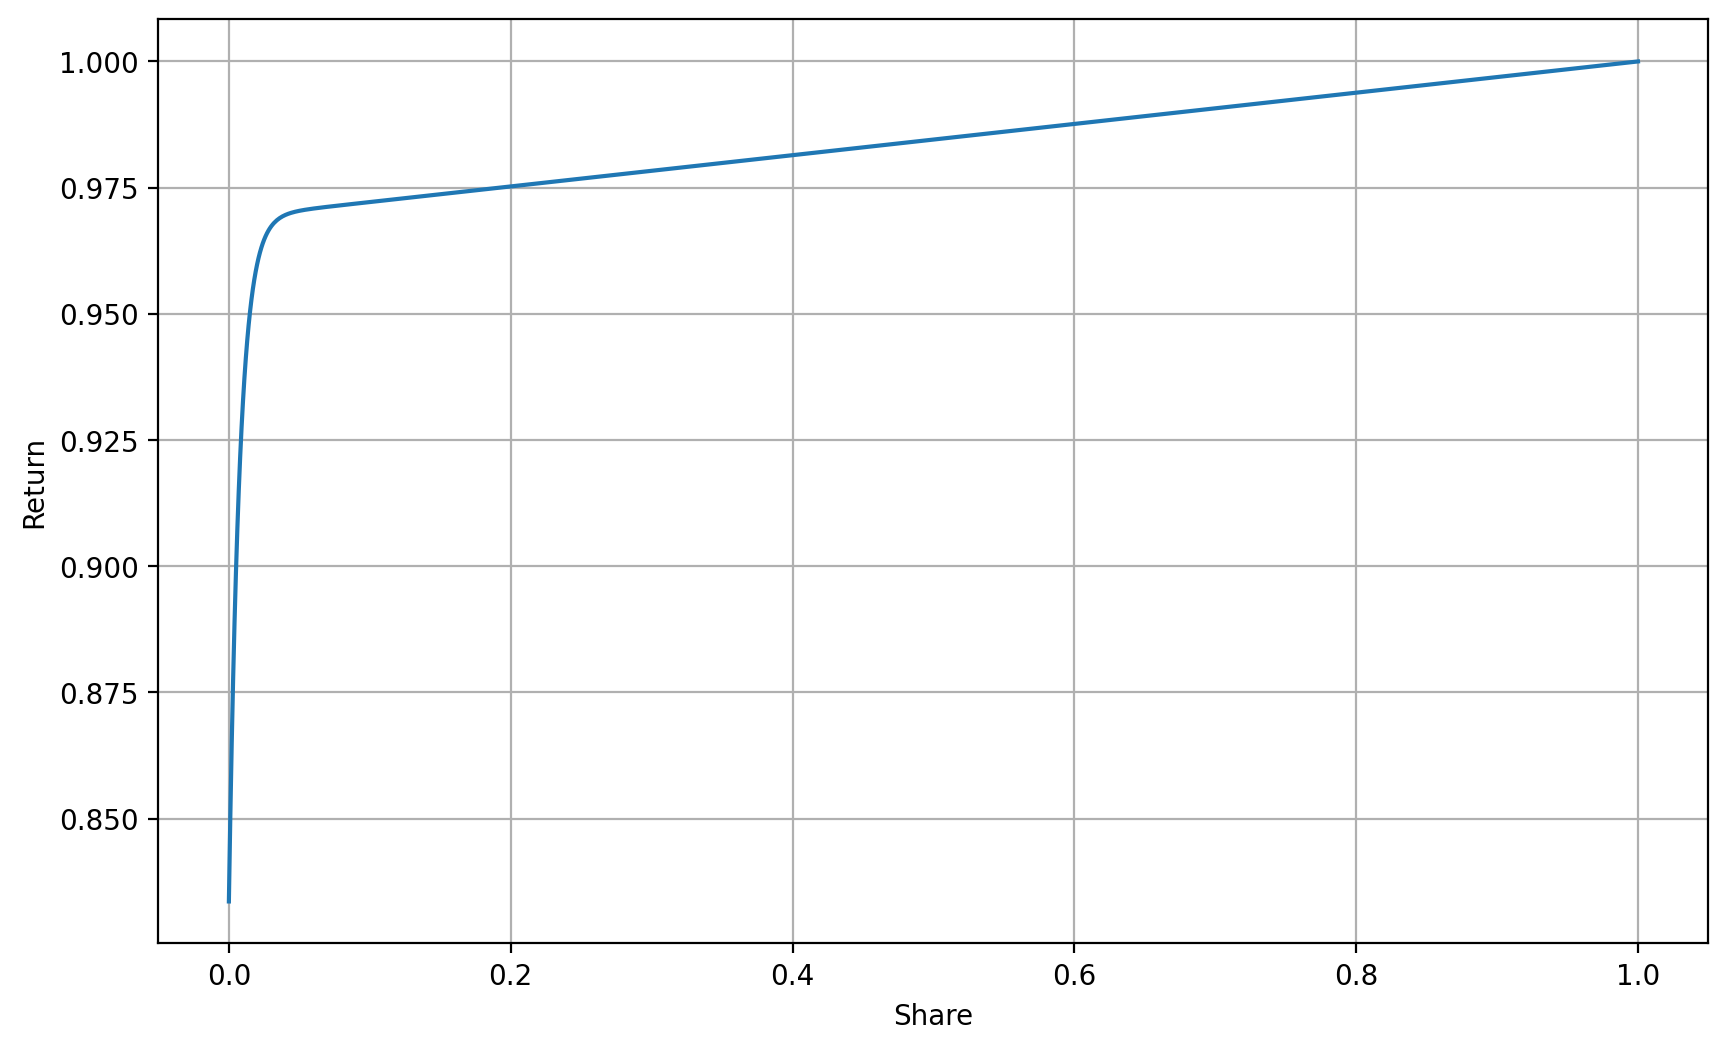

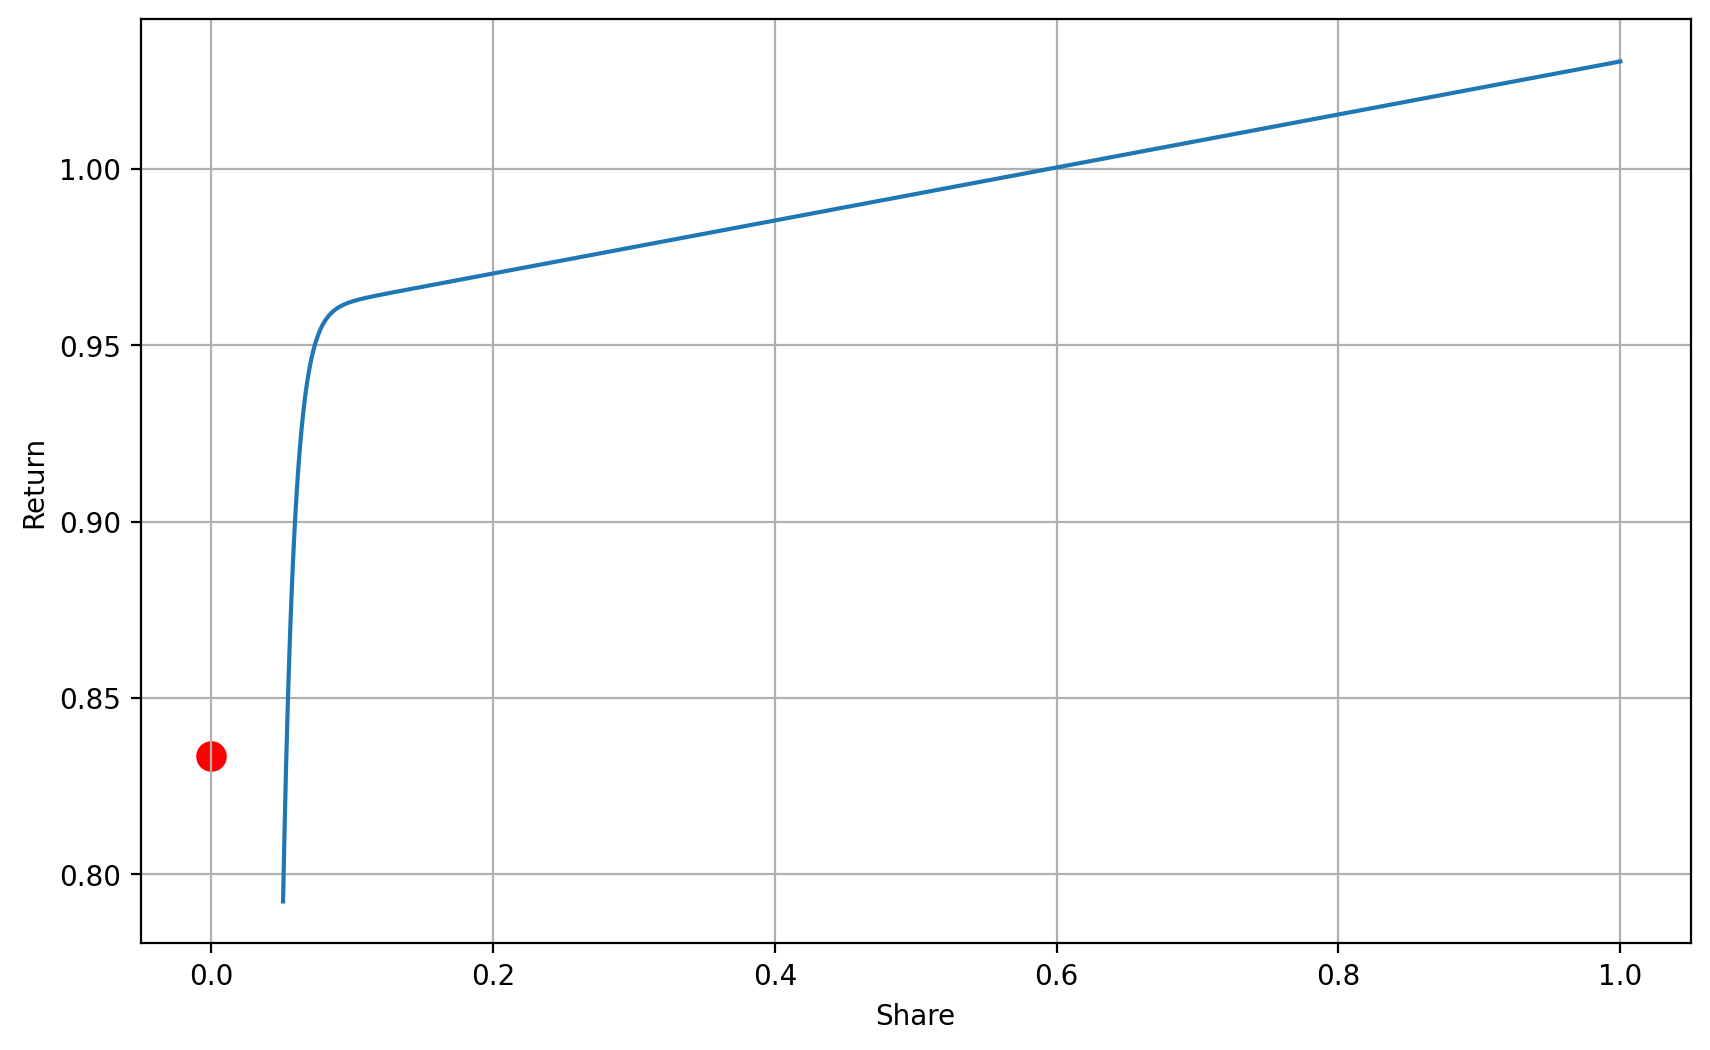

In [ ]:
lp.APY_MBP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.1, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.1,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Narrow price range average volatility

<ipython-input-96-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  1


<ipython-input-96-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) - 

Optimal LHP:  1


<ipython-input-96-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x) 

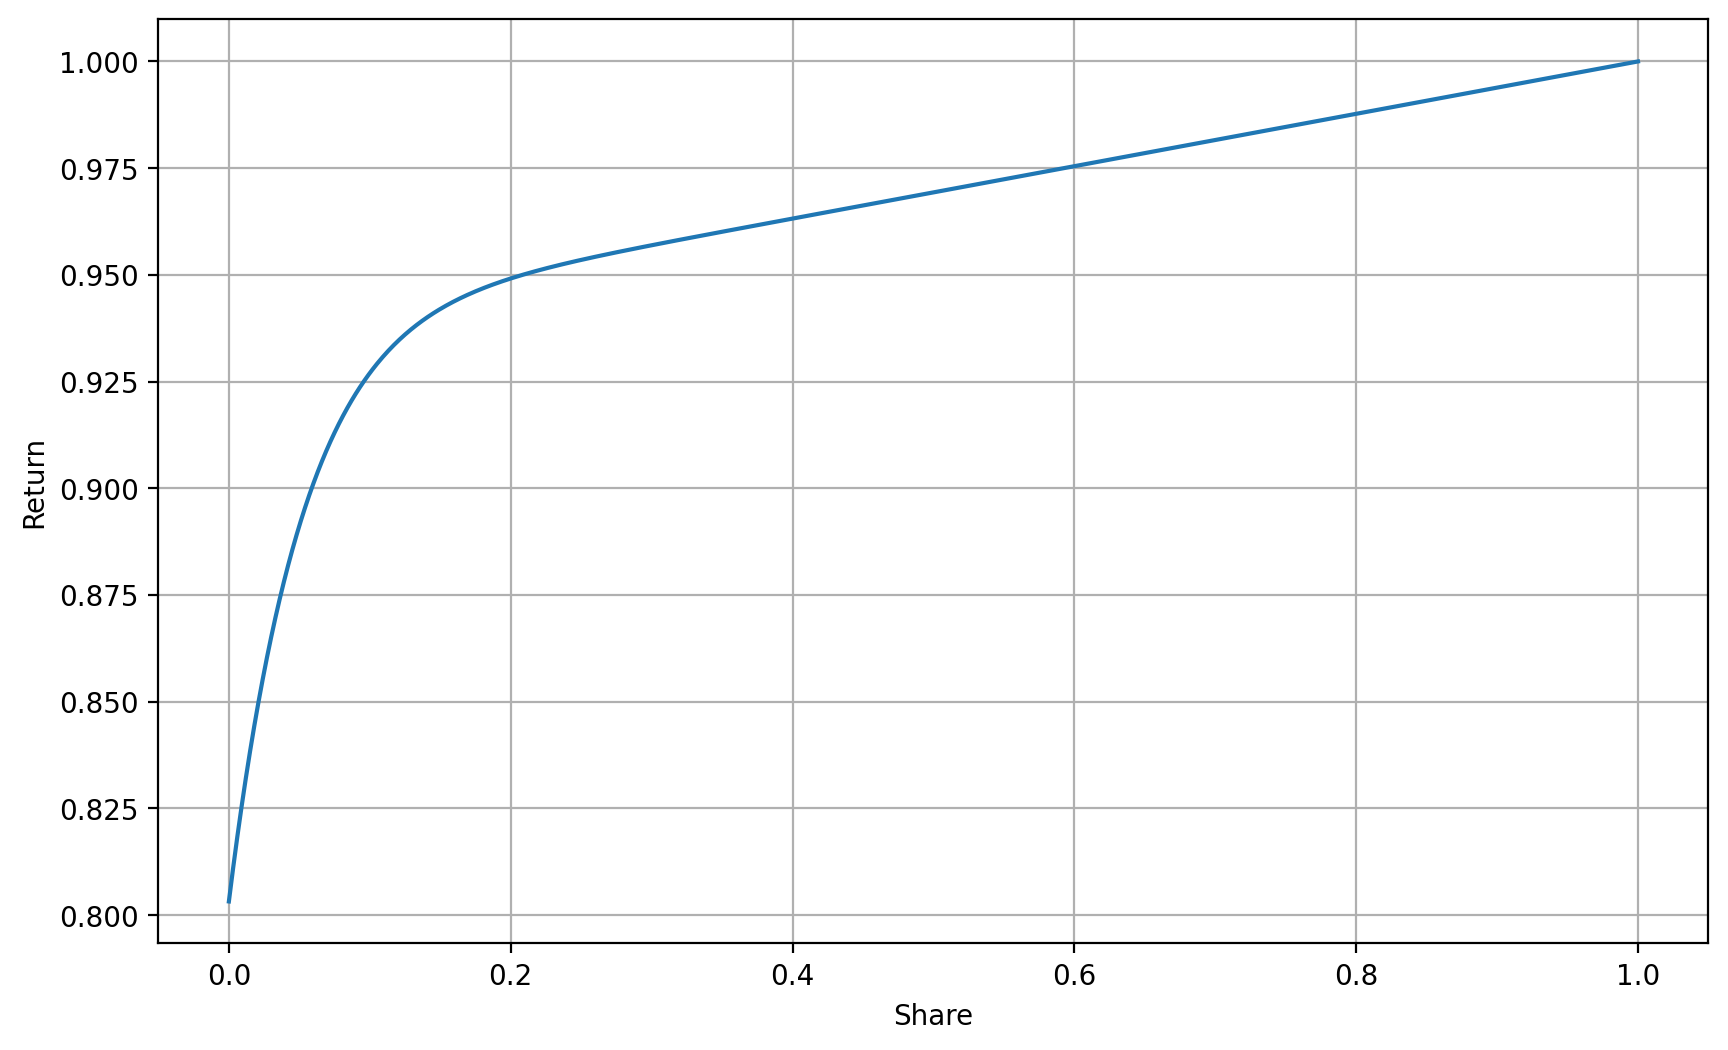

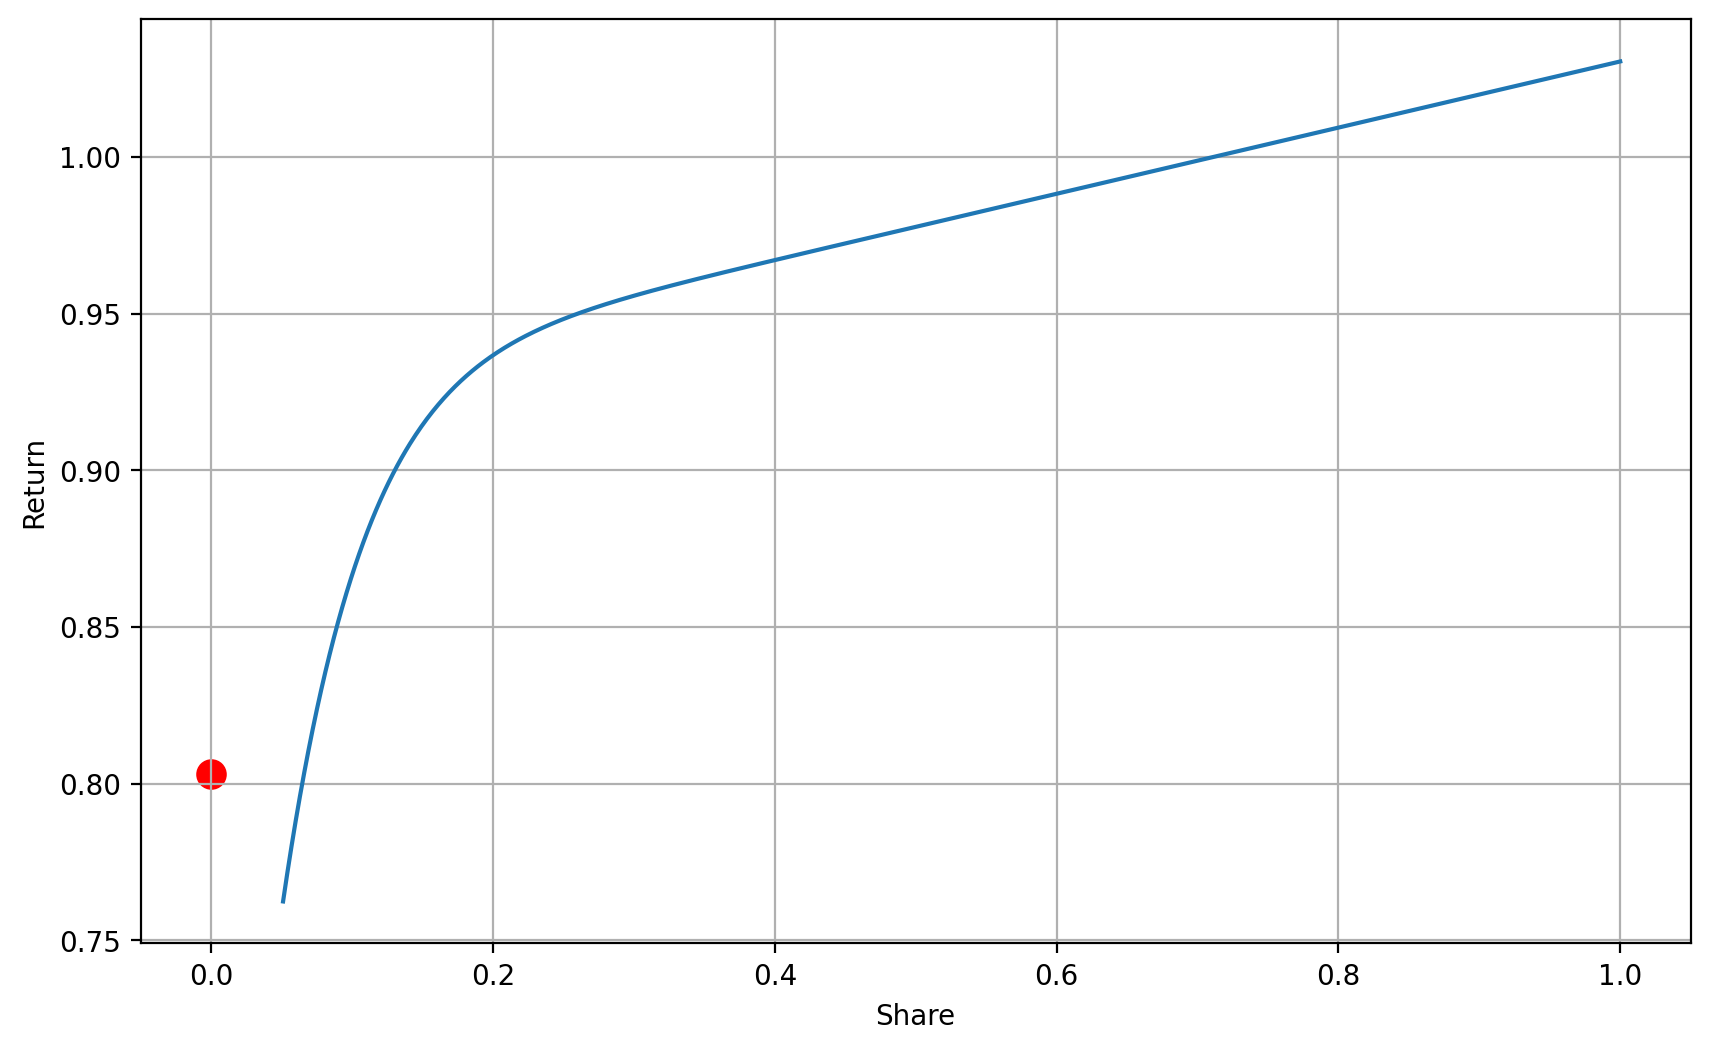

In [ ]:
lp.APY_MBP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], params['s'],params['r_cd'], params['r_be'], params['theta'], params['D'])

###Narrow price range, high volatility

<ipython-input-96-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  1


<ipython-input-96-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) - 

Optimal LHP:  1


<ipython-input-96-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x) 

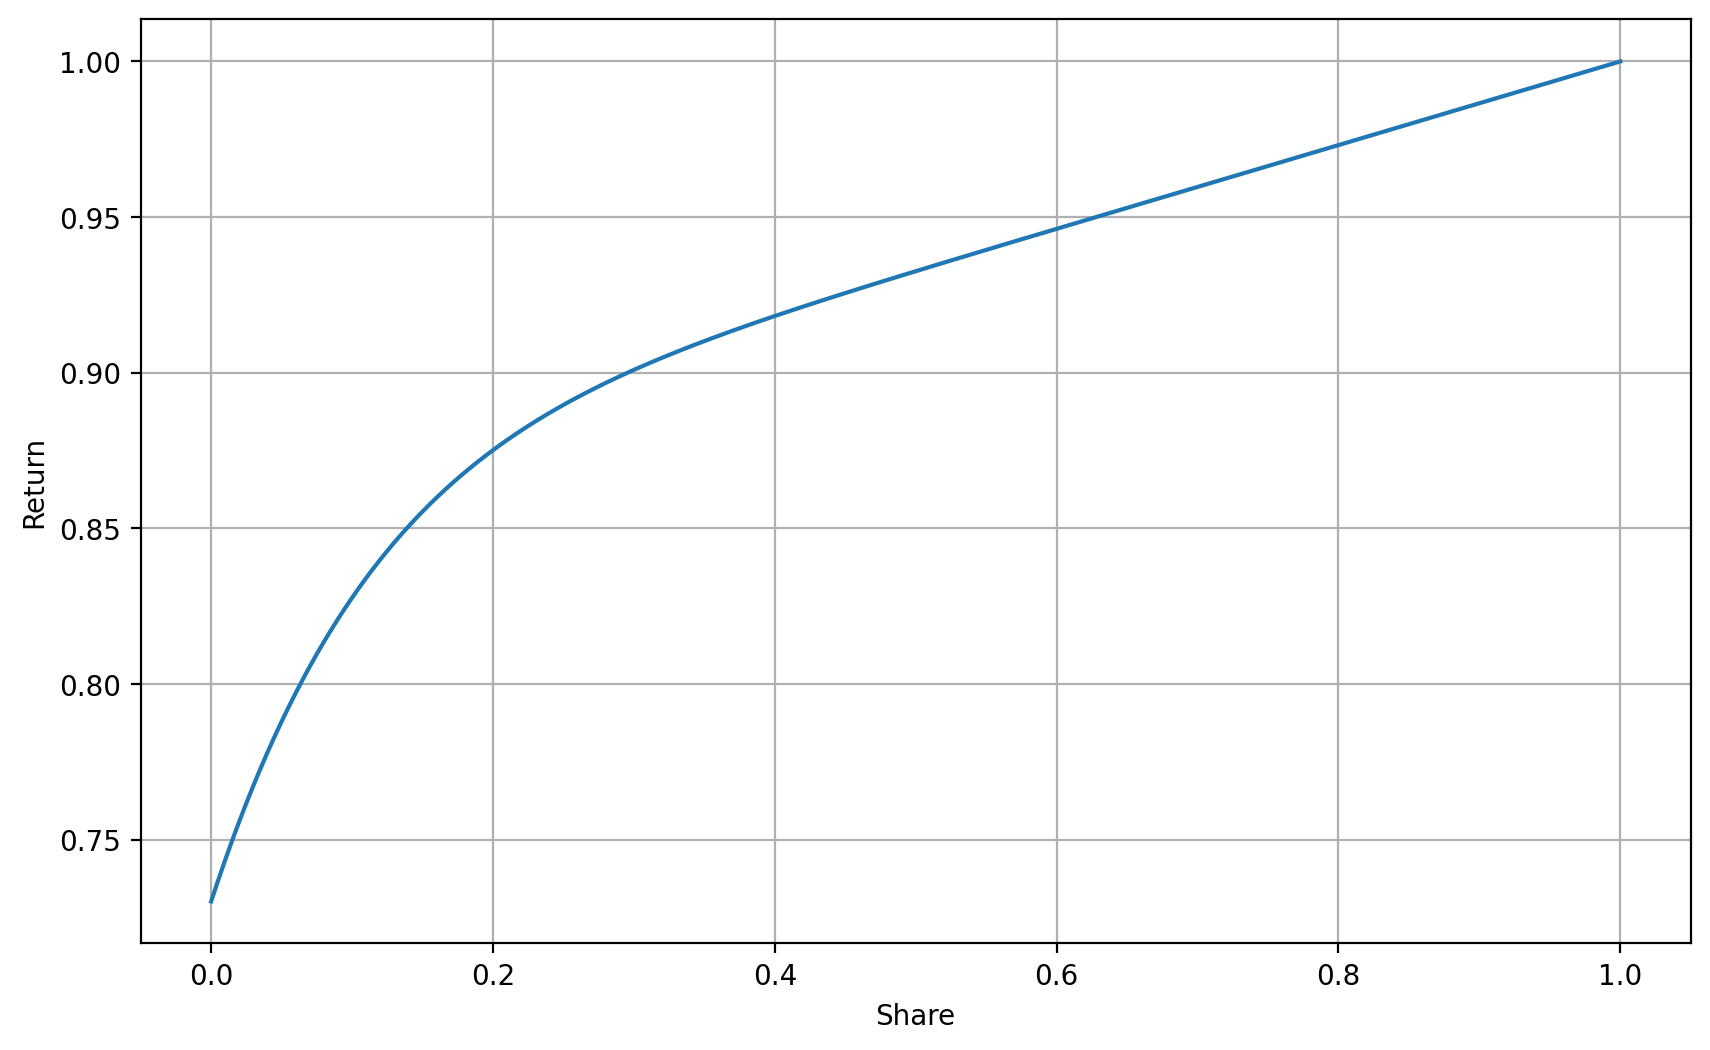

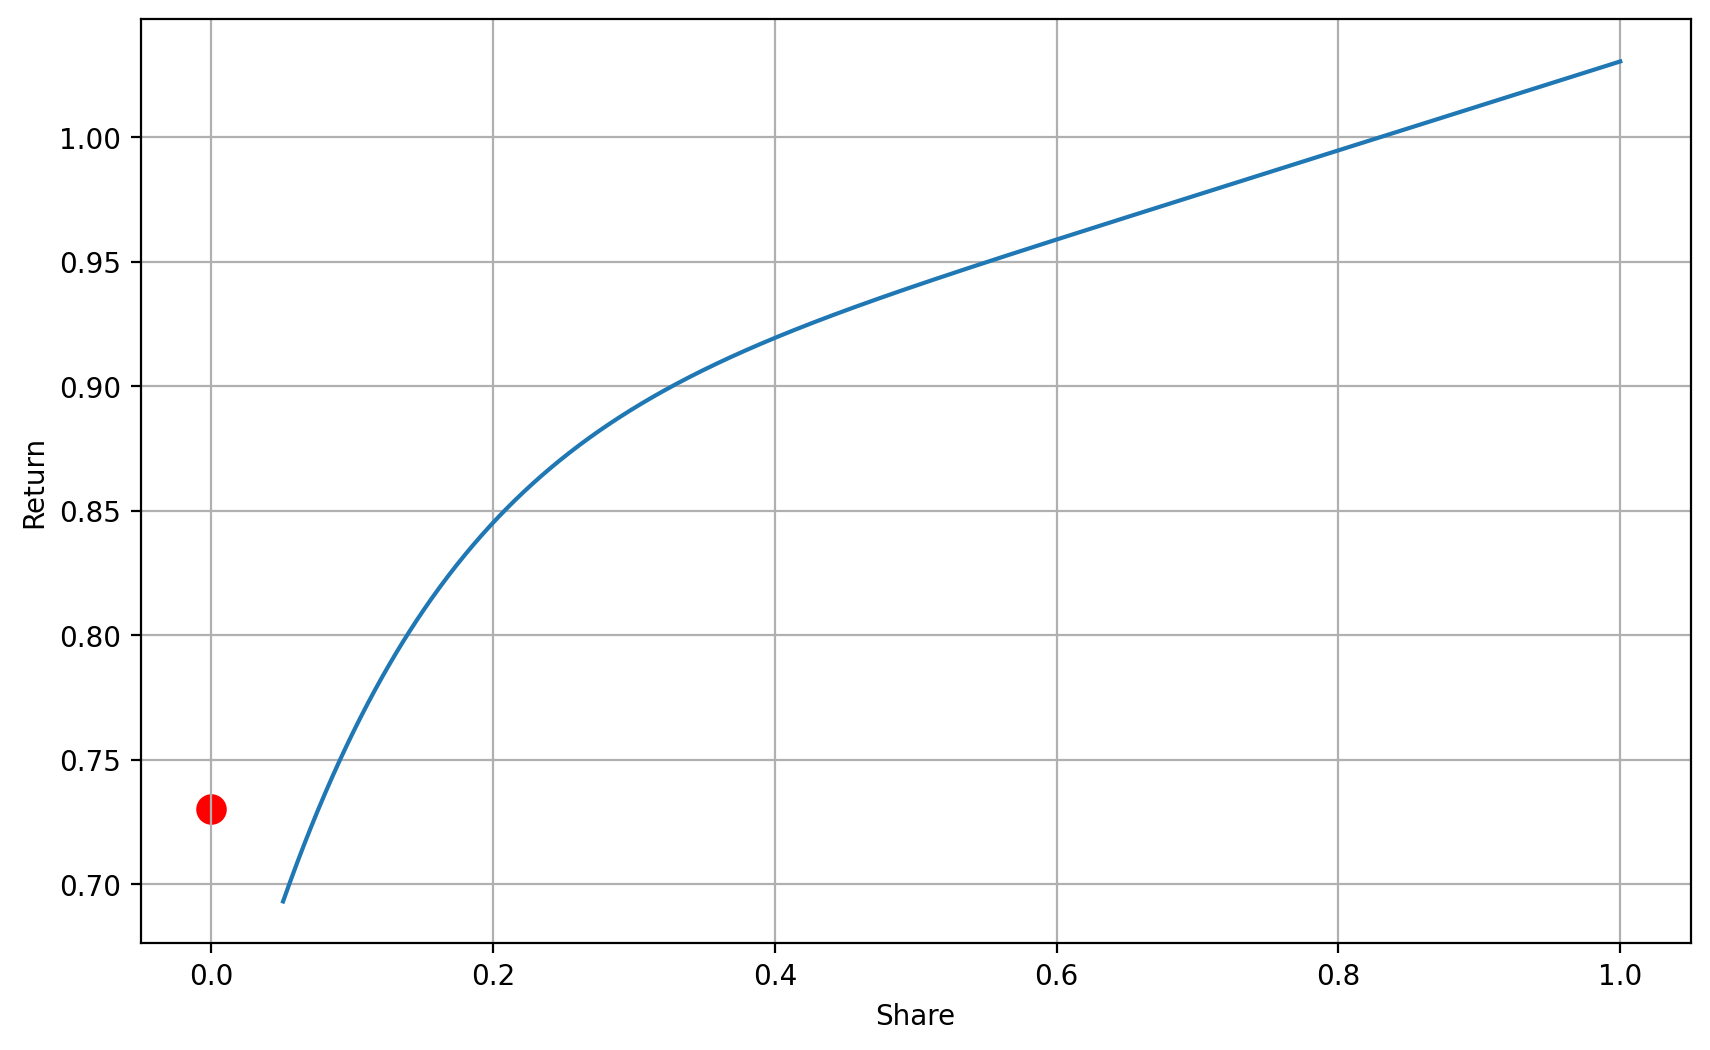

In [ ]:
lp.APY_MBP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.5, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.5,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Medium price range low volatility

<ipython-input-96-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0.03915733925685


<ipython-input-96-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) - 

Optimal LHP:  0.09799351289734645


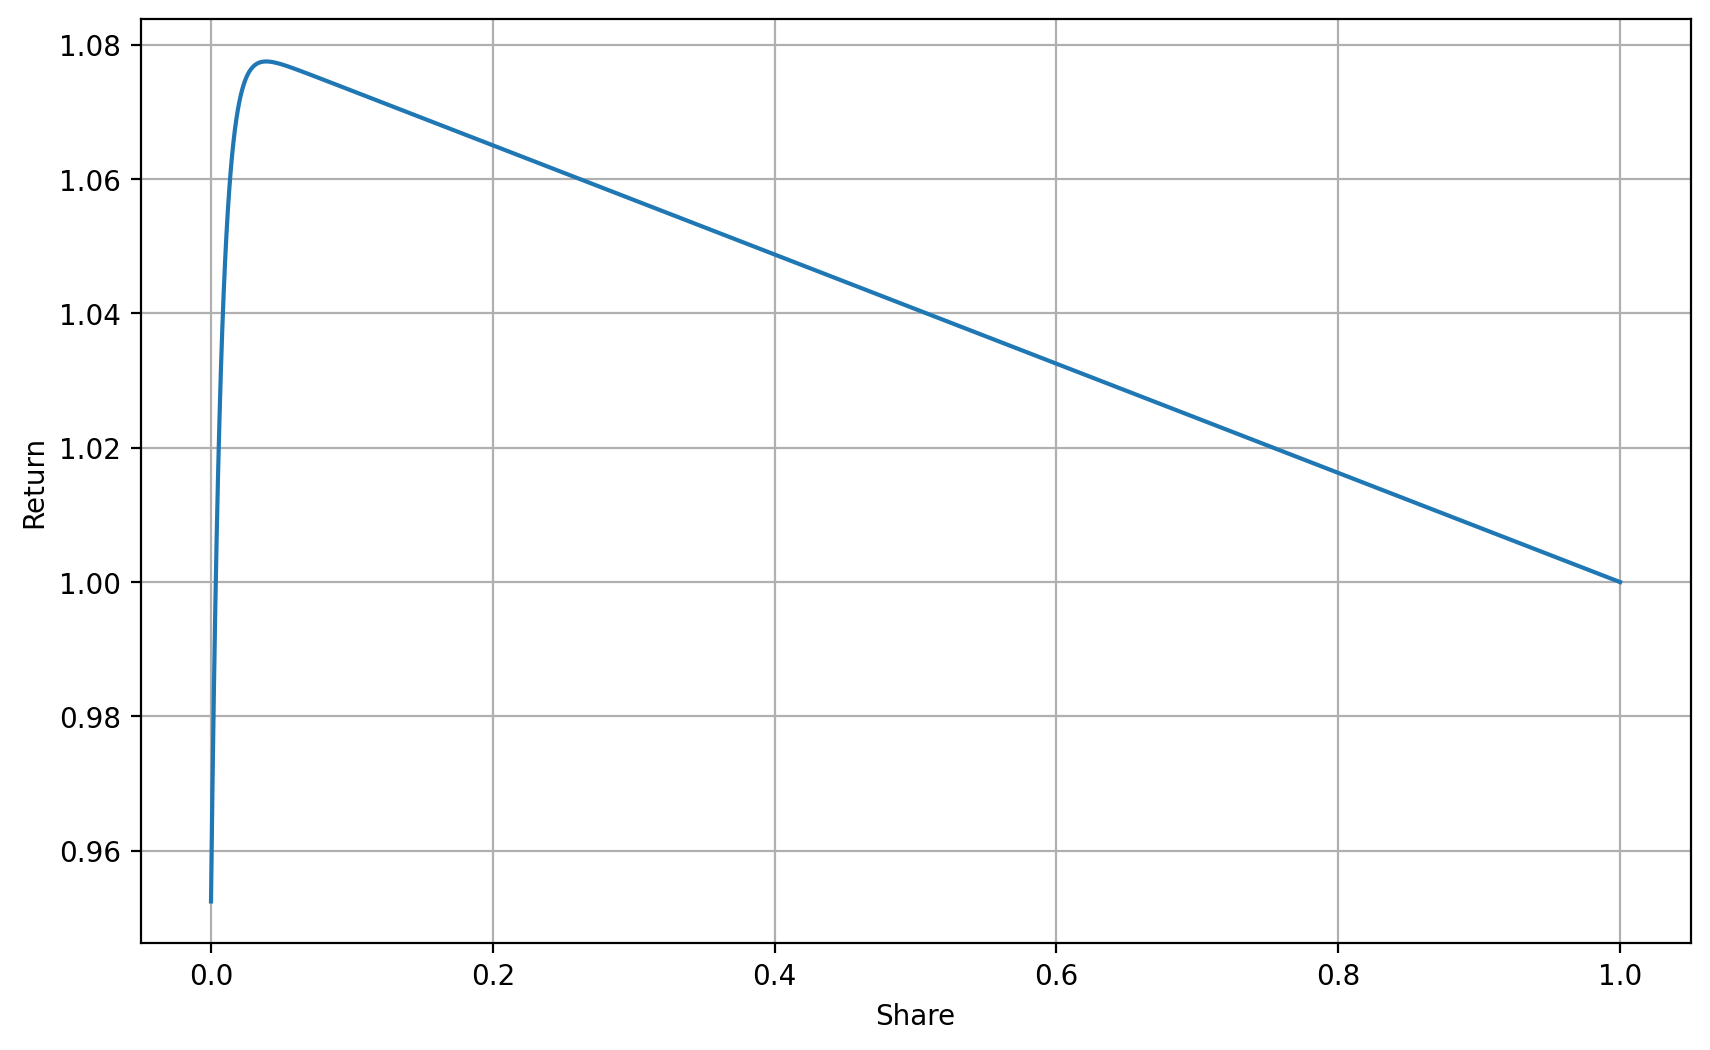

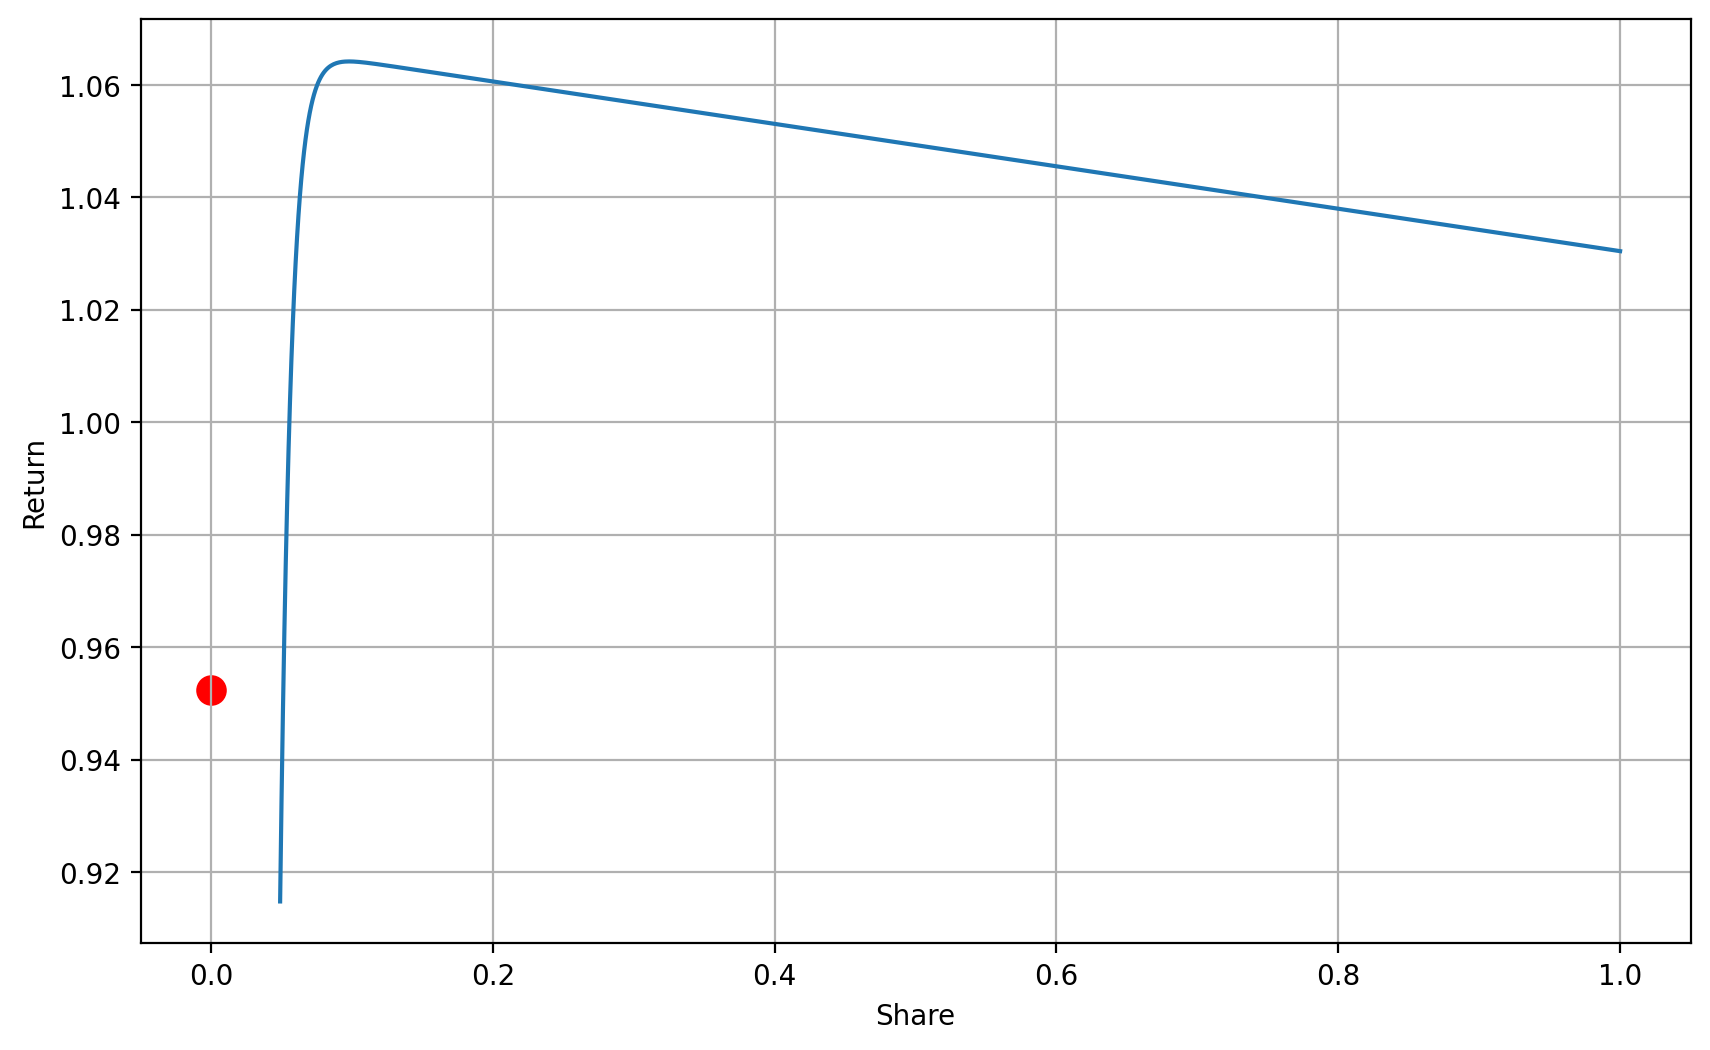

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.1, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.1,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Medium price range medium volatility

<ipython-input-96-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0.2093765449727356


<ipython-input-96-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) - 

Optimal LHP:  1


<ipython-input-96-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x) 

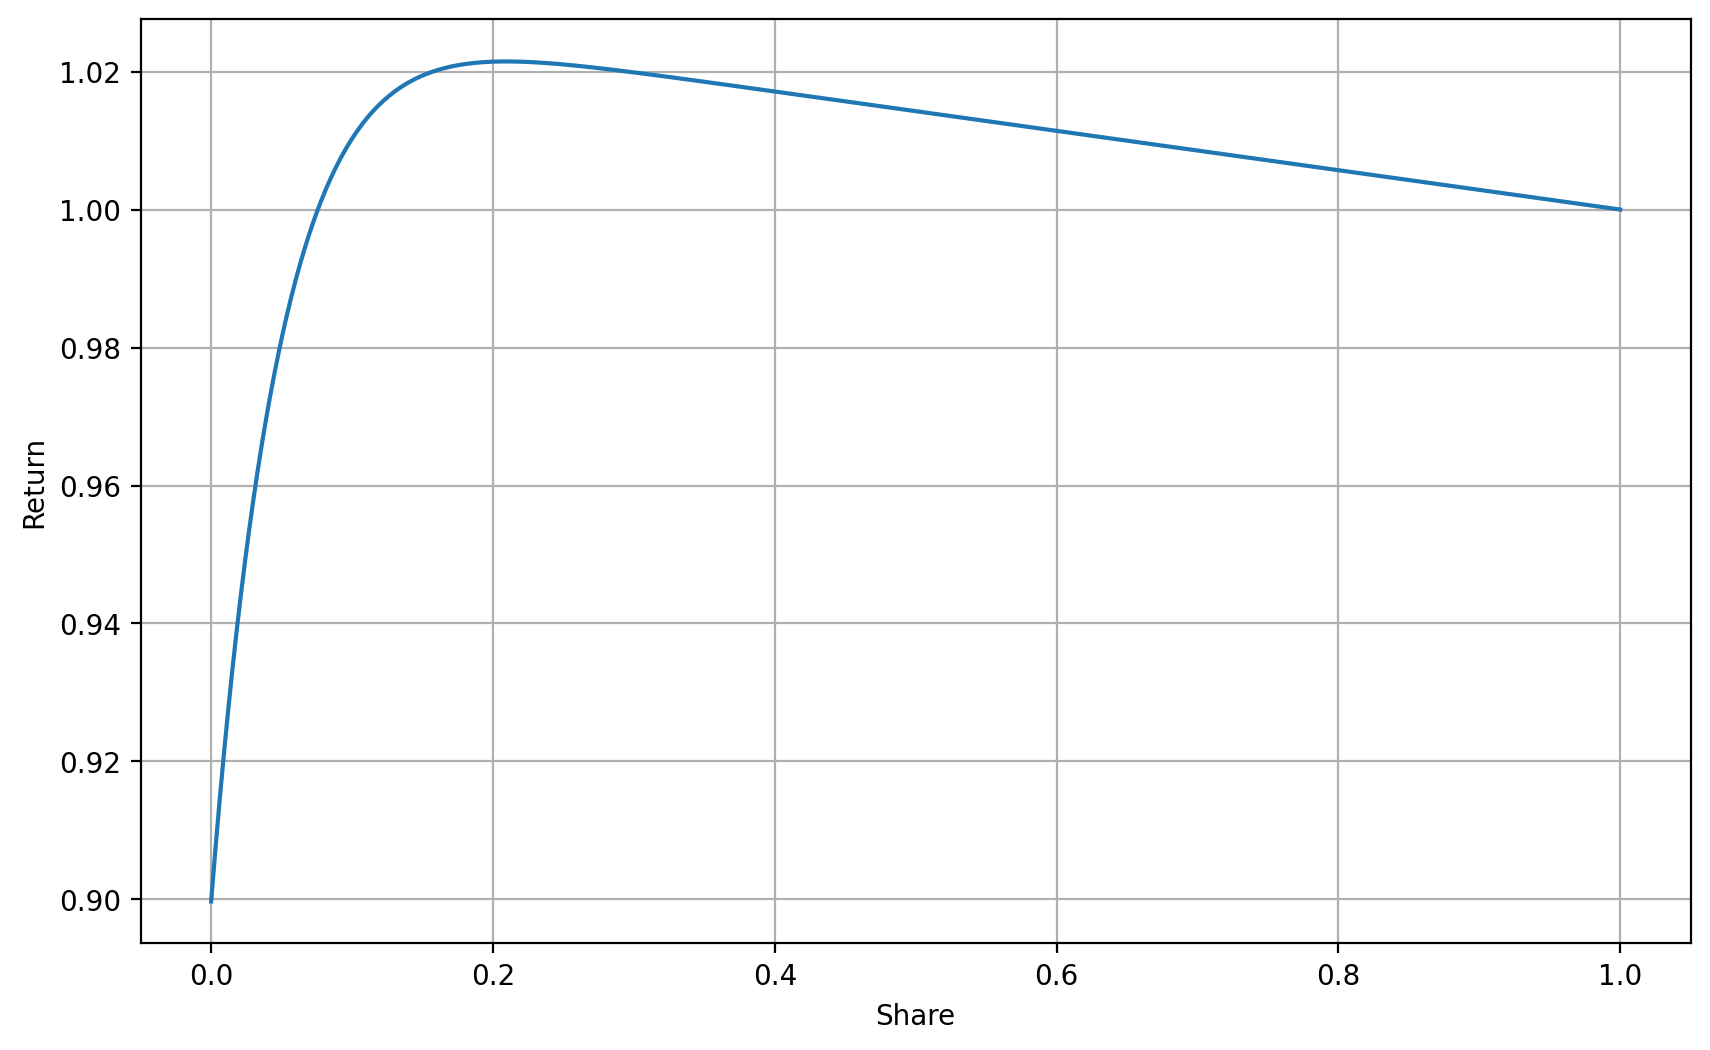

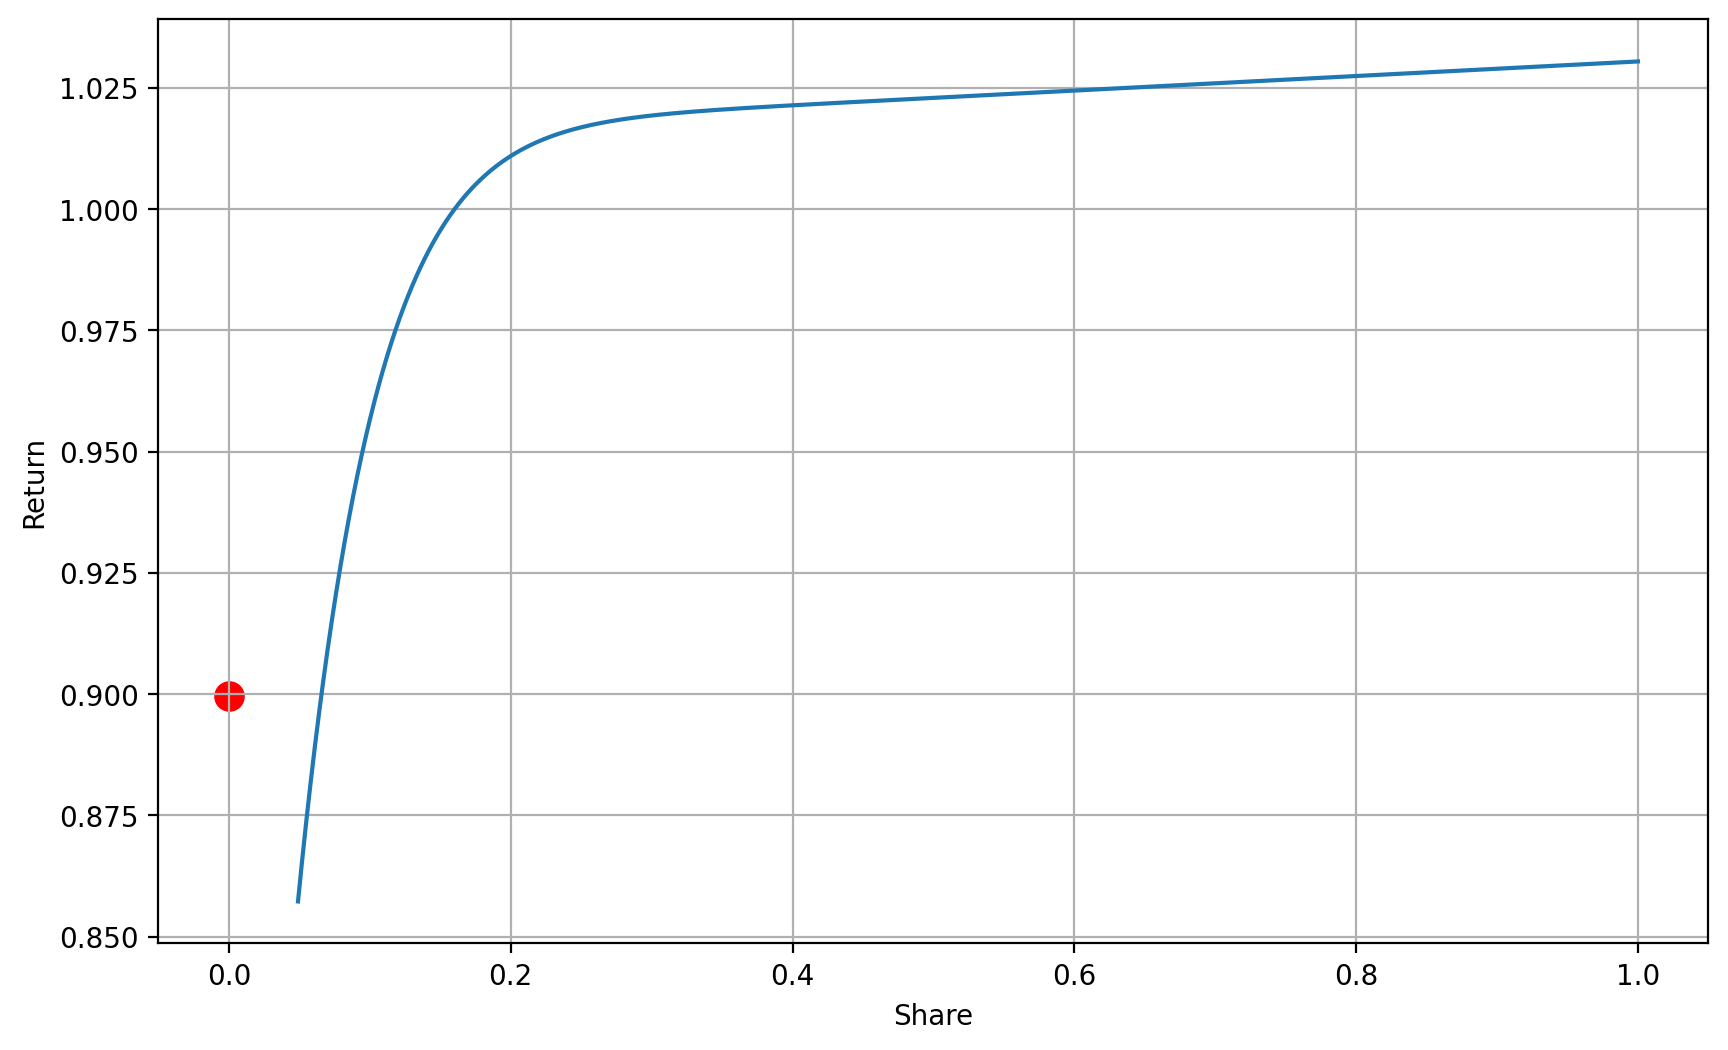

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], params['s'],params['r_cd'], params['r_be'], params['theta'], params['D'])

######Medium price range high volatility

<ipython-input-96-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  1


<ipython-input-96-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) - 

Optimal LHP:  1


<ipython-input-96-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x) 

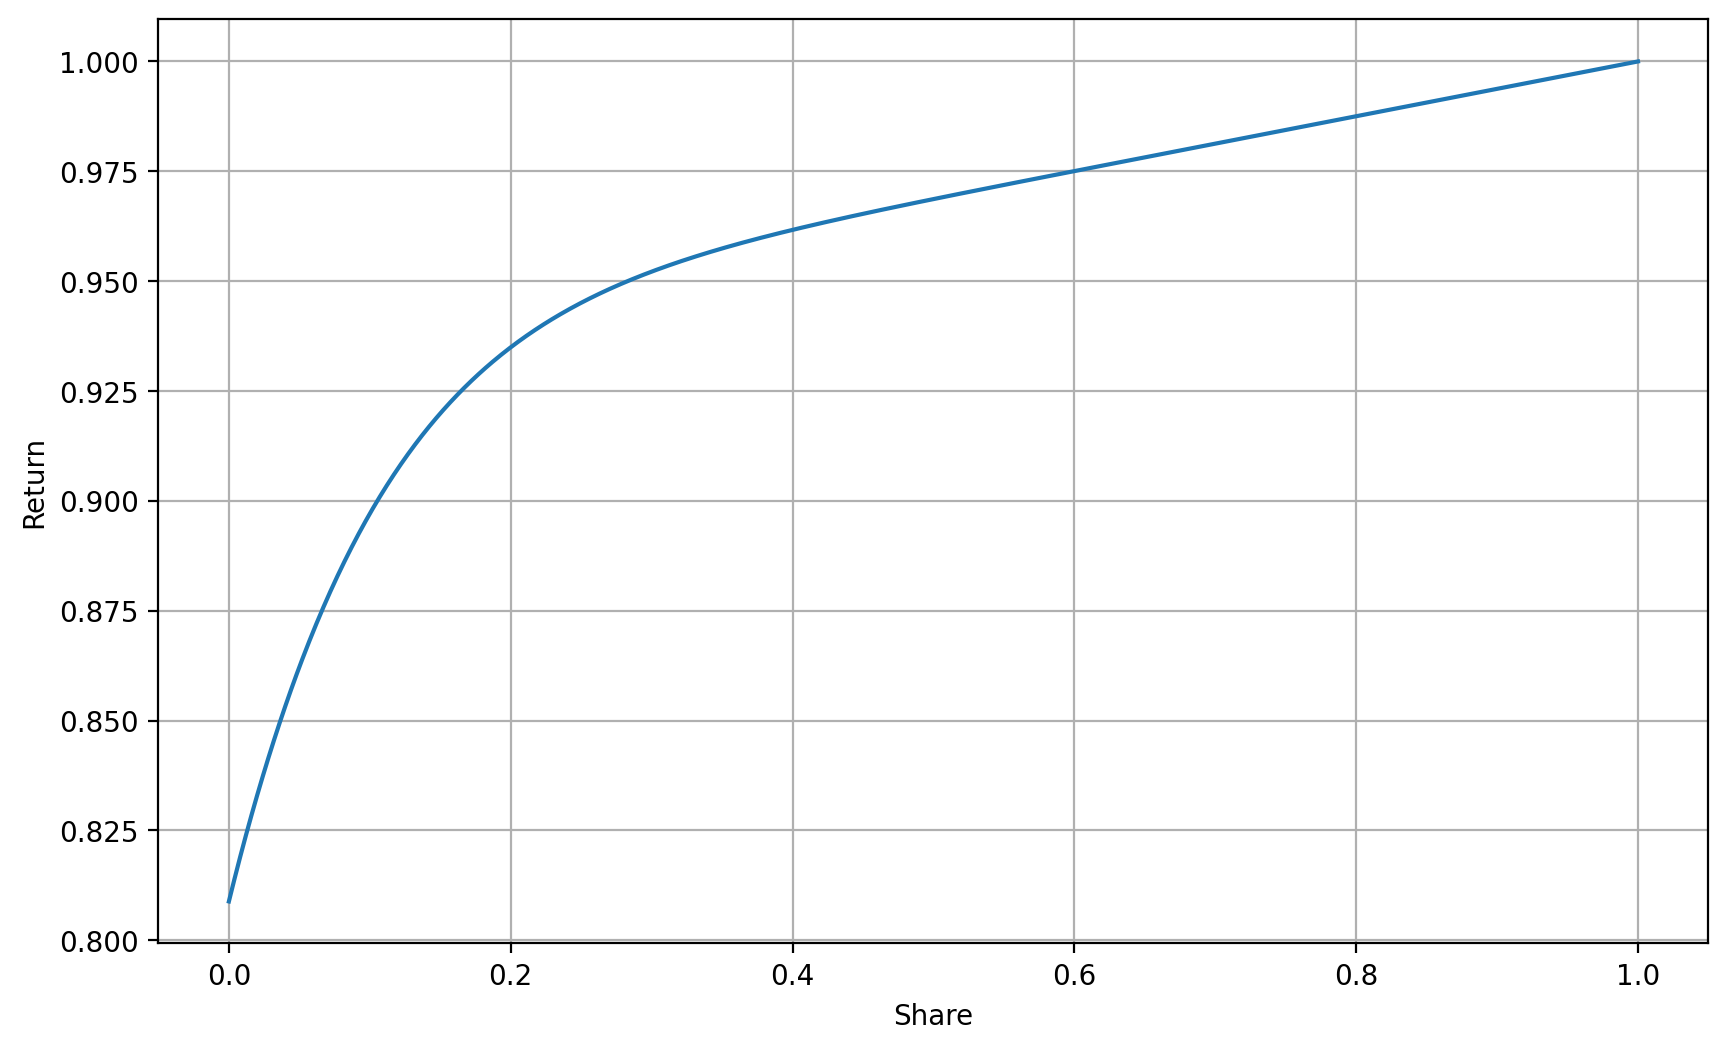

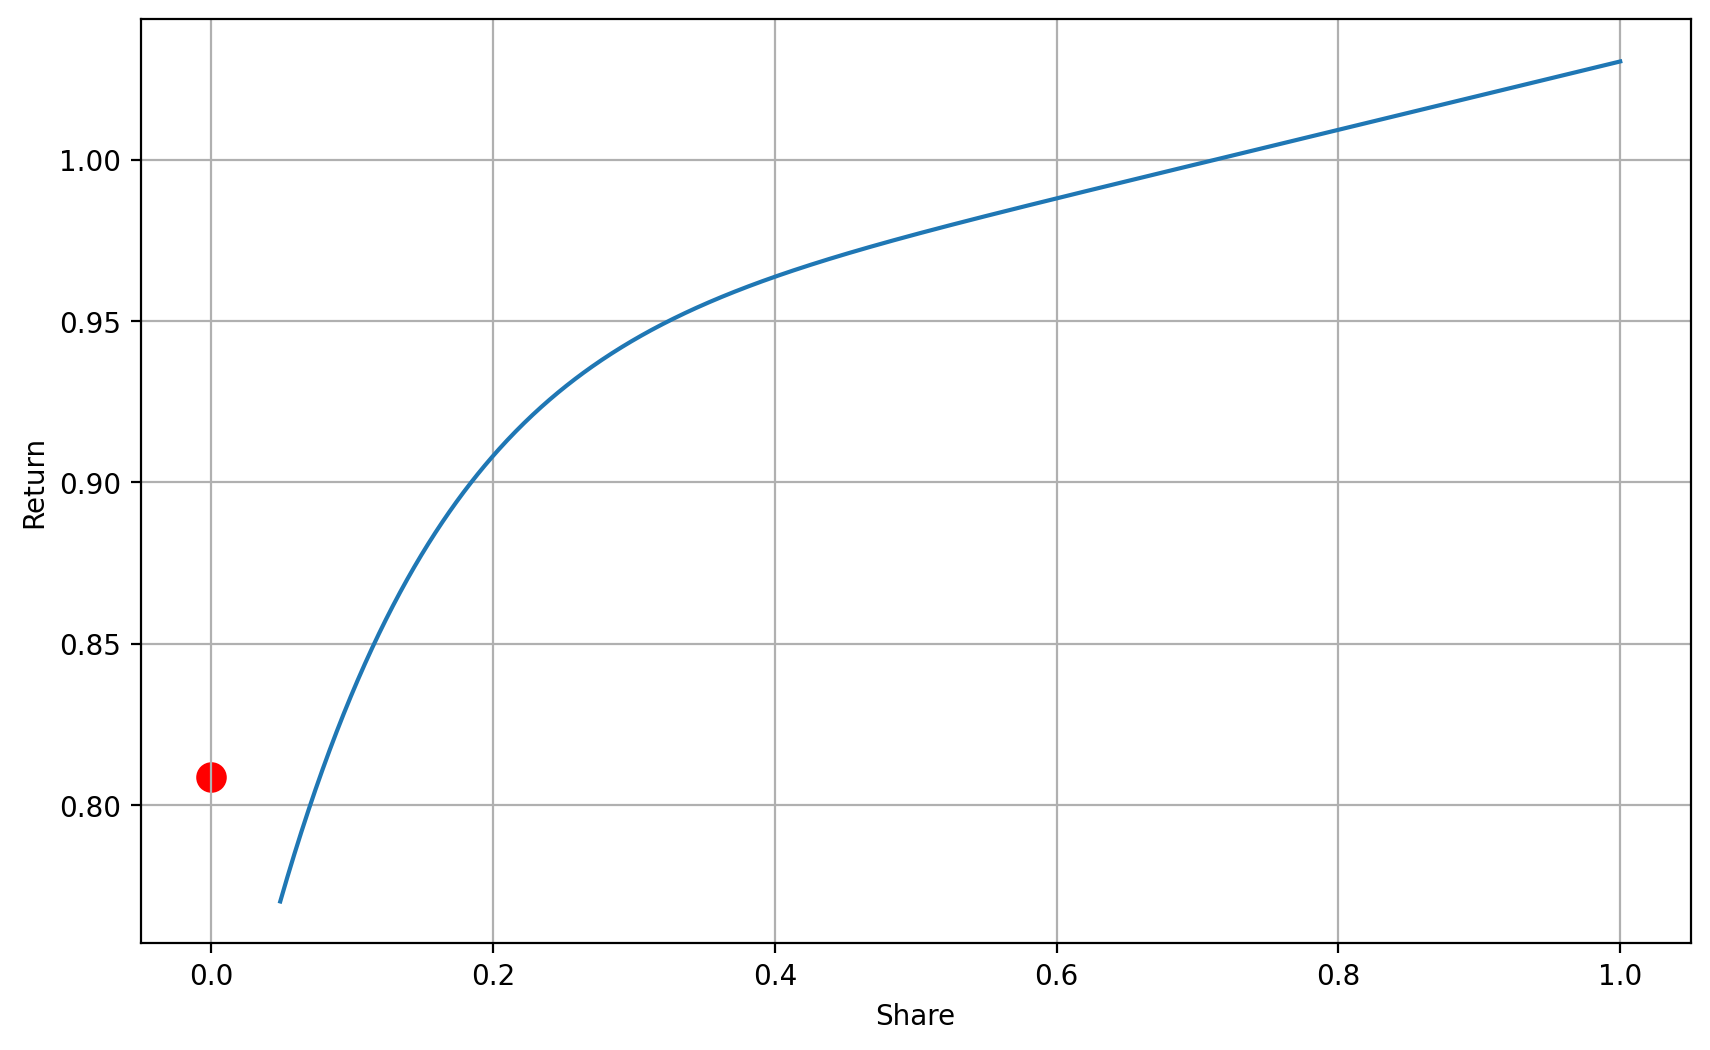

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.5, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.5,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Wide price range low volatility

<ipython-input-96-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0.029855941836332504


<ipython-input-96-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) - 

Optimal LHP:  0.08000466617992998


<ipython-input-96-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x) 

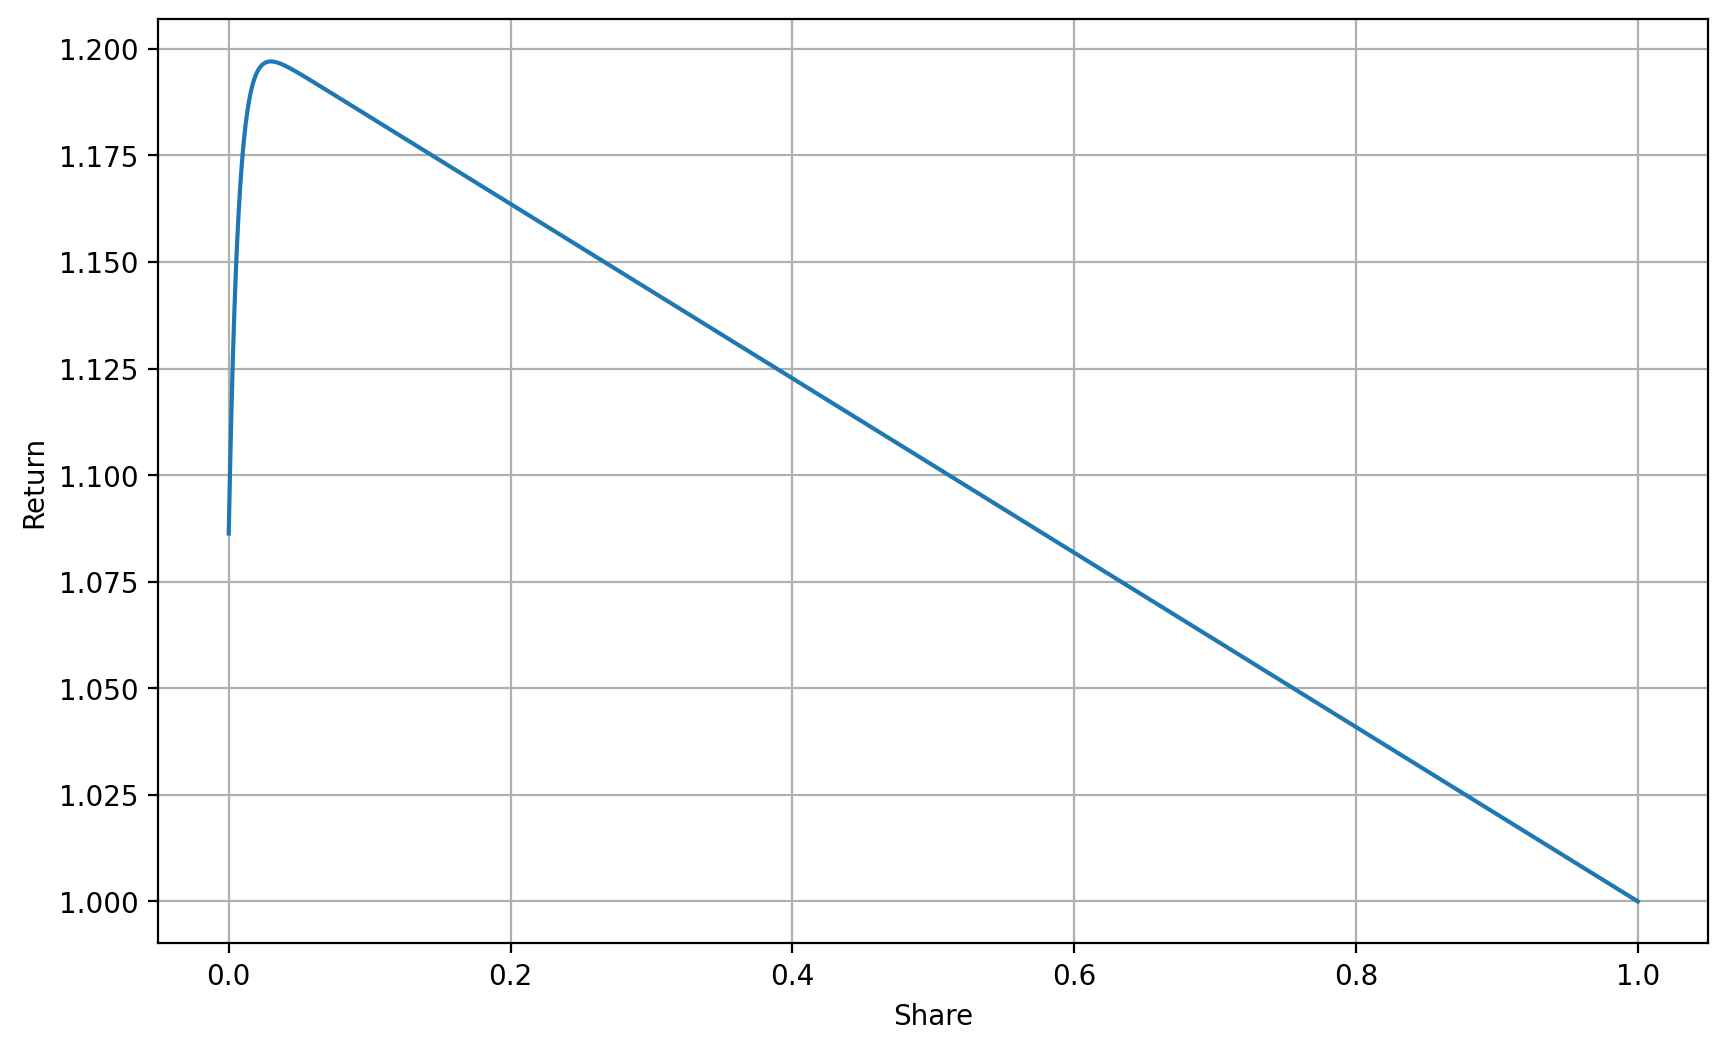

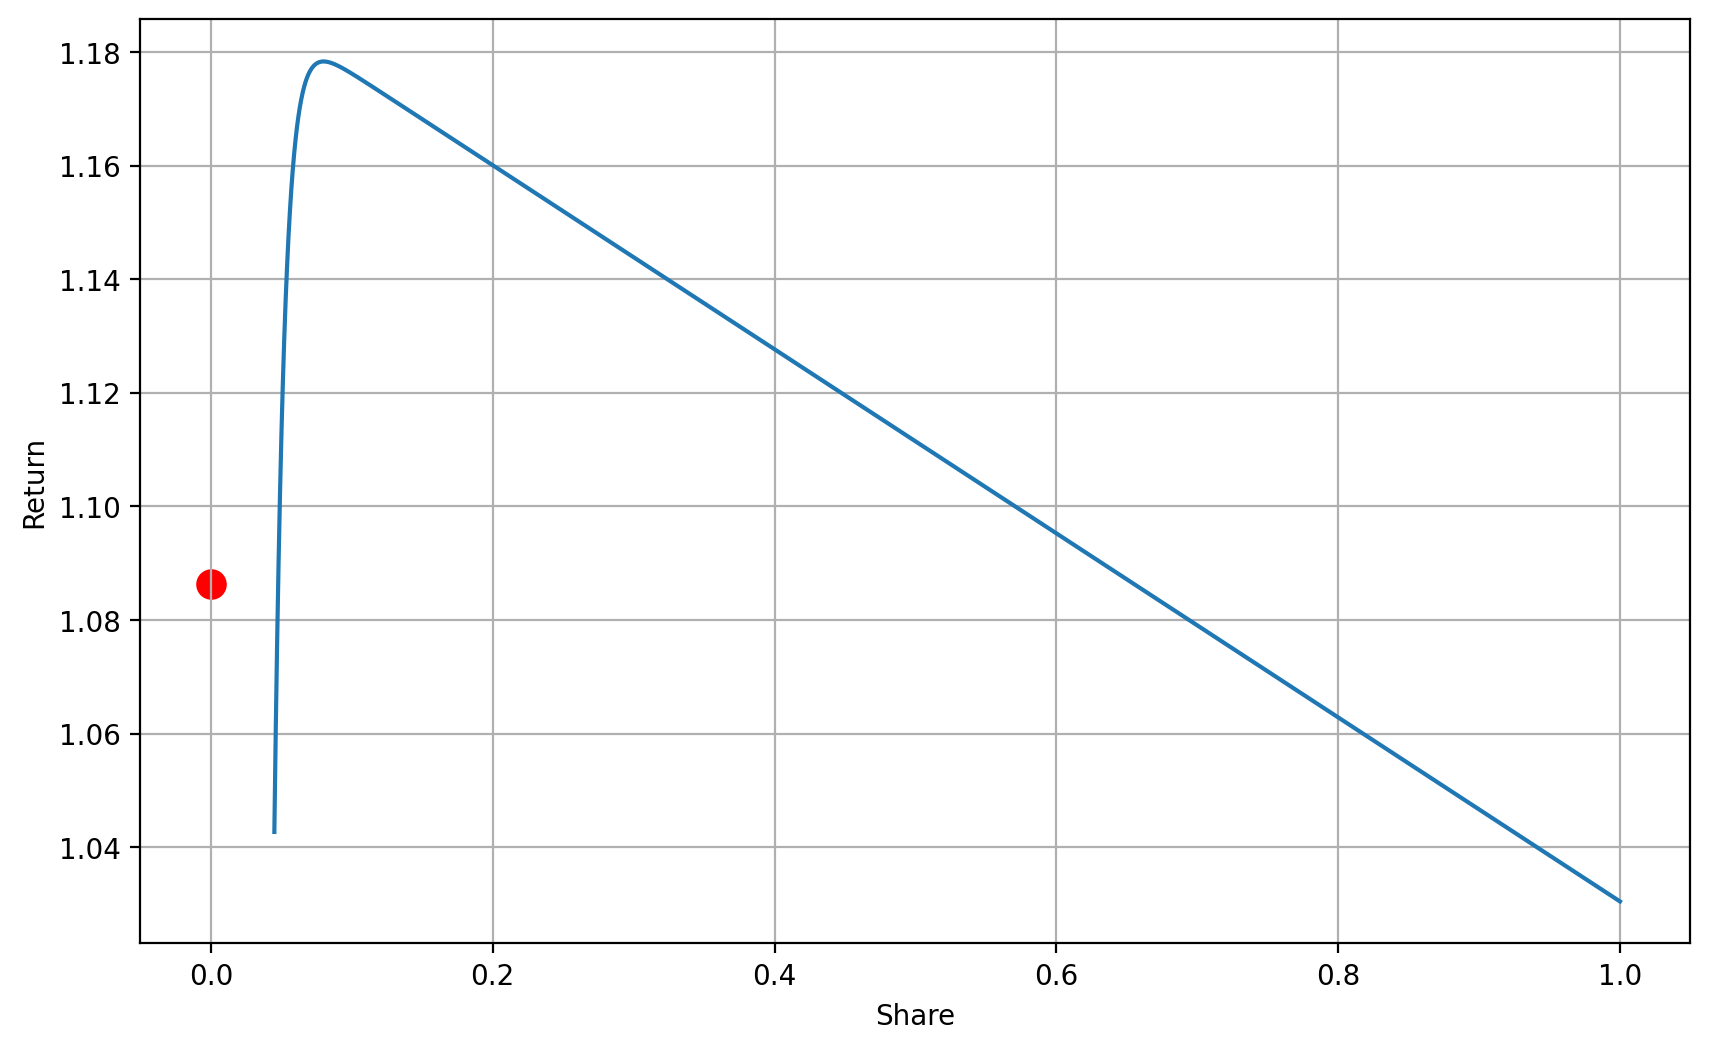

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.1, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.1,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Wide price range medium volatility

<ipython-input-96-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)
<ipython-input-96-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np

Optimal MBP::  0.13364476112262436


<ipython-input-96-2872108846>:514: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal LHP:  0.21433373566890732


<ipython-input-96-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x) 

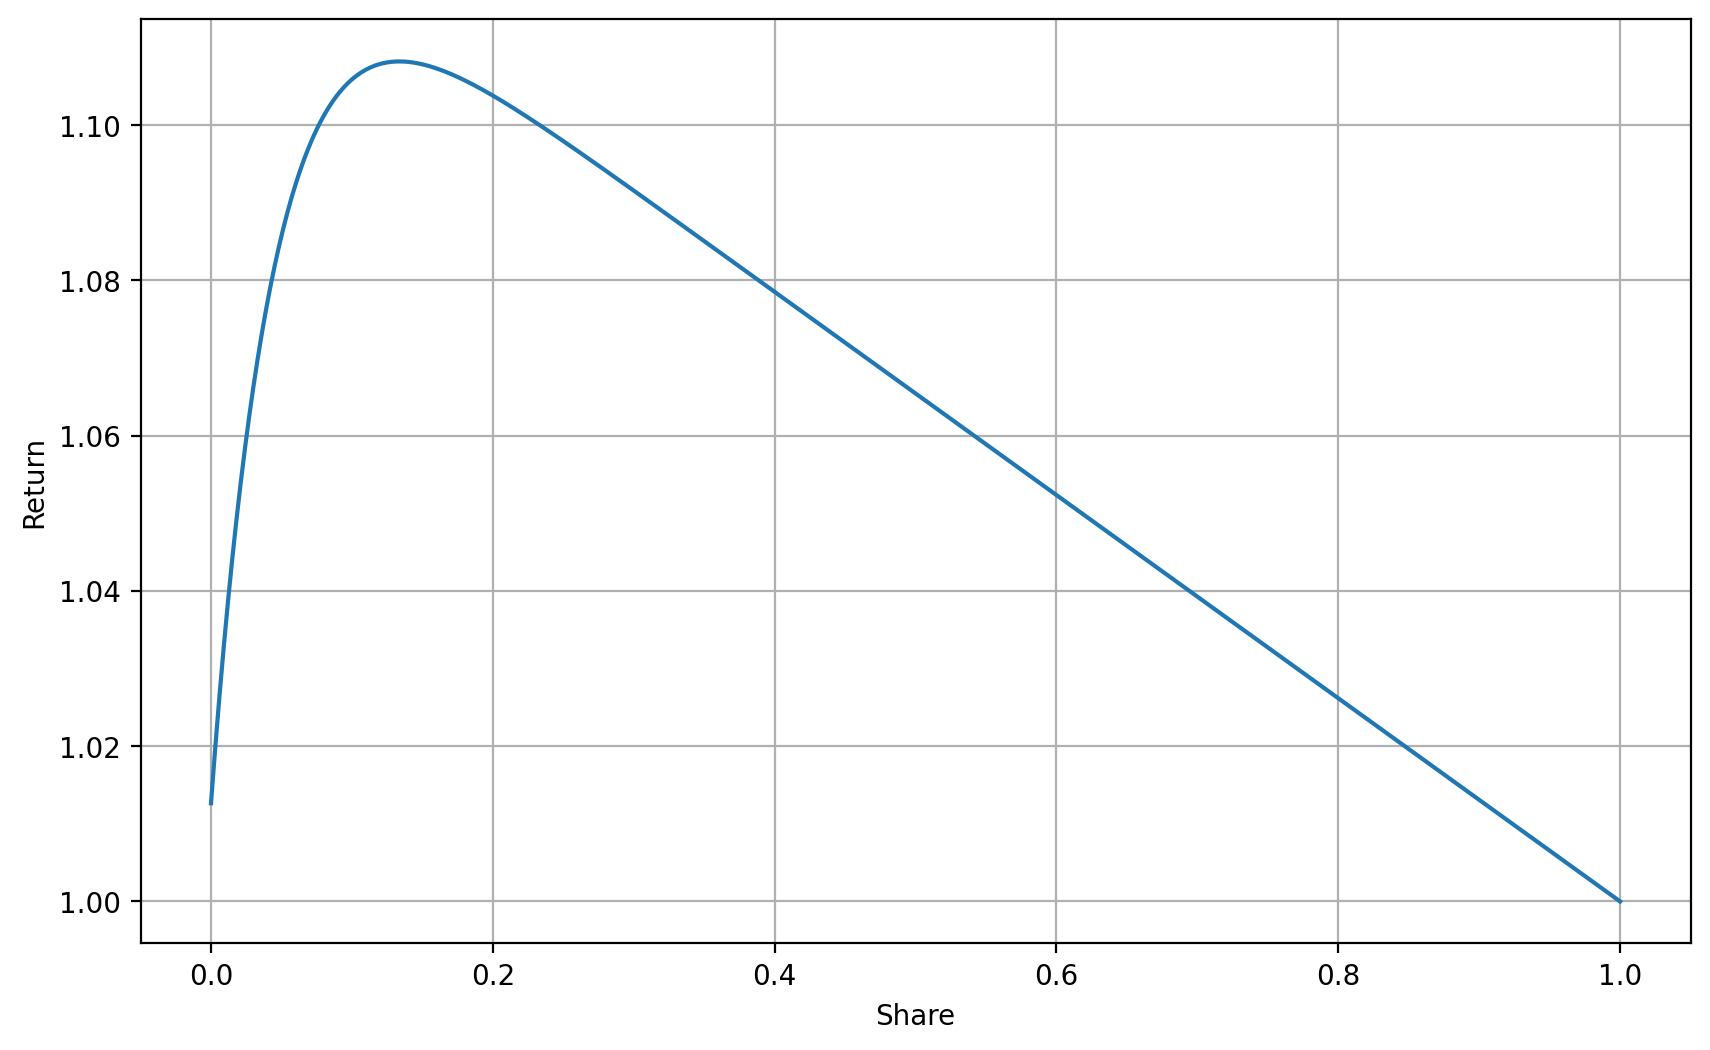

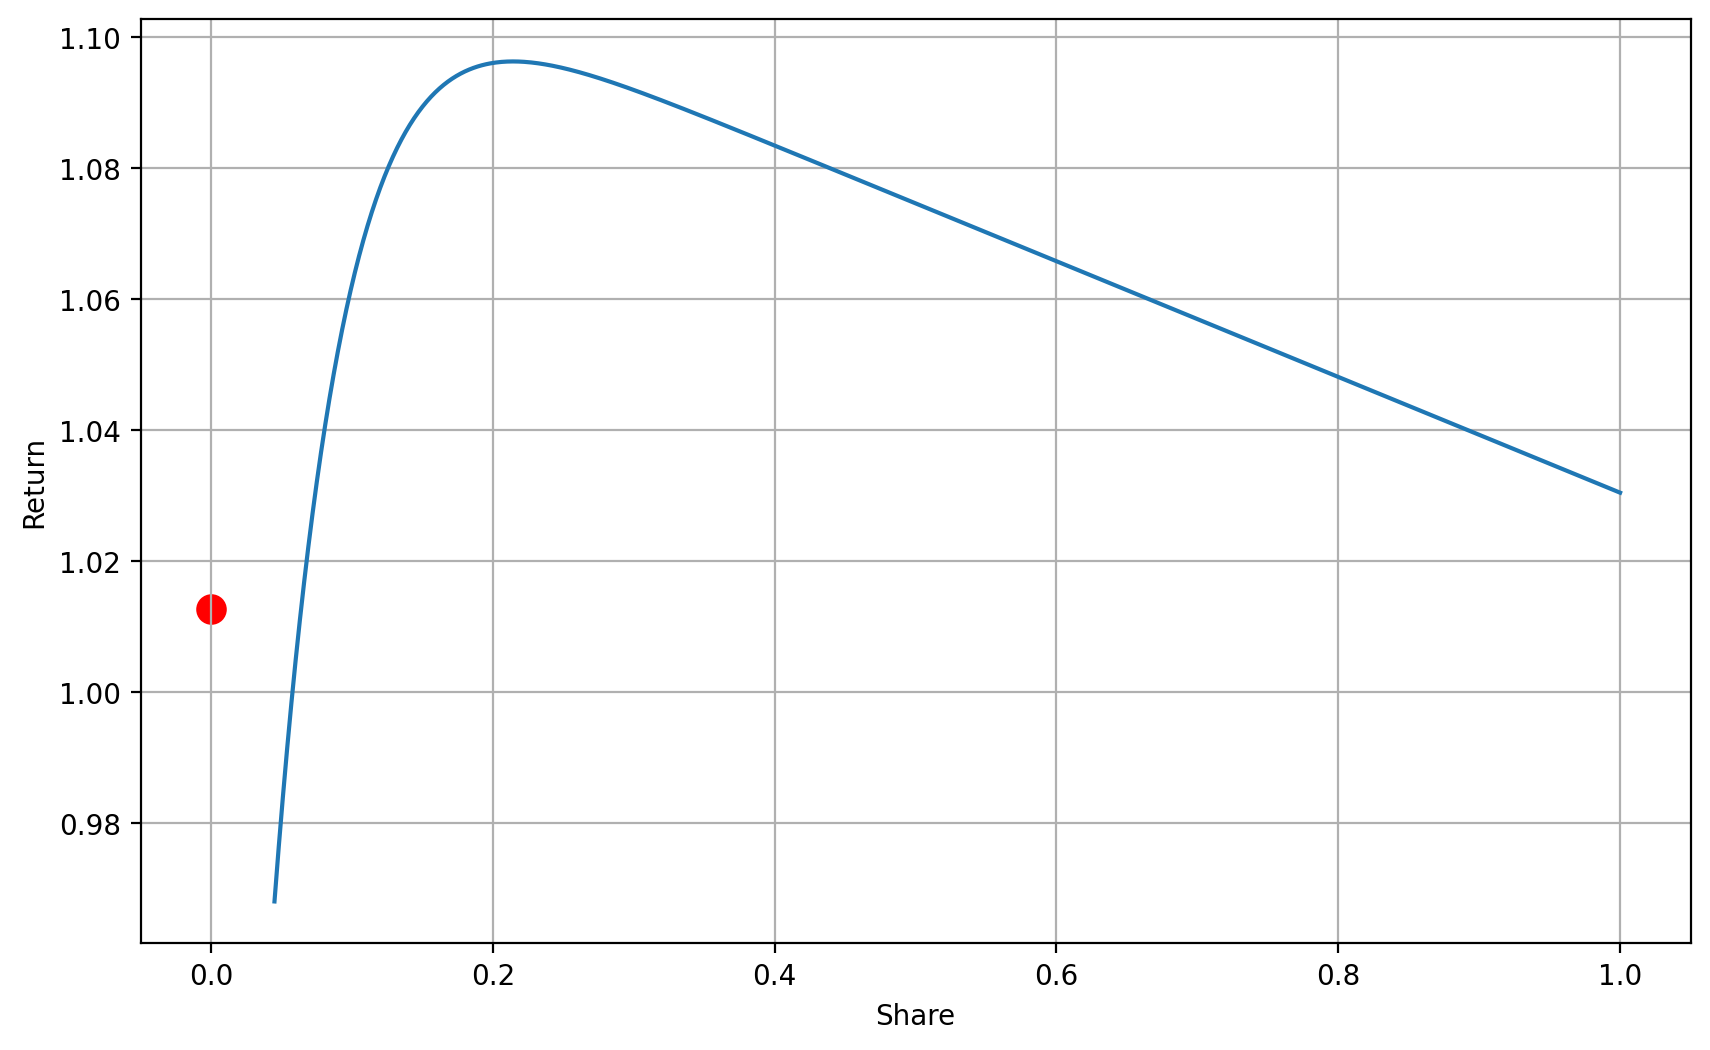

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], params['s'],params['r_cd'], params['r_be'], params['theta'], params['D'])

###Wide price range high volatility

<ipython-input-96-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0.3252022666187902


<ipython-input-96-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) - 

Optimal LHP:  1


<ipython-input-96-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x) 

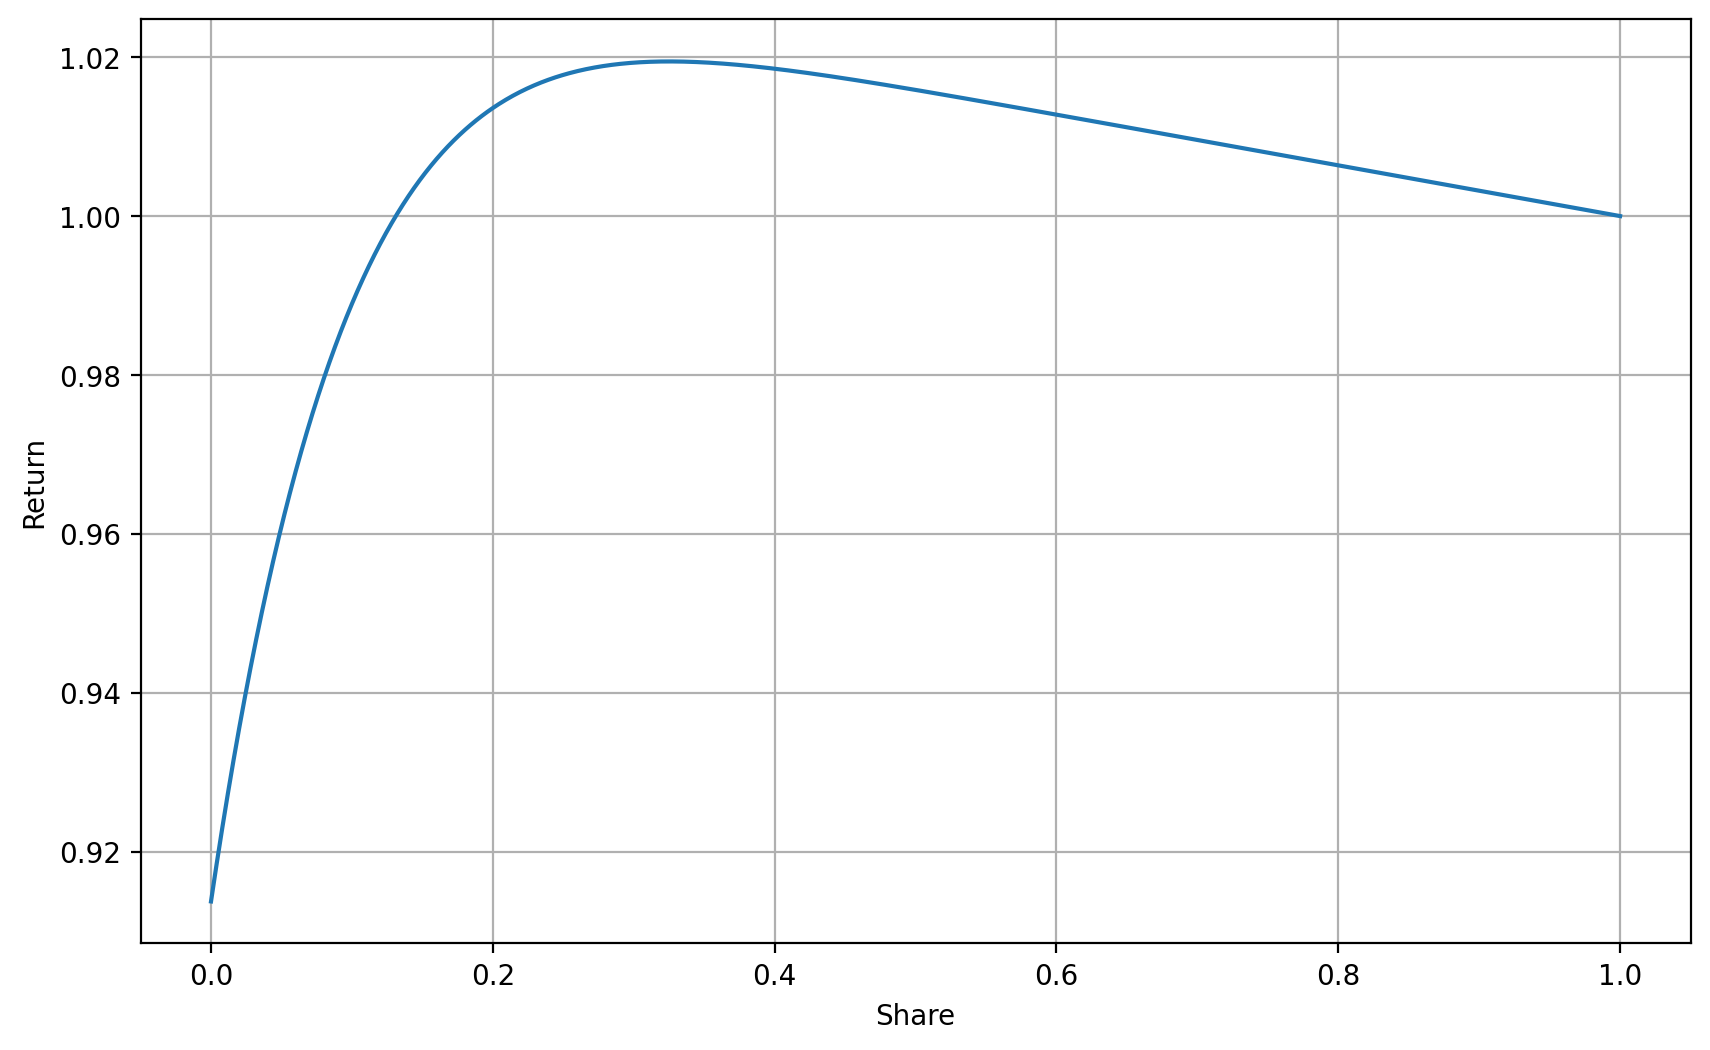

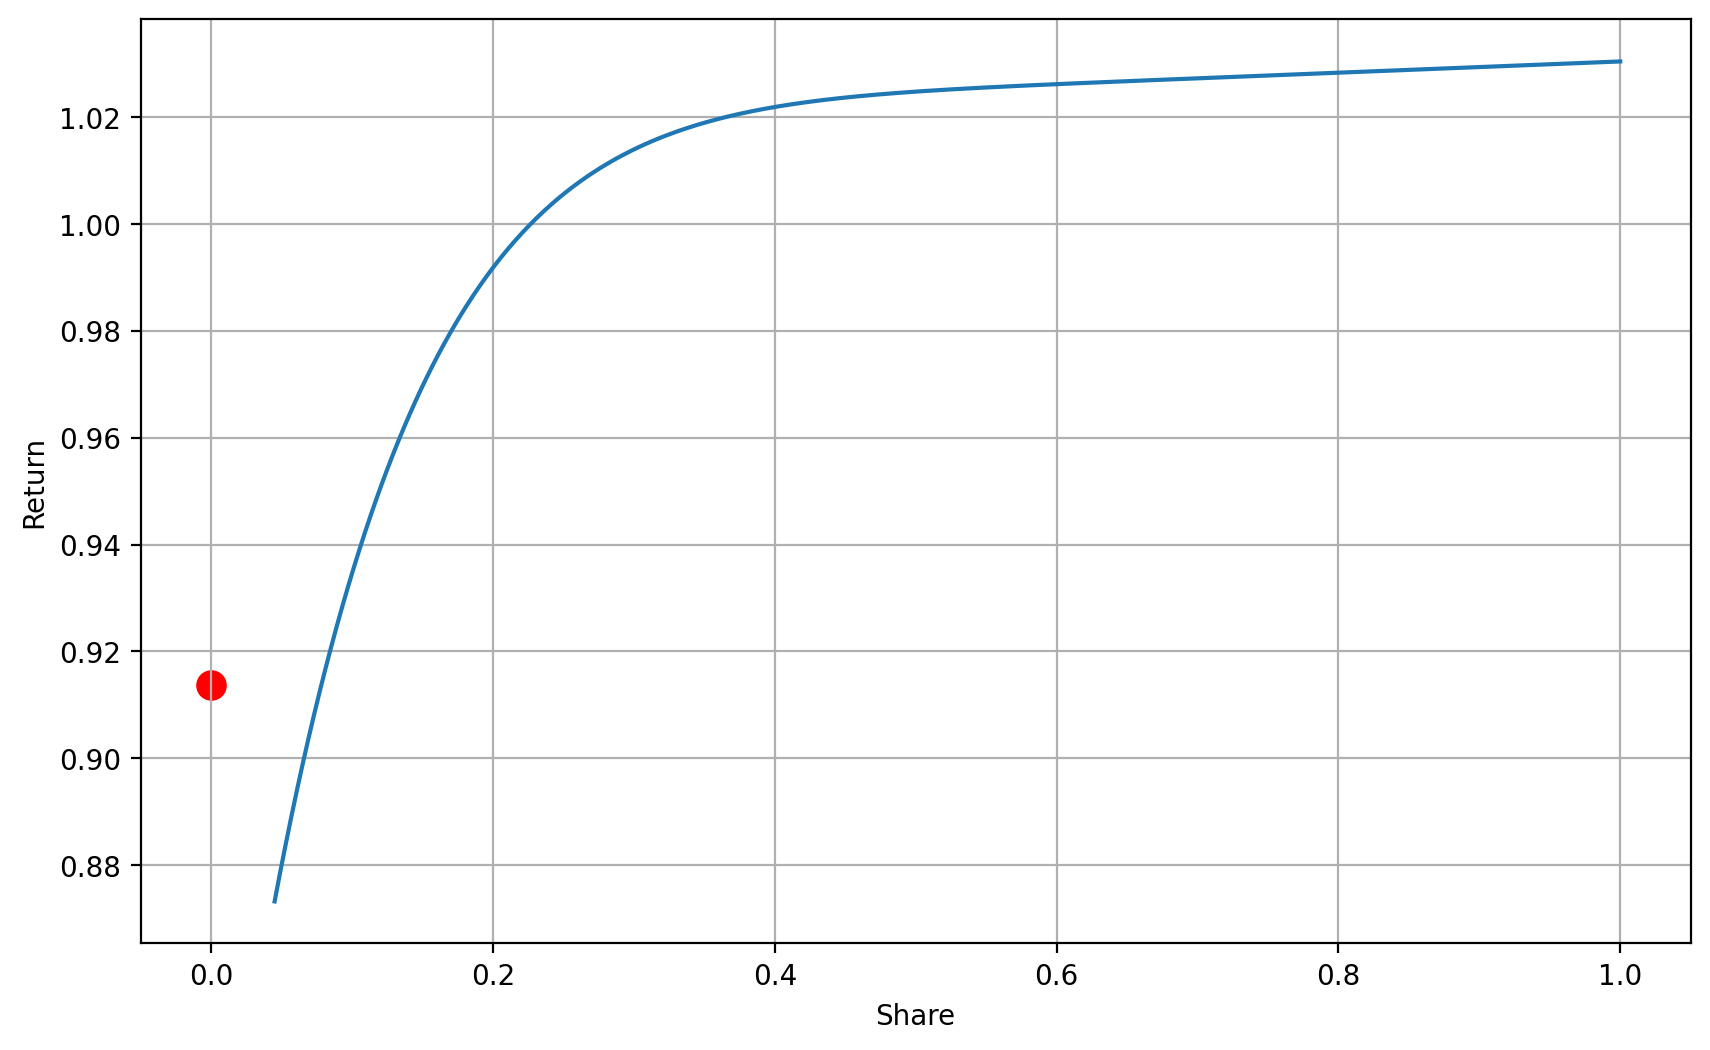

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.5, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.5,params['r_cd'], params['r_be'], params['theta'], params['D'])

##Flat market

In [ ]:
#Parameters

params = {
    'p_0': 3000,
    'p_a' : 2800,
    'p_b' : 3200,
    'b': 0.3,
    'l': 0.05,
    't': 1,
    'u': 0.0,
    's': 0.3,
    'kappa': 0.05,
    'iota': 0.01,
    'r_a': 0.05,
    'r_b': 0.0174,
    'r_cd': 0.03, #0.03 as default
    'r_be': 0.05,
    'theta': 0.9,
    'D': 1
    }

###Small price range low volatility

In [ ]:
lp.APY_MBP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.1, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.1,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Small price range middle volatility

In [ ]:
lp.APY_MBP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], params['s'],params['r_cd'], params['r_be'], params['theta'], params['D'])

###Small price range high volatility

In [ ]:
lp.APY_MBP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.5, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.5,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Middle price range low volatility

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.1, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.1,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Middle price range middle volatility

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], params['s'],params['r_cd'], params['r_be'], params['theta'], params['D'])

###Middle price range high volatility

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.5, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.5,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Wide price range low volatility

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.1, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.1,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Wide price range middle volatility

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], params['s'],params['r_cd'], params['r_be'], params['theta'], params['D'])

###Wide price range high volatility

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.5, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.5,params['r_cd'], params['r_be'], params['theta'], params['D'])

##Bull рынок

In [ ]:
#Parameters

params = {
    'p_0': 3000,
    'p_a' : 2800,
    'p_b' : 3200,
    'b': 0.3,
    'l': 0.05,
    't': 1,
    'u': 0.3,
    's': 0.3,
    'kappa': 0.05,
    'iota': 0.01,
    'r_a': 0.05,
    'r_b': 0.0174,
    'r_cd': 0.03, #0.03 as default
    'r_be': 0.05,
    'theta': 0.9,
    'D': 1
    }

###Узкий диапазон маленькая волатильность

<ipython-input-124-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0


<ipython-input-124-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) -

Optimal LHP:  0


<ipython-input-124-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x)

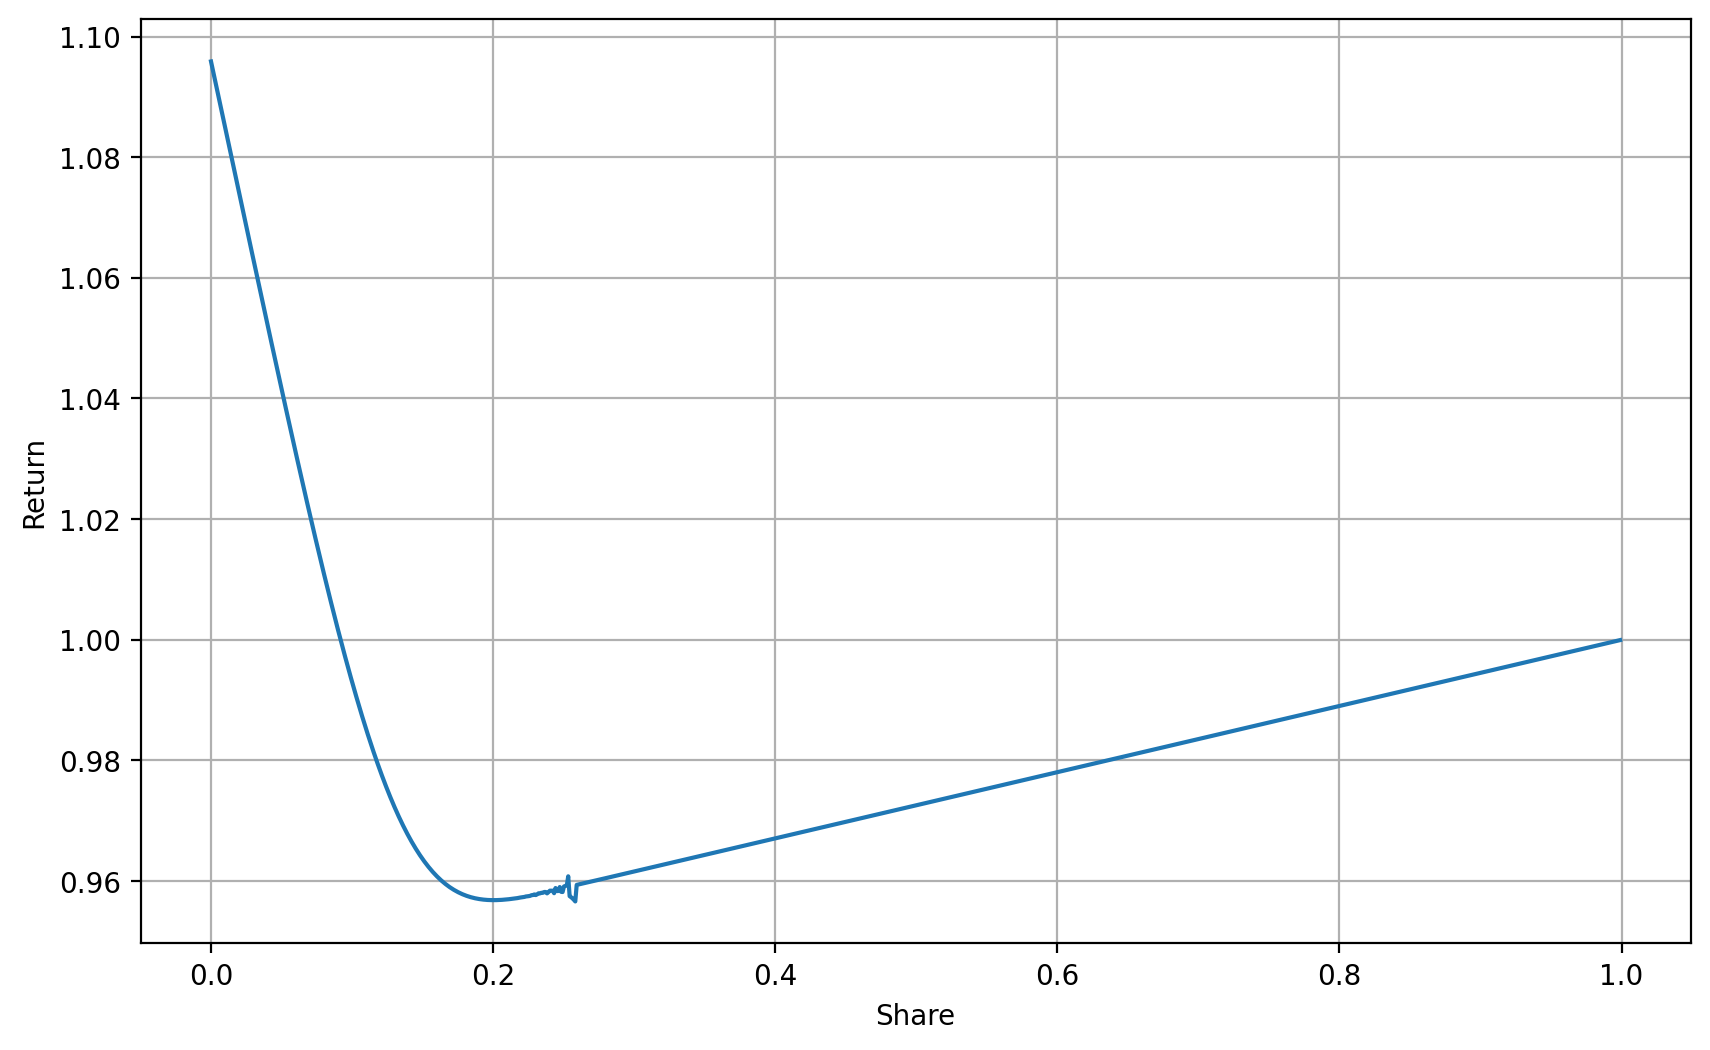

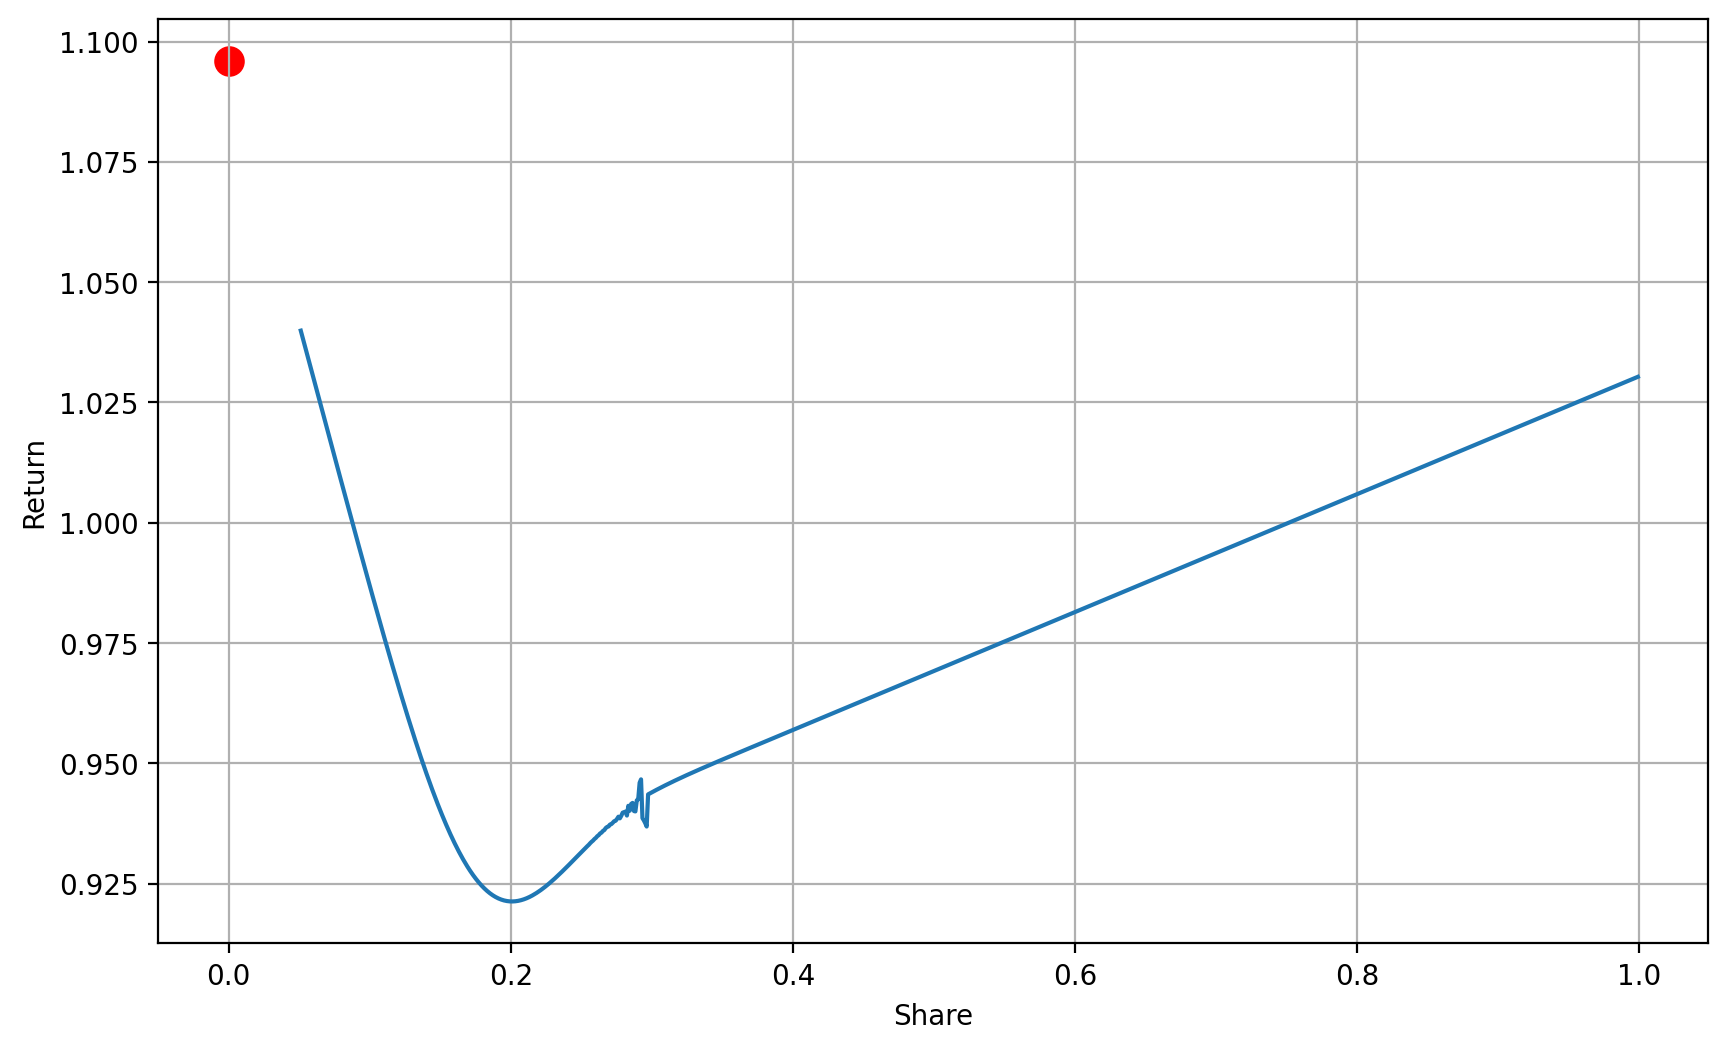

In [ ]:
lp.APY_MBP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.1, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.1,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Узкий диапазон средняя волатильность

<ipython-input-124-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0


<ipython-input-124-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) -

Optimal LHP:  0


<ipython-input-124-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x)

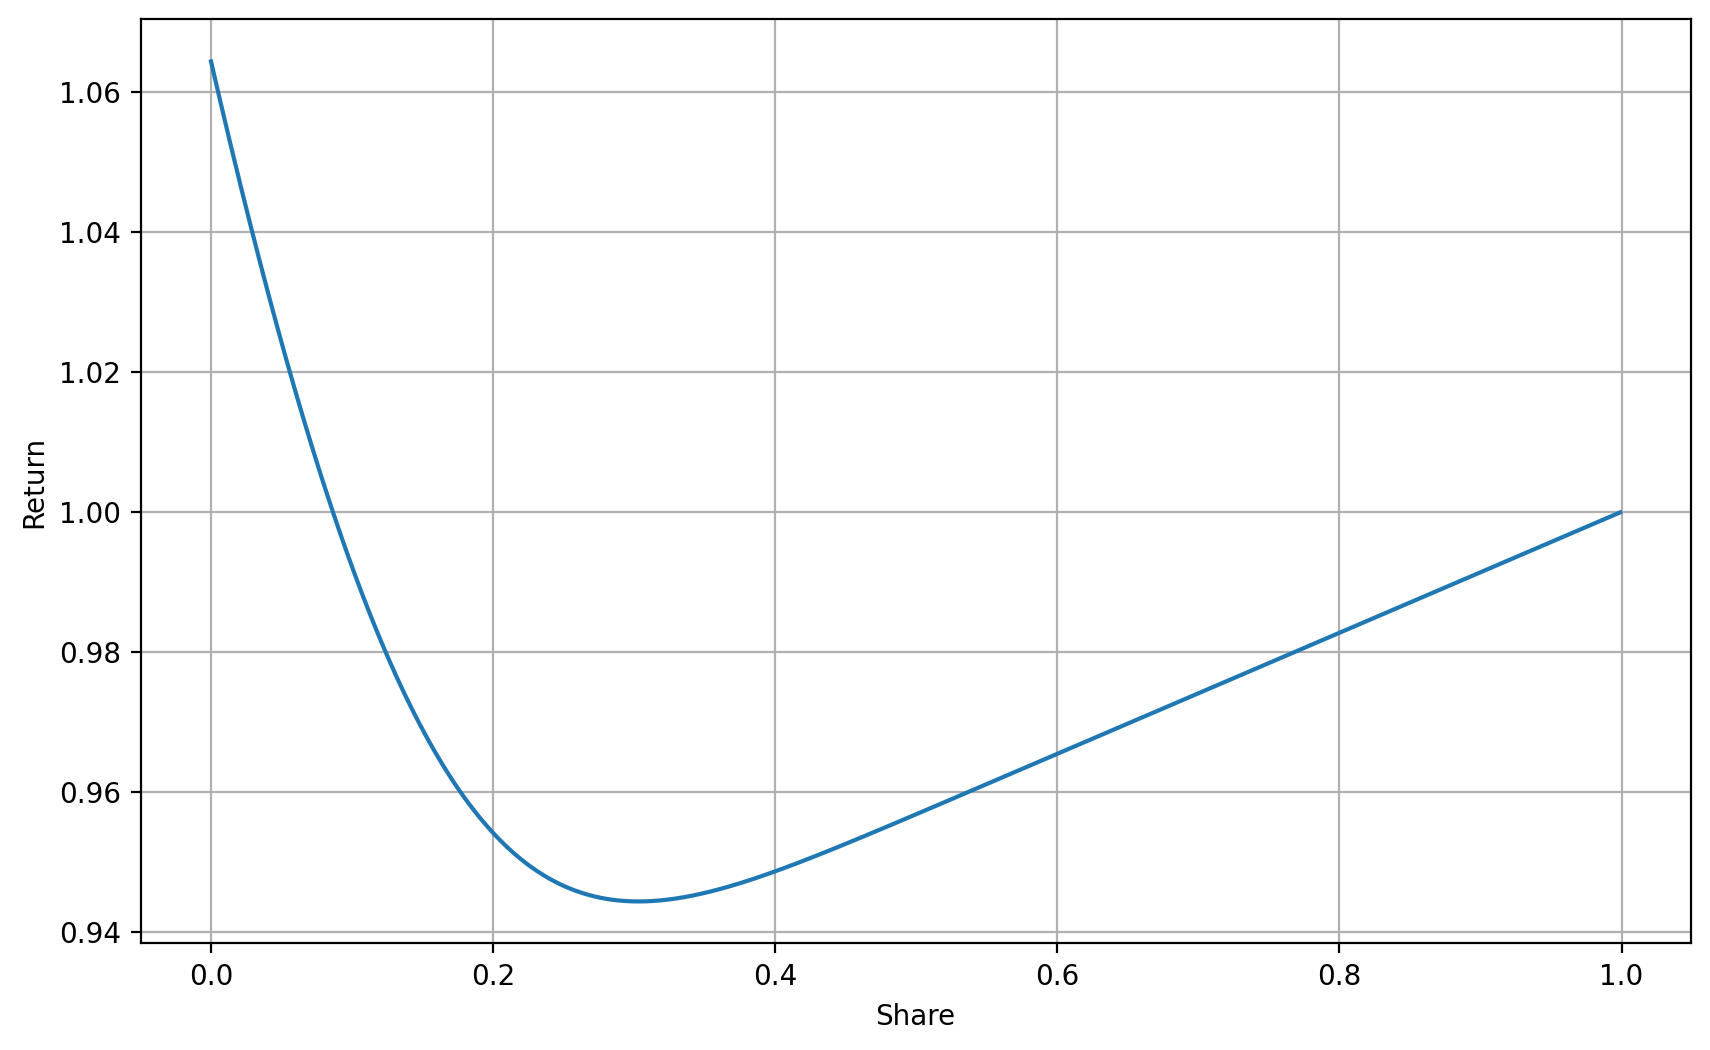

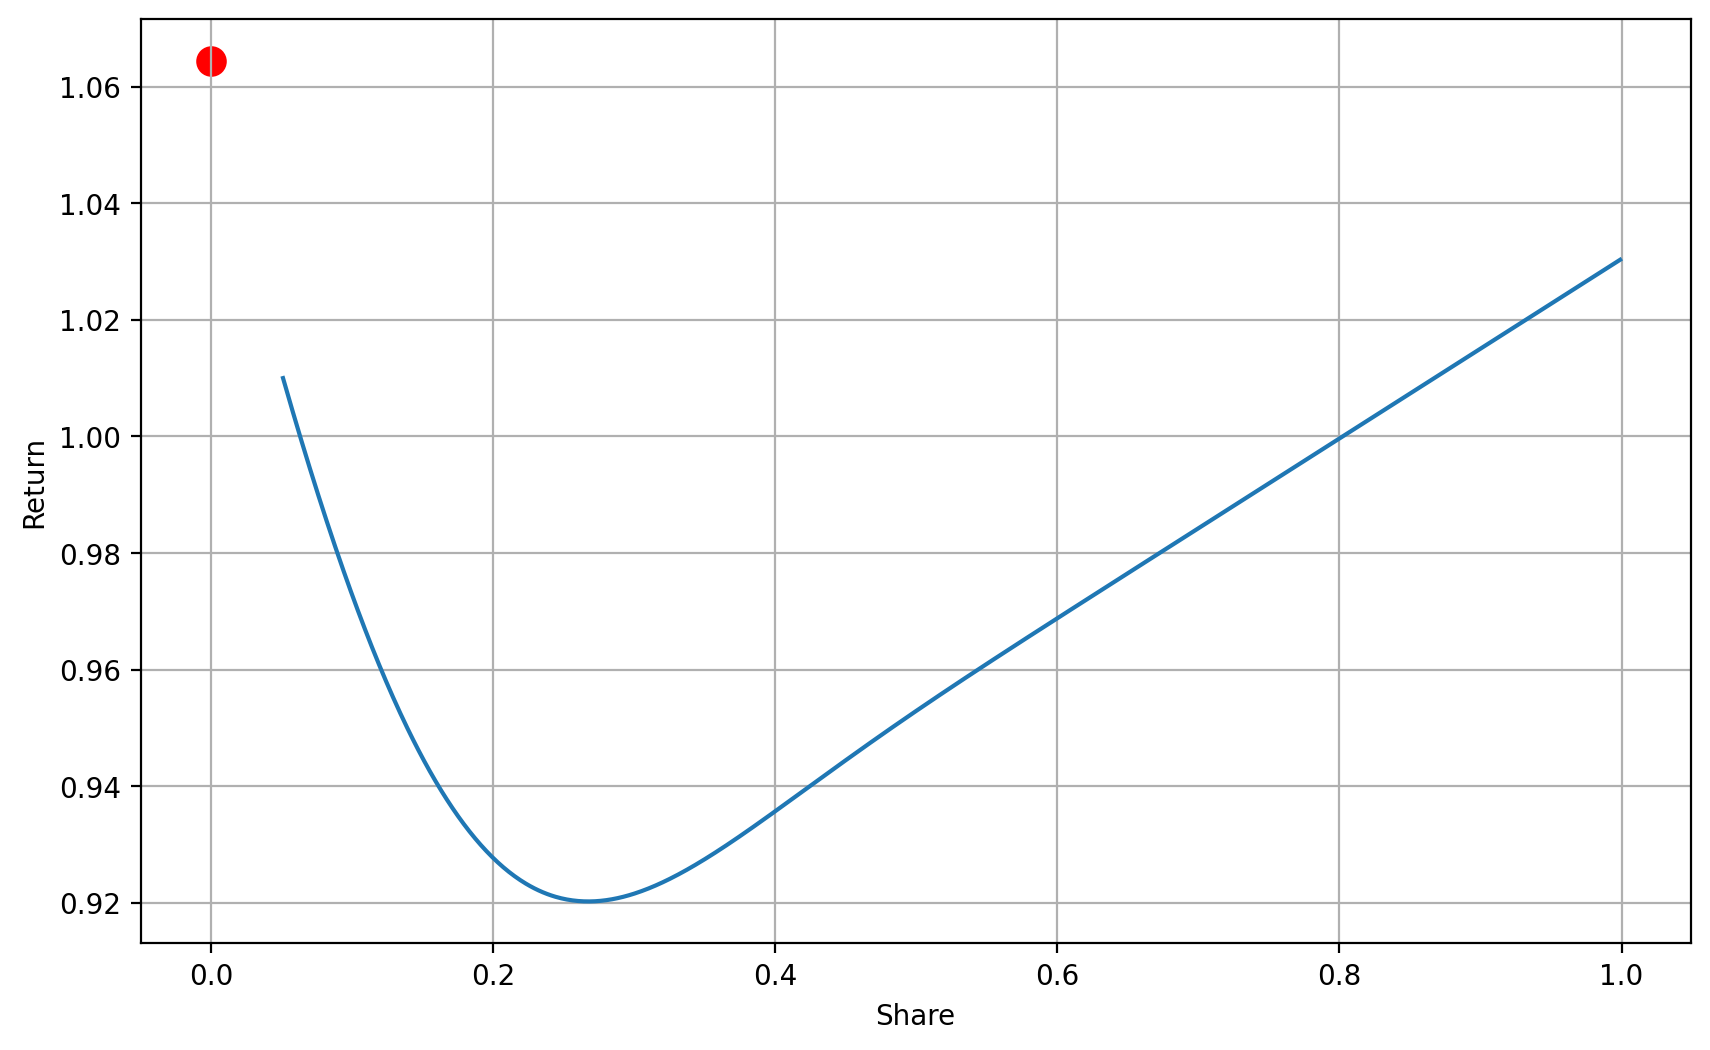

In [ ]:
lp.APY_MBP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], params['s'],params['r_cd'], params['r_be'], params['theta'], params['D'])

###Узкий диапазон большая волатильность

<ipython-input-124-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  1


<ipython-input-124-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) -

Optimal LHP:  1


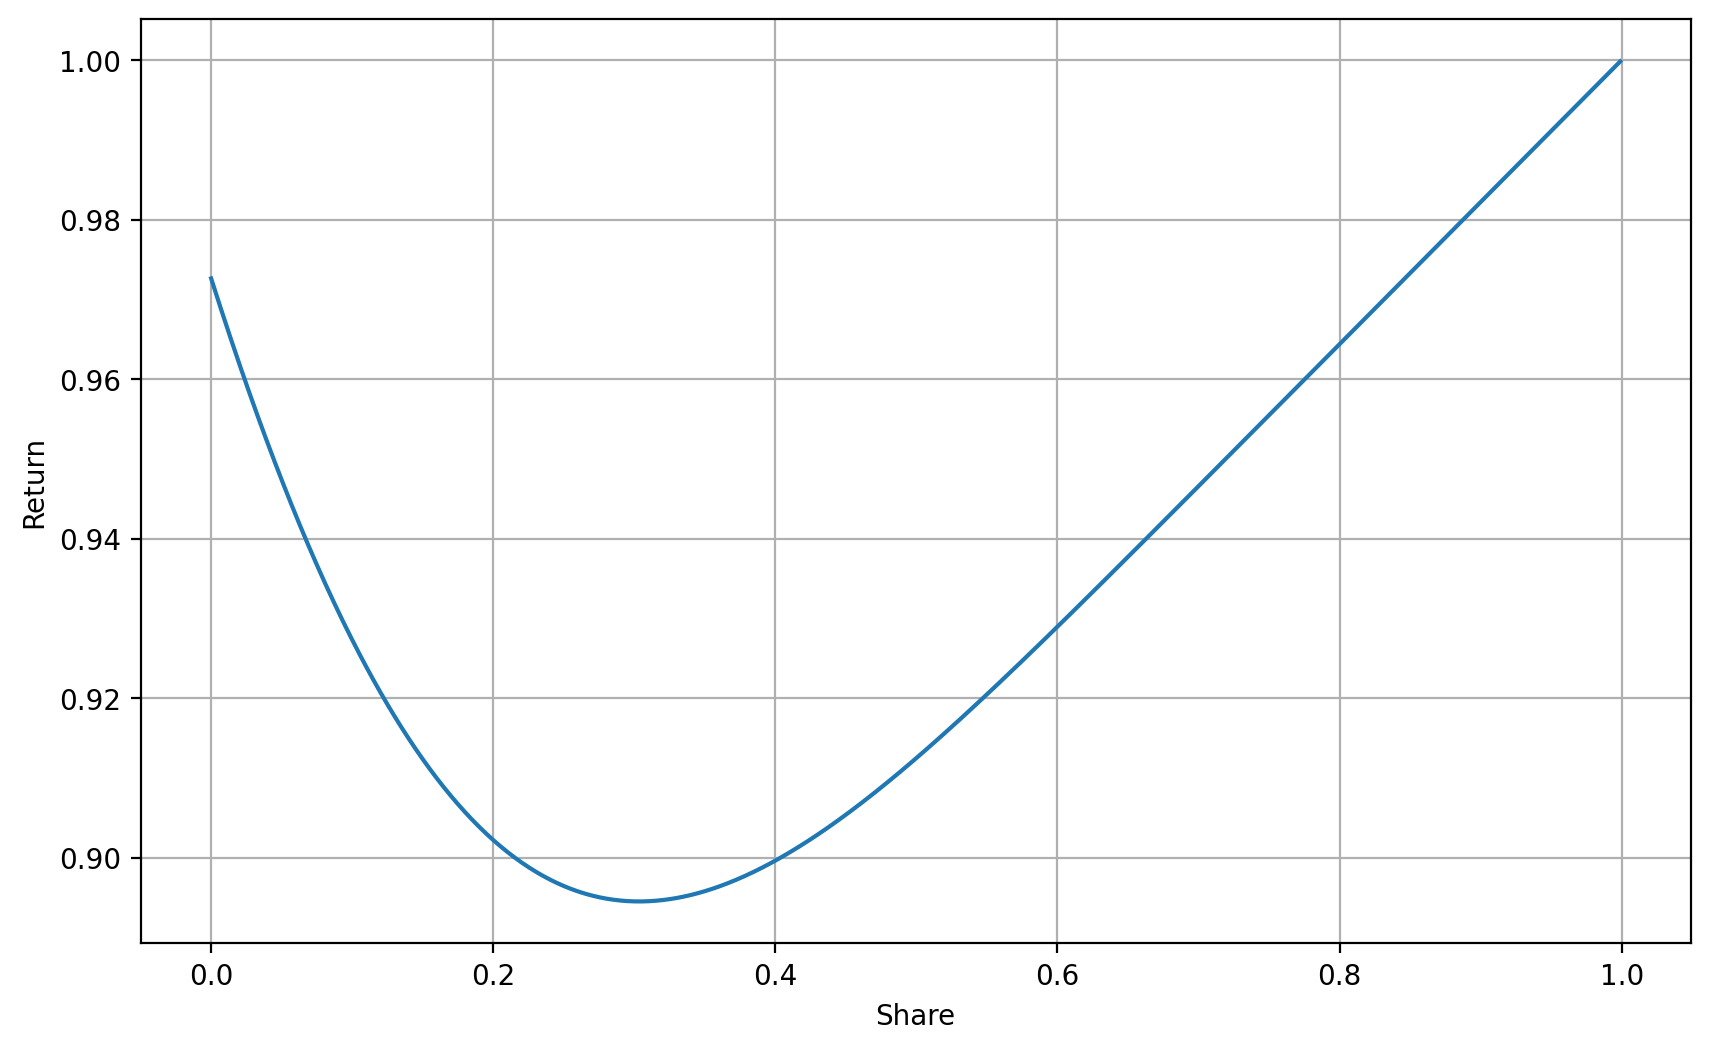

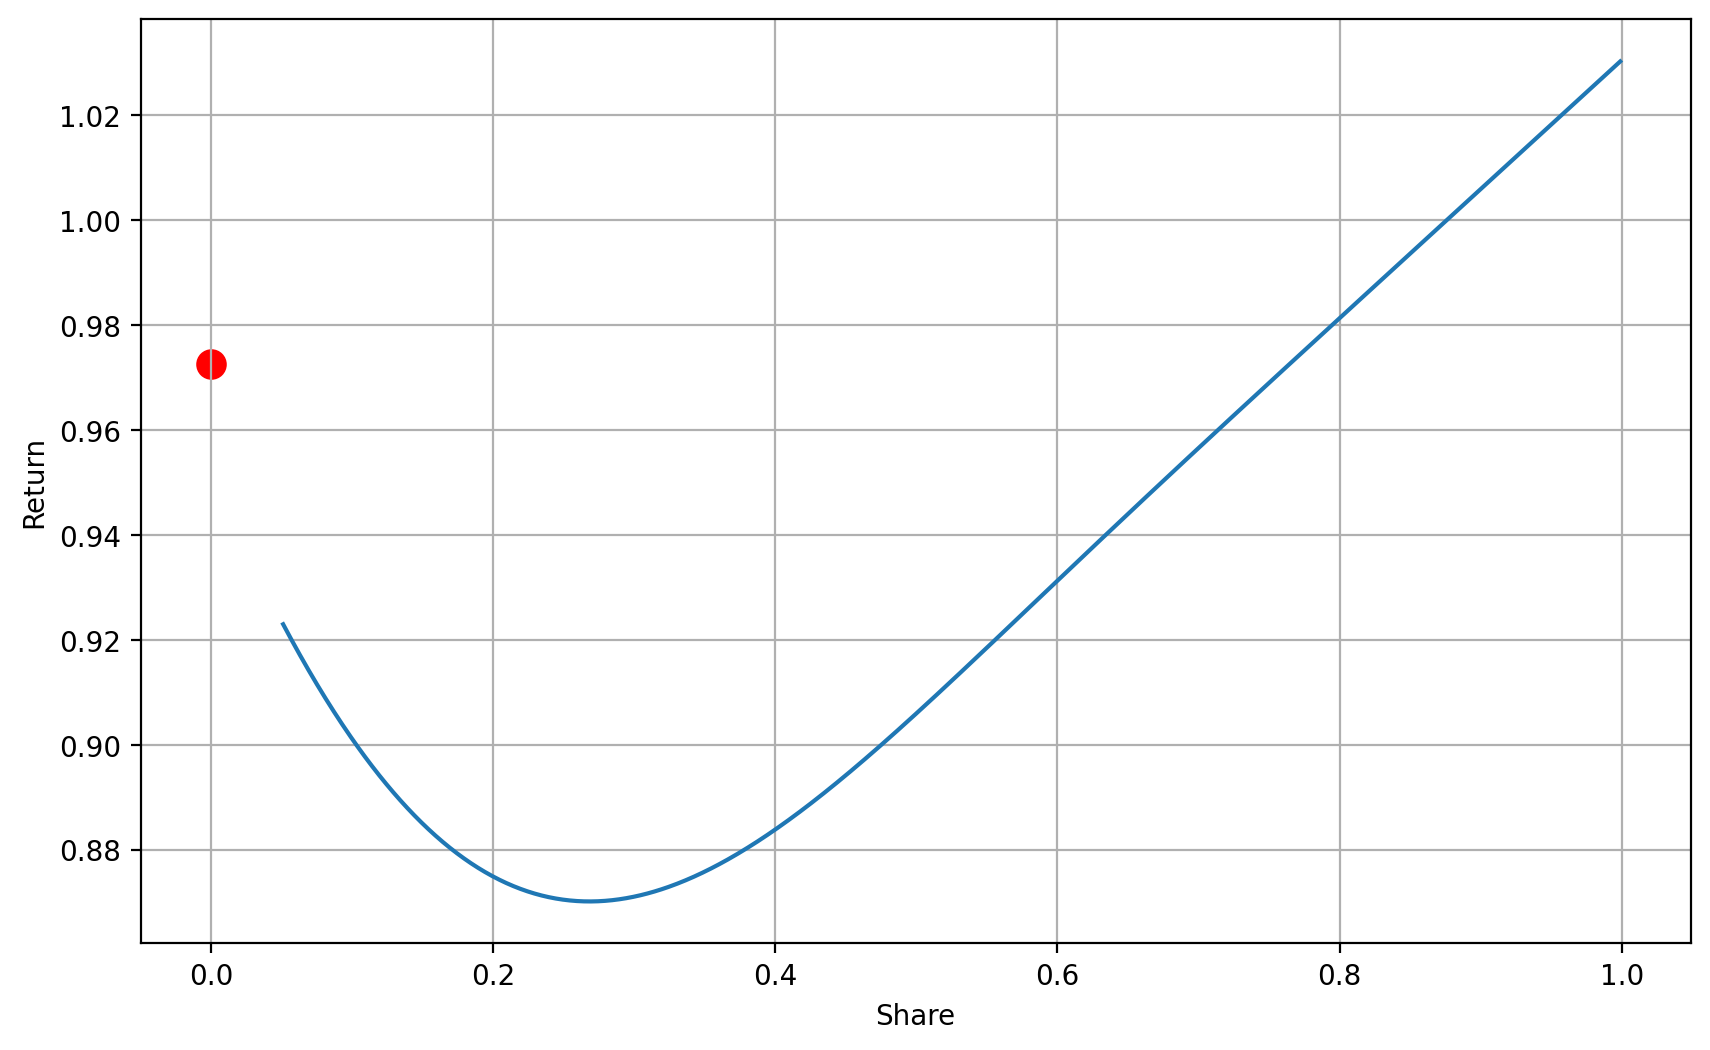

In [ ]:
lp.APY_MBP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.5, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], params['p_a'], params['p_b'], params['b'], params['l'], params['t'], params['u'], 0.5,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Средний диапазон низкая волатильность

<ipython-input-124-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0


<ipython-input-124-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) -

Optimal LHP:  0


<ipython-input-124-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x)

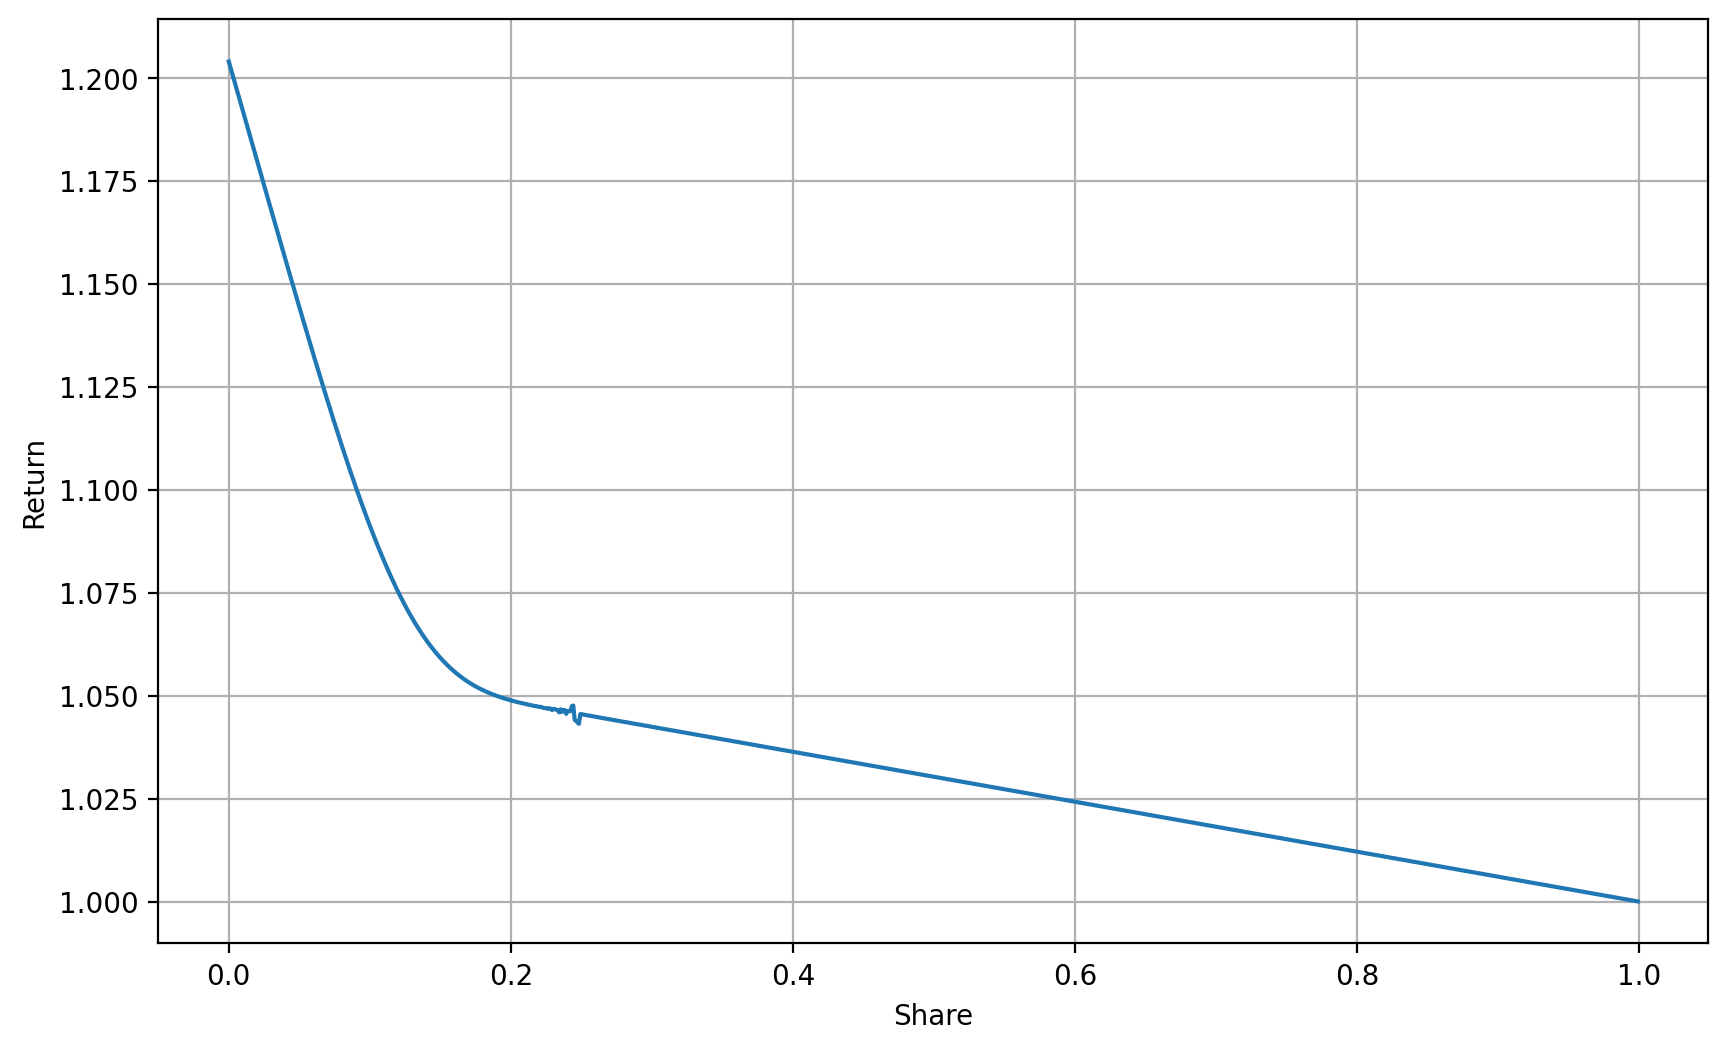

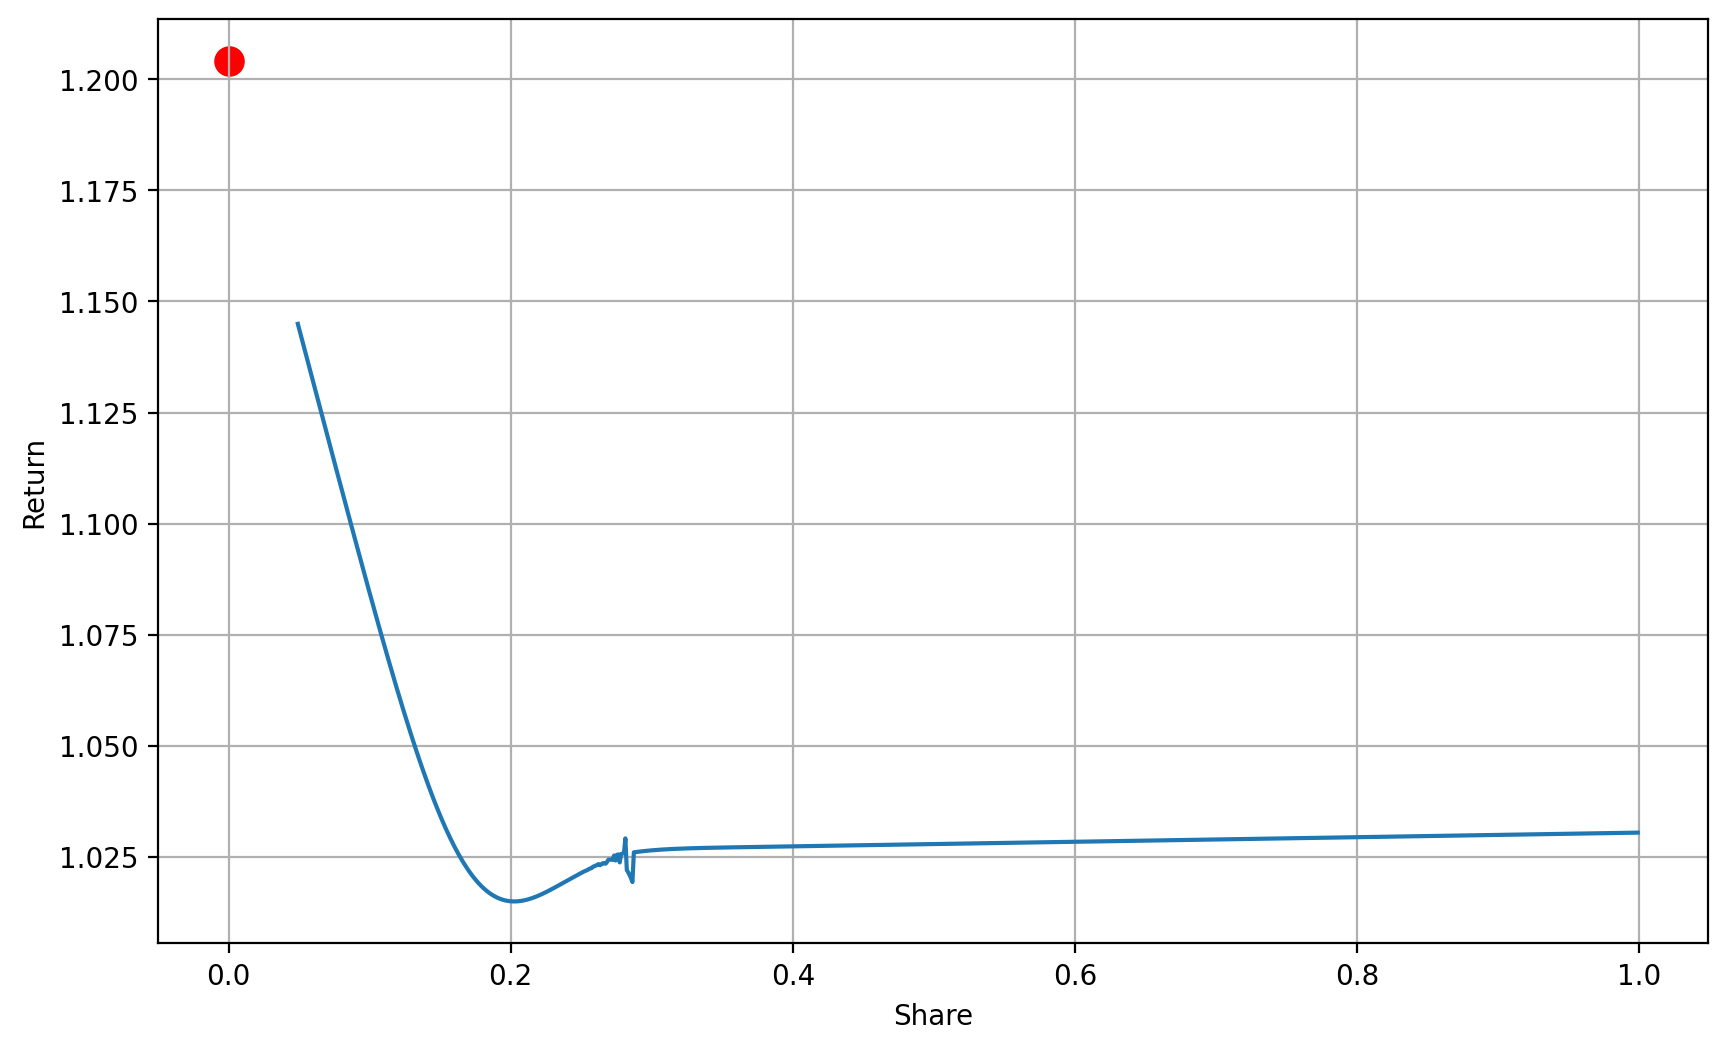

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.1, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.1,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Средний диапазон средняя волатильность

<ipython-input-124-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0


<ipython-input-124-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) -

Optimal LHP:  0


<ipython-input-124-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x)

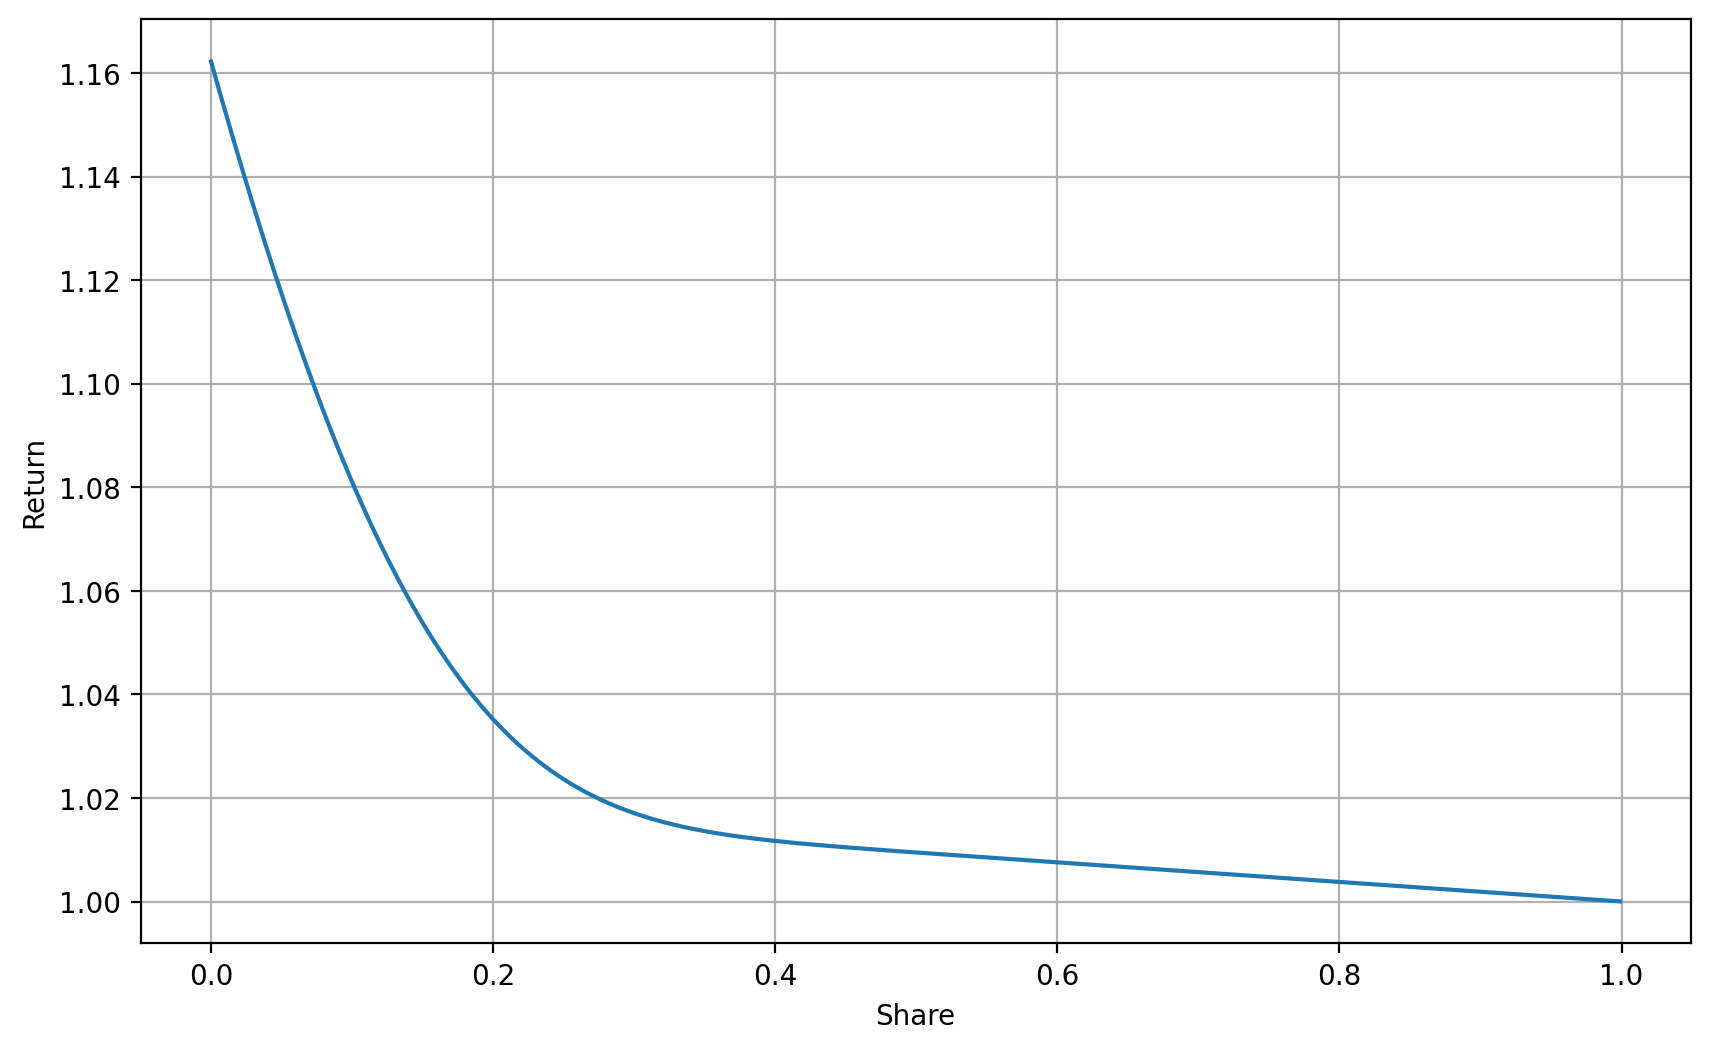

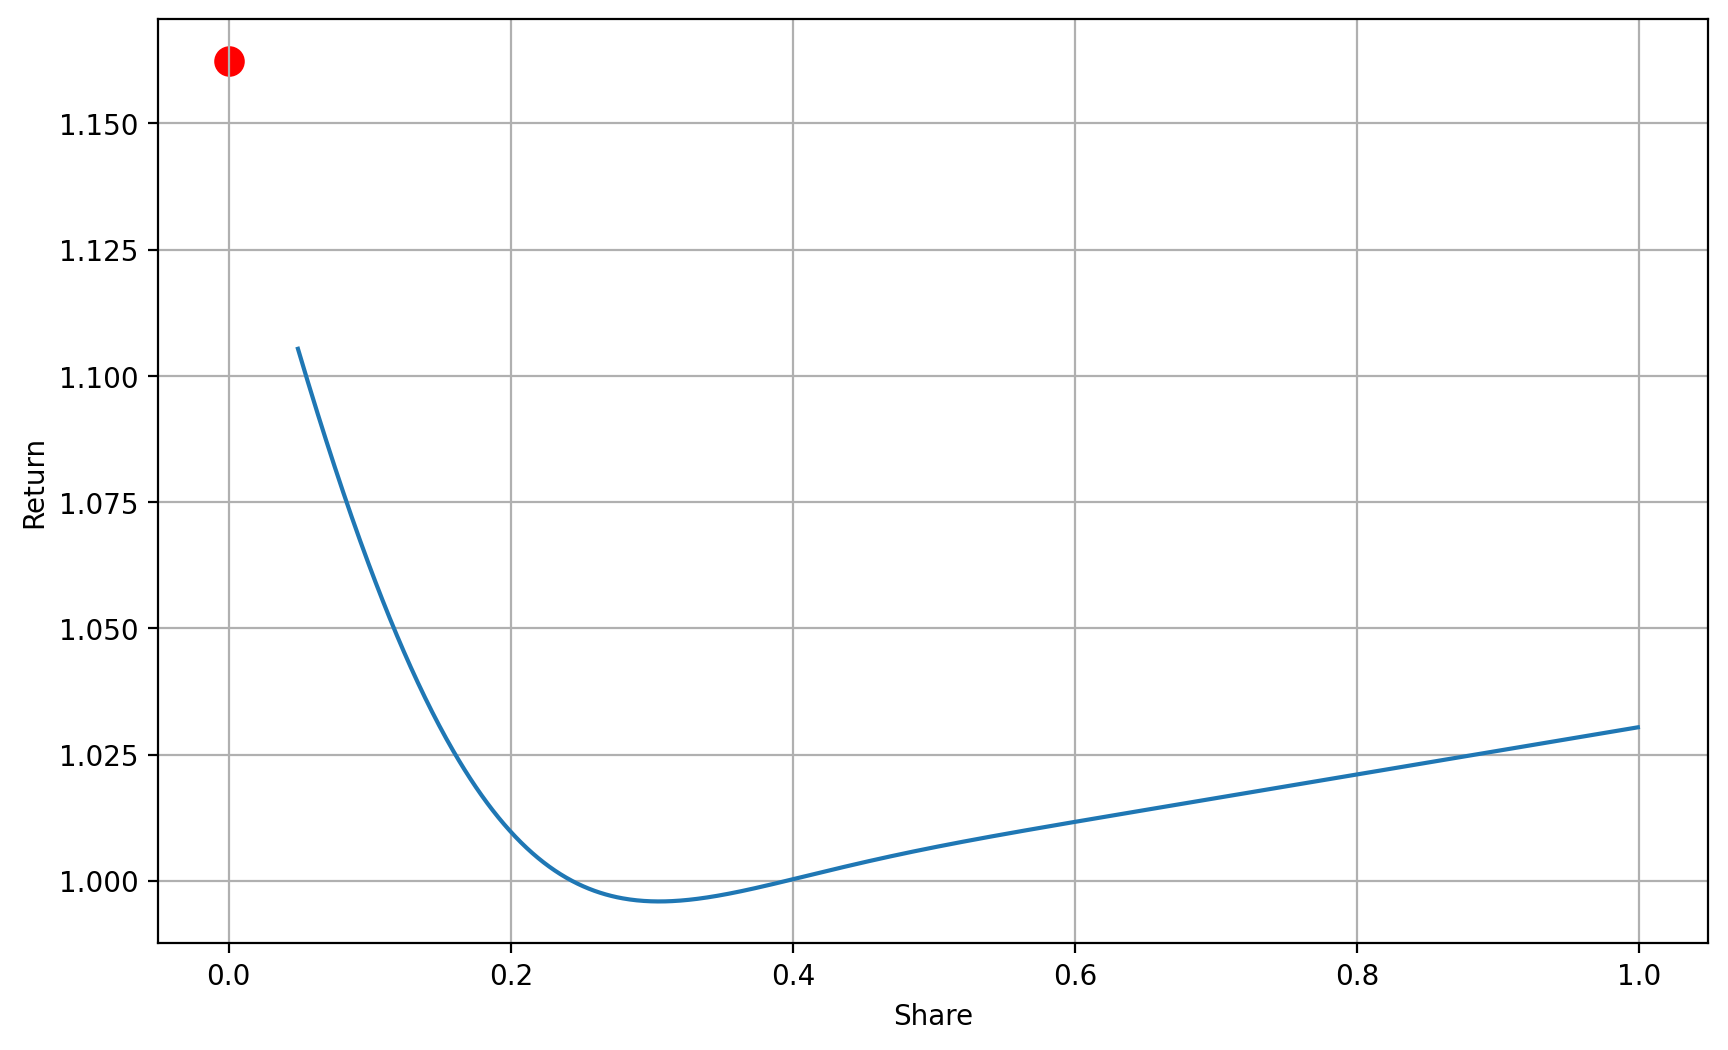

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], params['s'],params['r_cd'], params['r_be'], params['theta'], params['D'])

###Средний диапазон высокая волатильность

<ipython-input-124-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0


<ipython-input-124-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) -

Optimal LHP:  0


<ipython-input-124-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x)

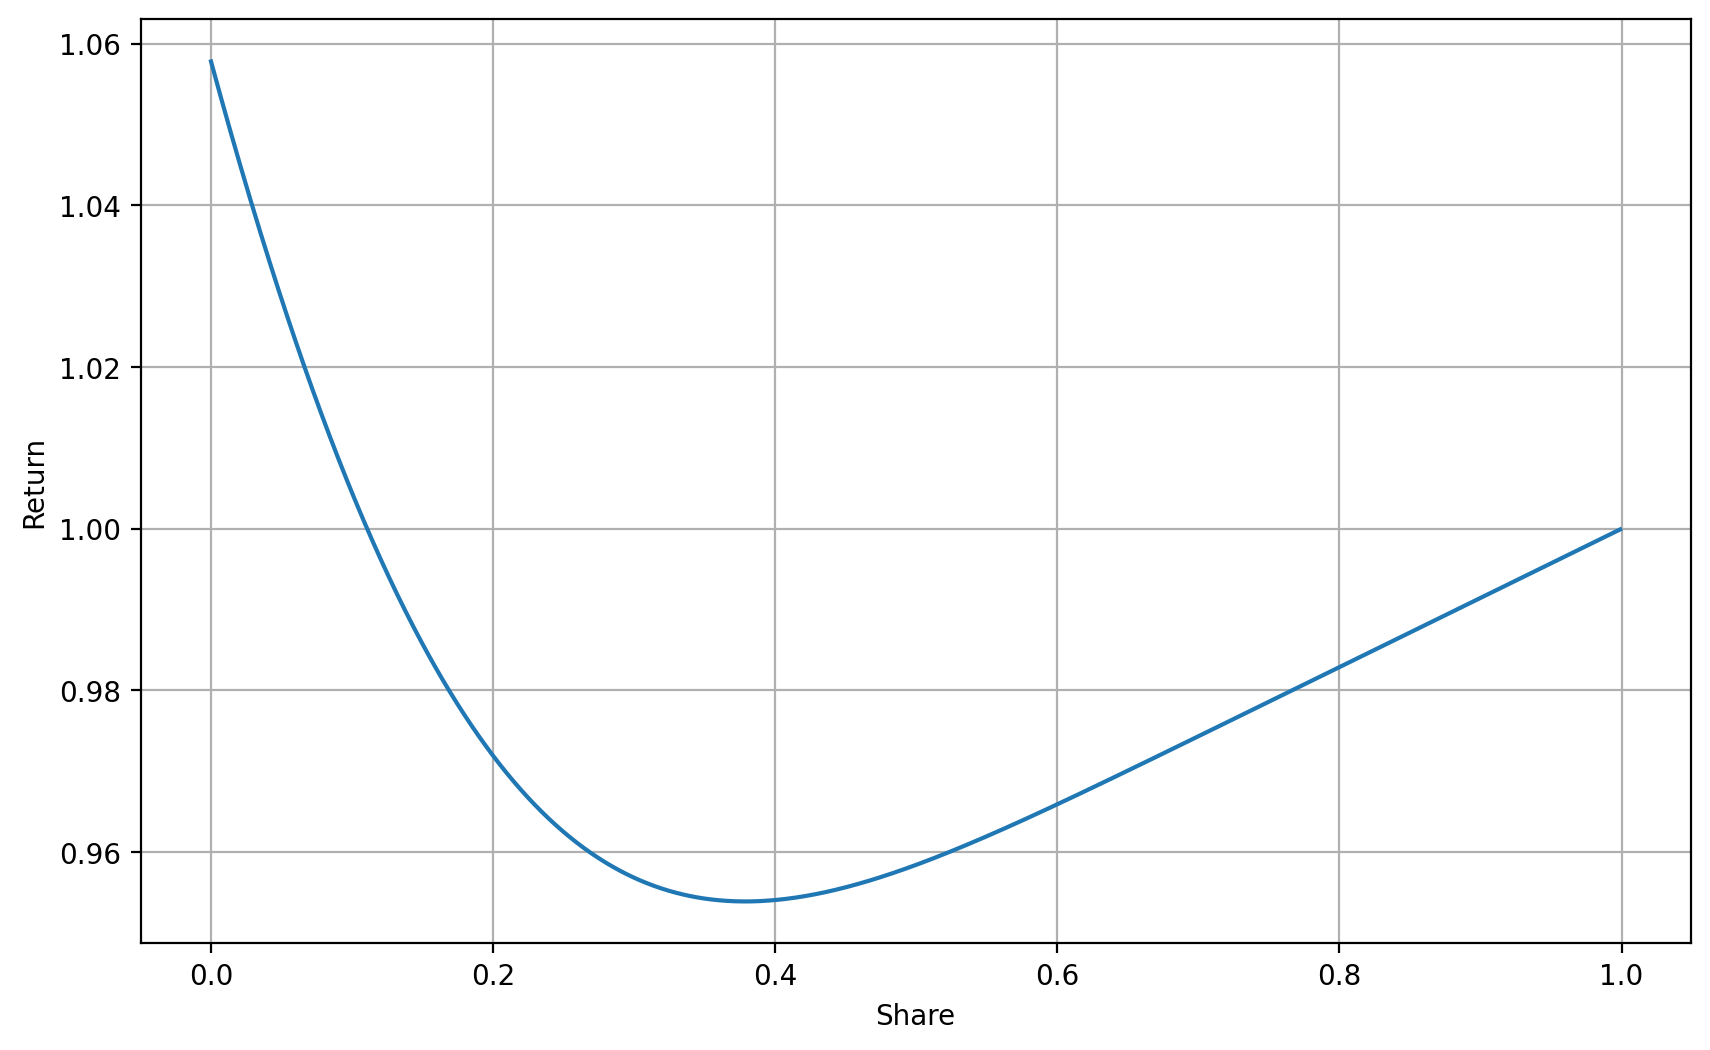

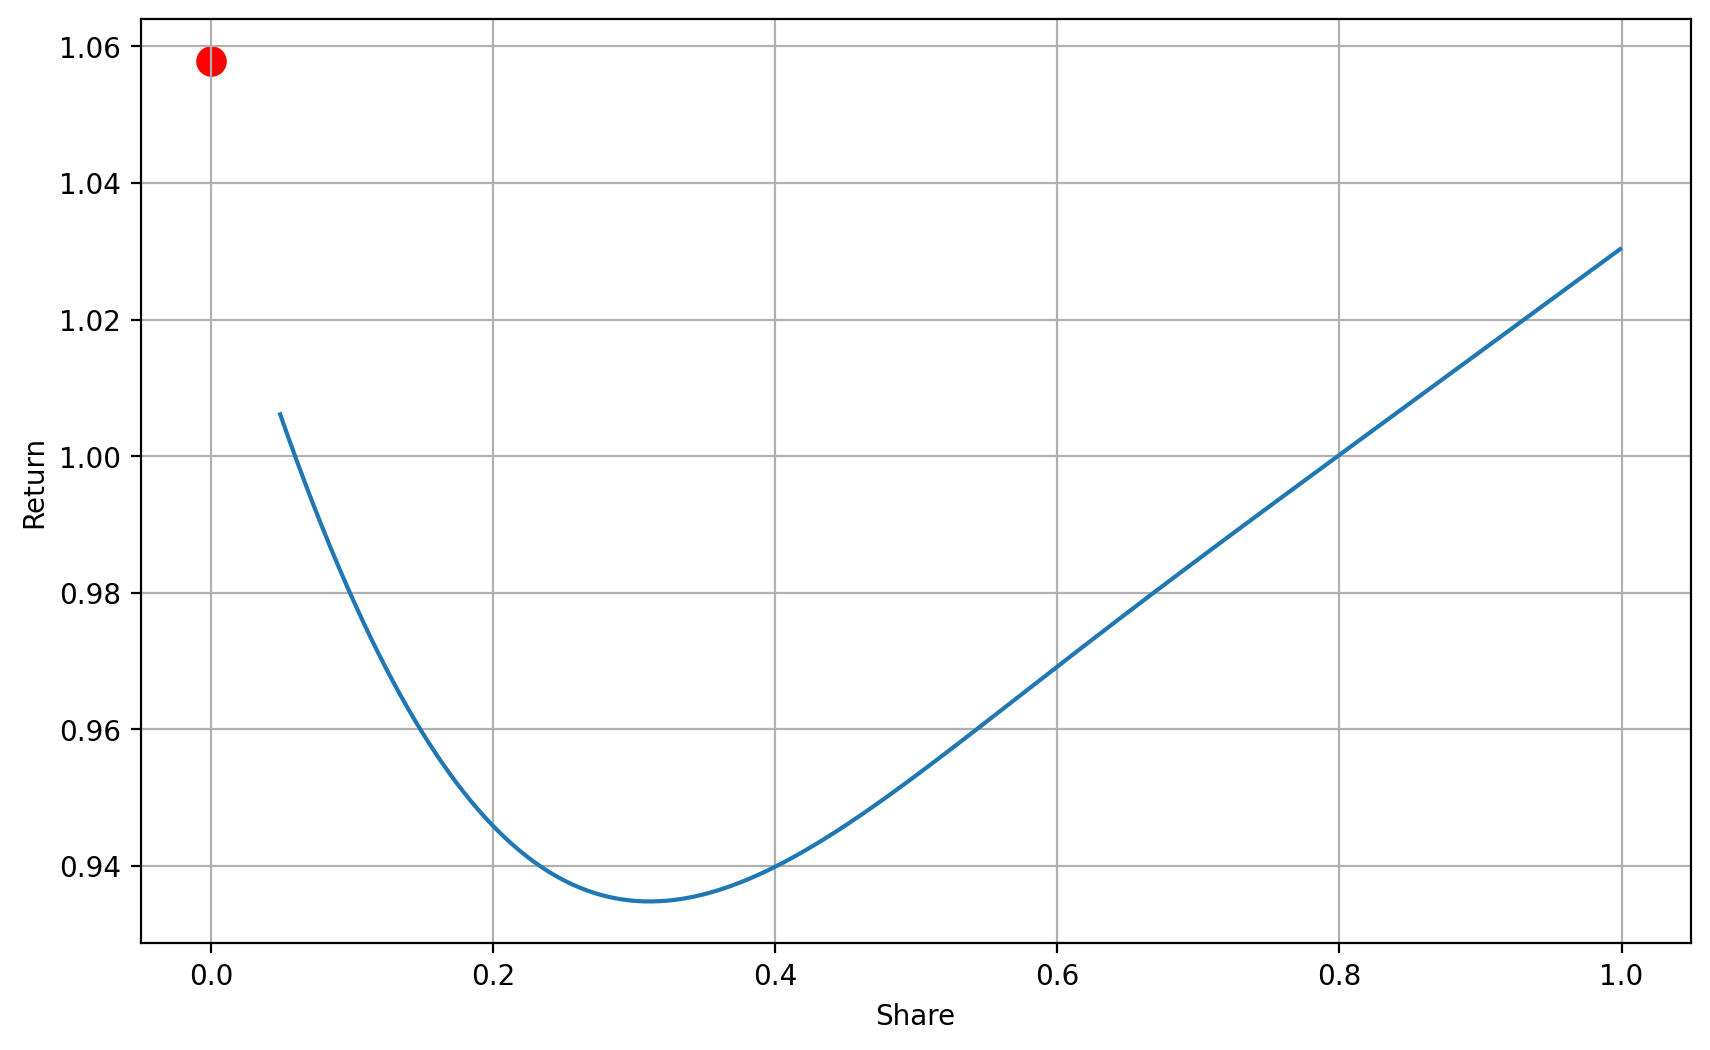

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.5, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2500, 3500, params['b'], params['l'], params['t'], params['u'], 0.5,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Широкий диапазон низкая волатильность

<ipython-input-124-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0


<ipython-input-124-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) -

Optimal LHP:  0


<ipython-input-124-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x)

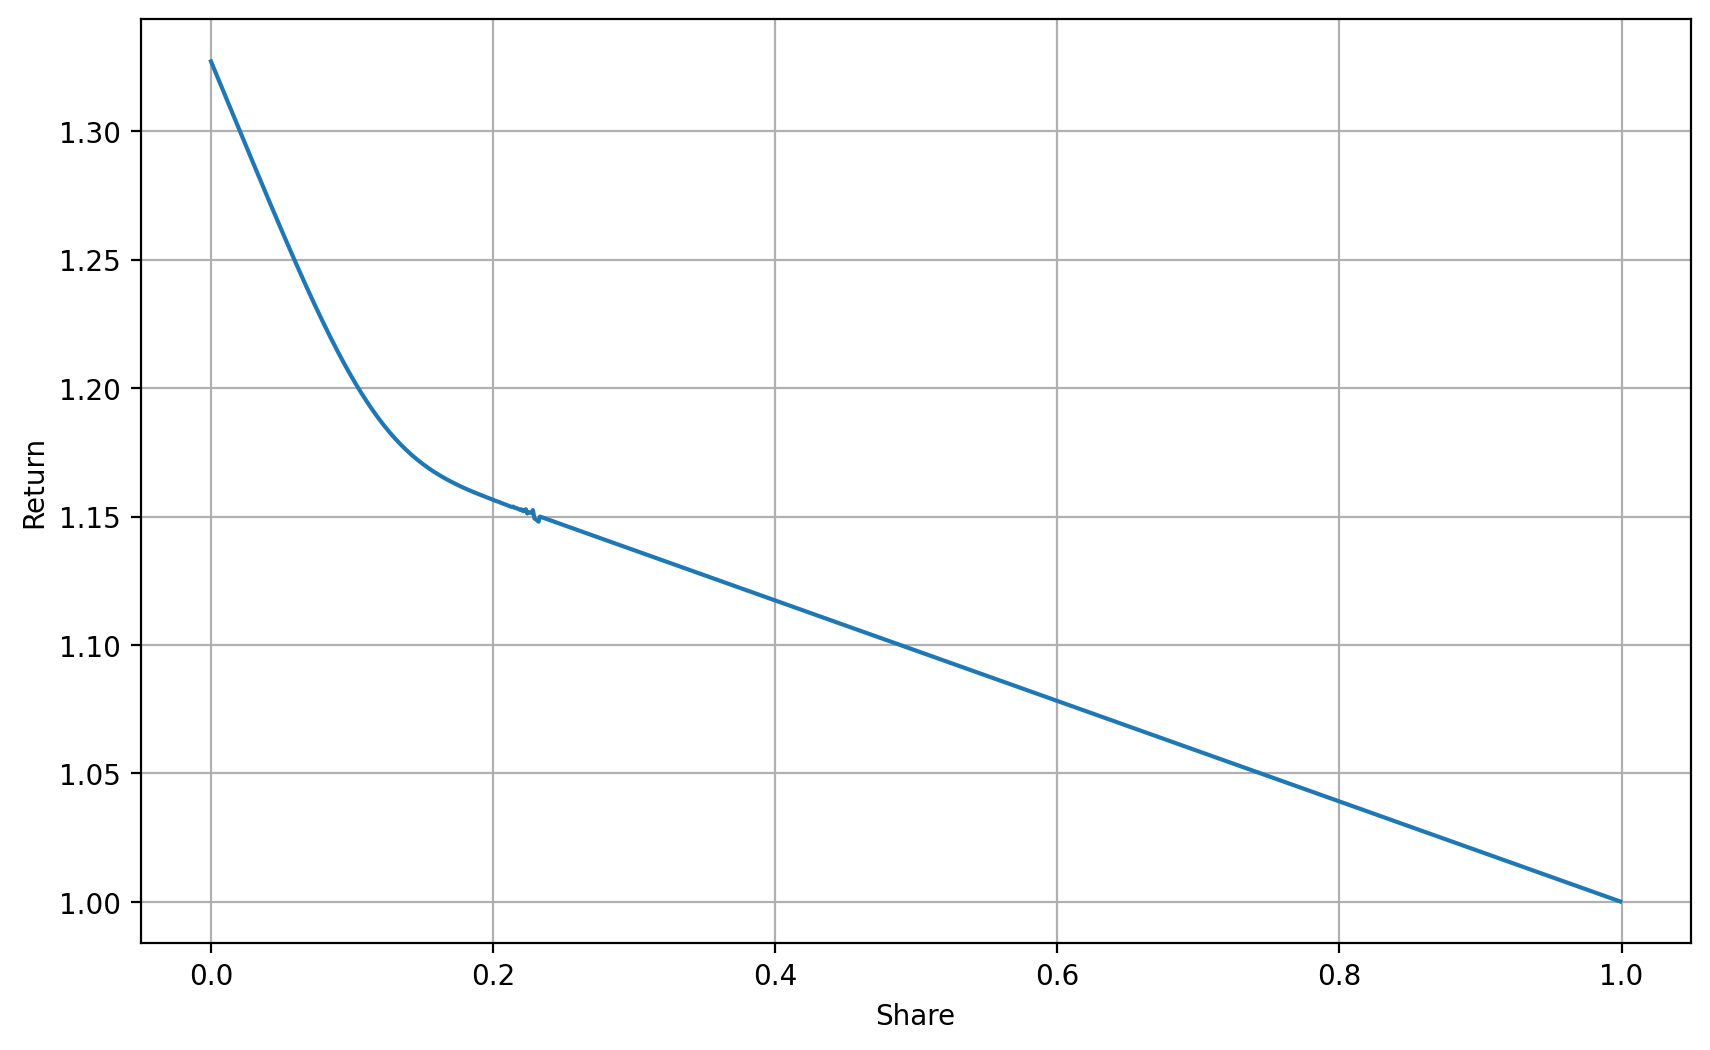

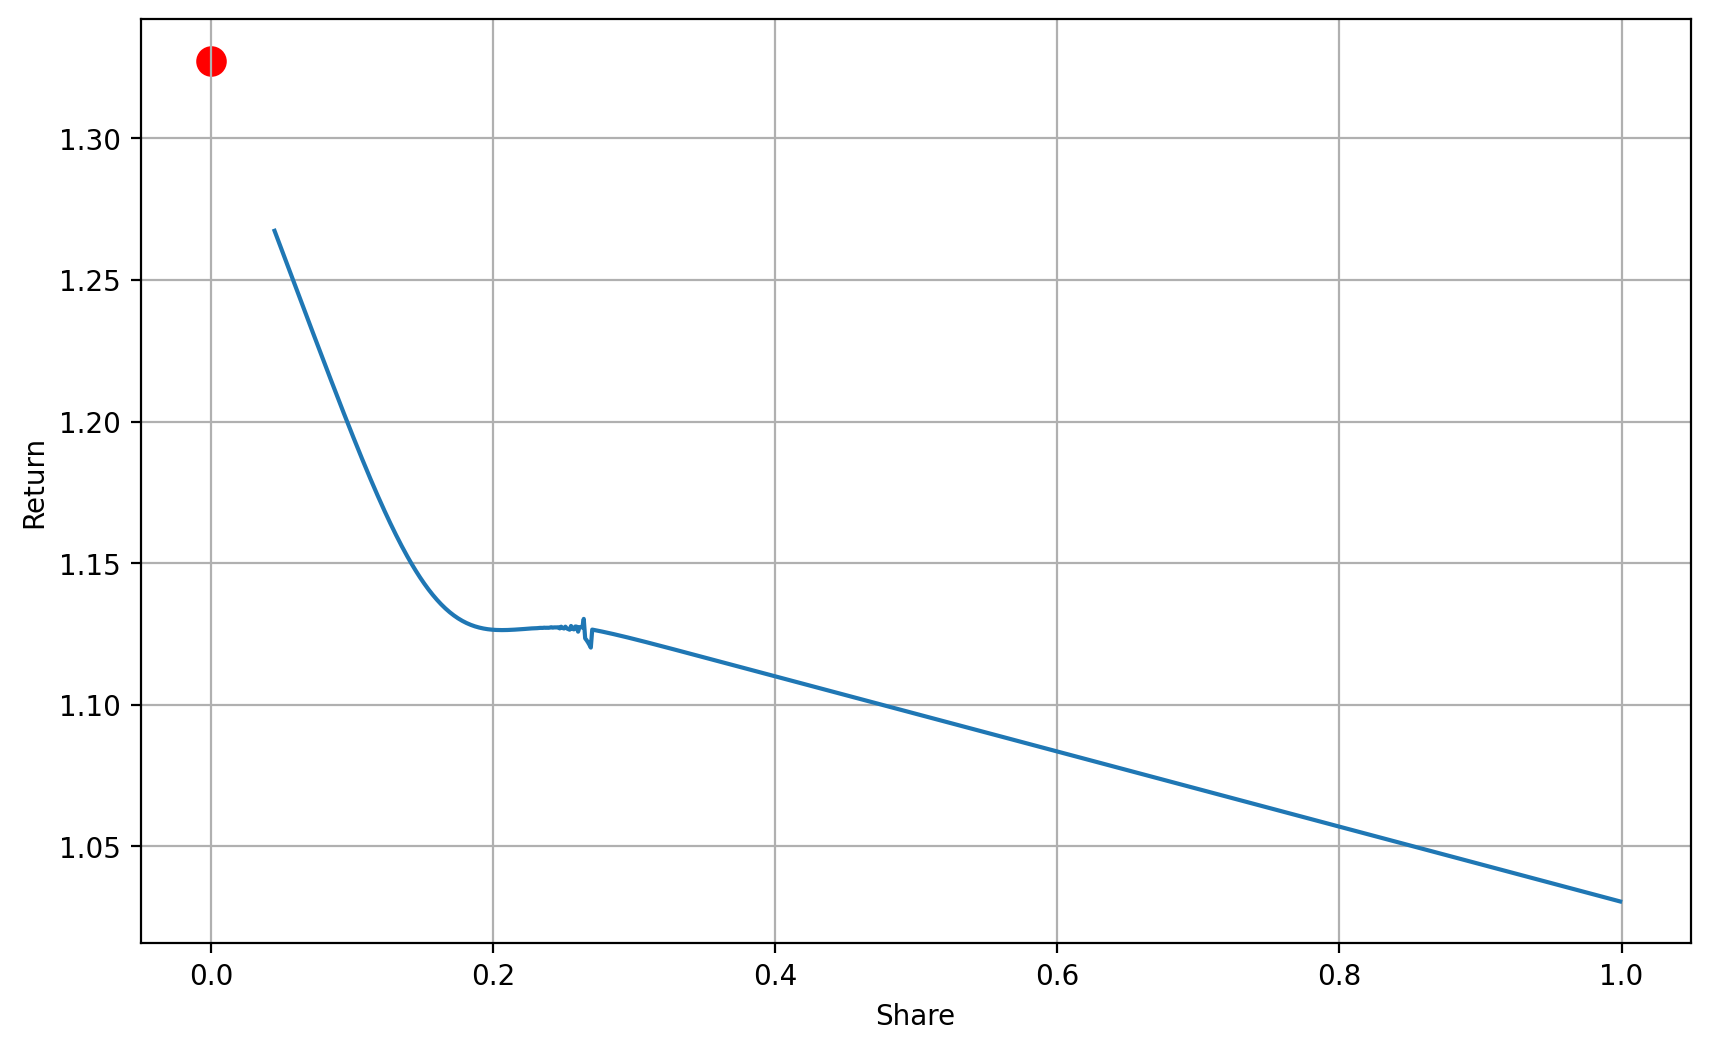

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.1, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.1,params['r_cd'], params['r_be'], params['theta'], params['D'])

###Широкий диапазон средняя волатильность

<ipython-input-124-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0


<ipython-input-124-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) -

Optimal LHP:  0


<ipython-input-124-2872108846>:520: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = np.exp(r_cd * t) * (D * x + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-(((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0)**(2 * (u / s**2 + (r_be - r_cd) / s**2 - 1 / 2)) * (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) + t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t))))) / 2 - (1 - erf((np.log((theta * (((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / ((1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + p_0)) / p_0) - t * (u - s**2 / 2 - r_cd + r_be)) / (np.sqrt(2) * s * np.sqrt(t)))) / 2 + 1) - (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * np.exp(t * (u + r_be)) * (1 - x)

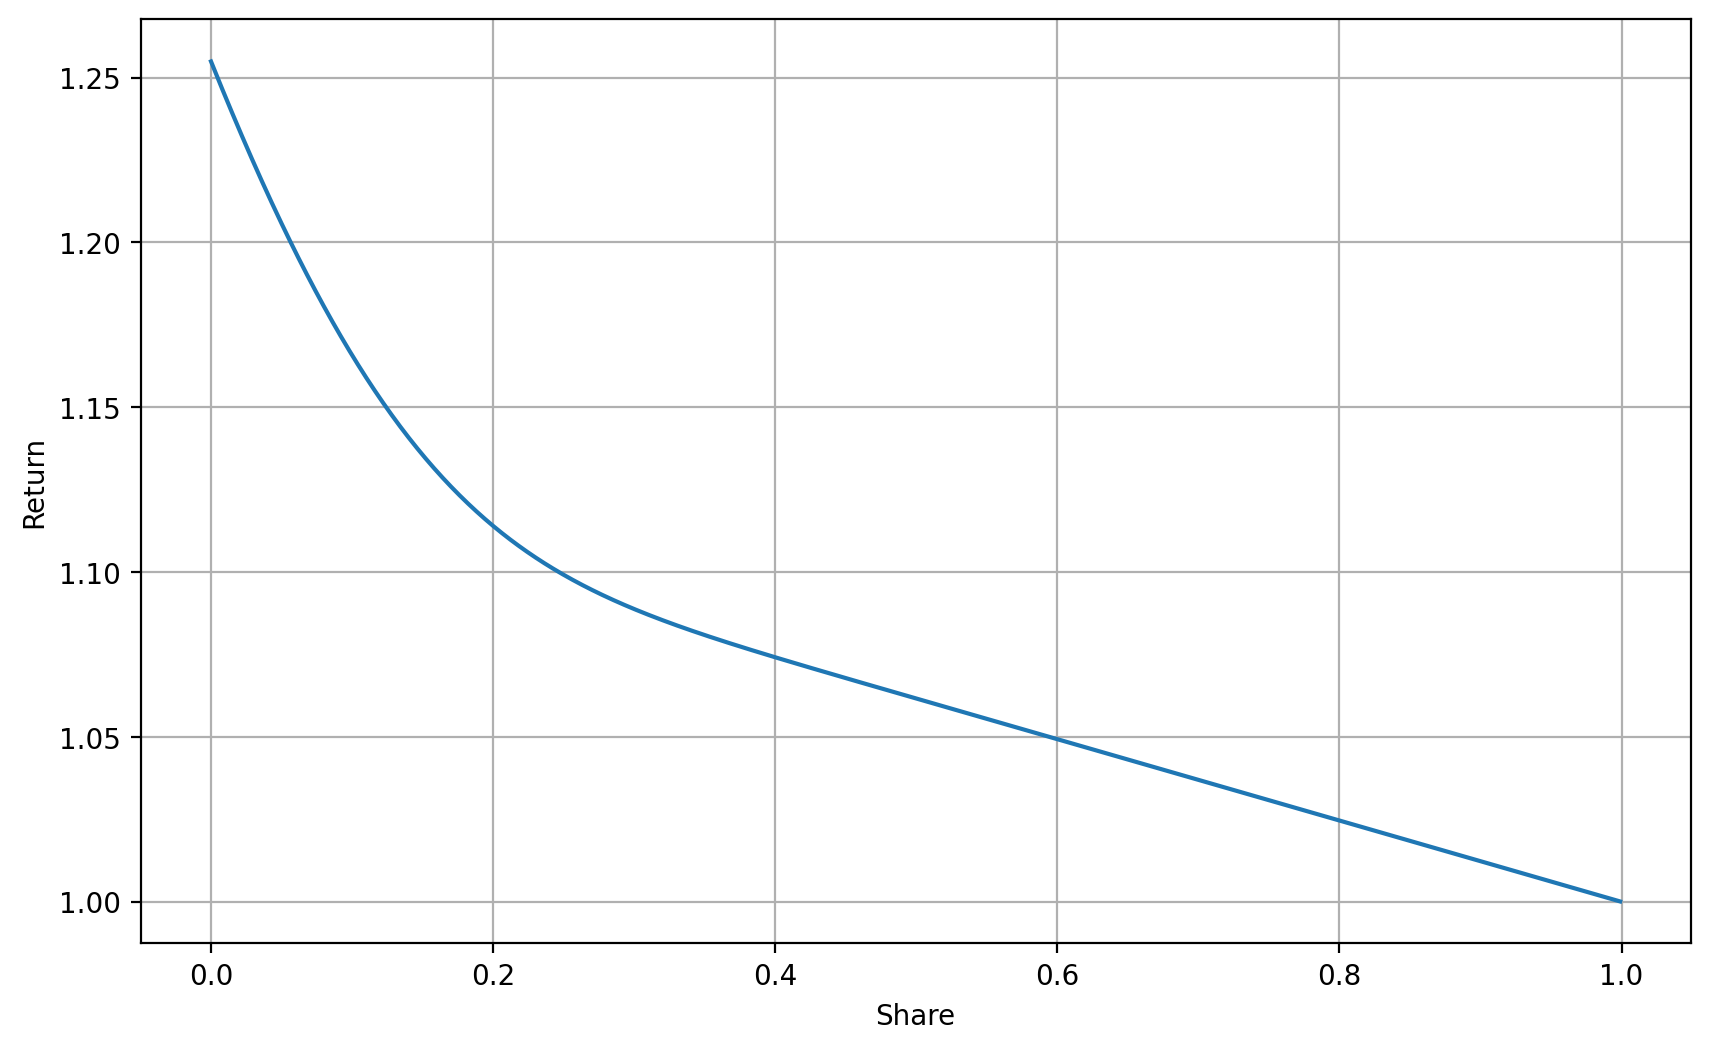

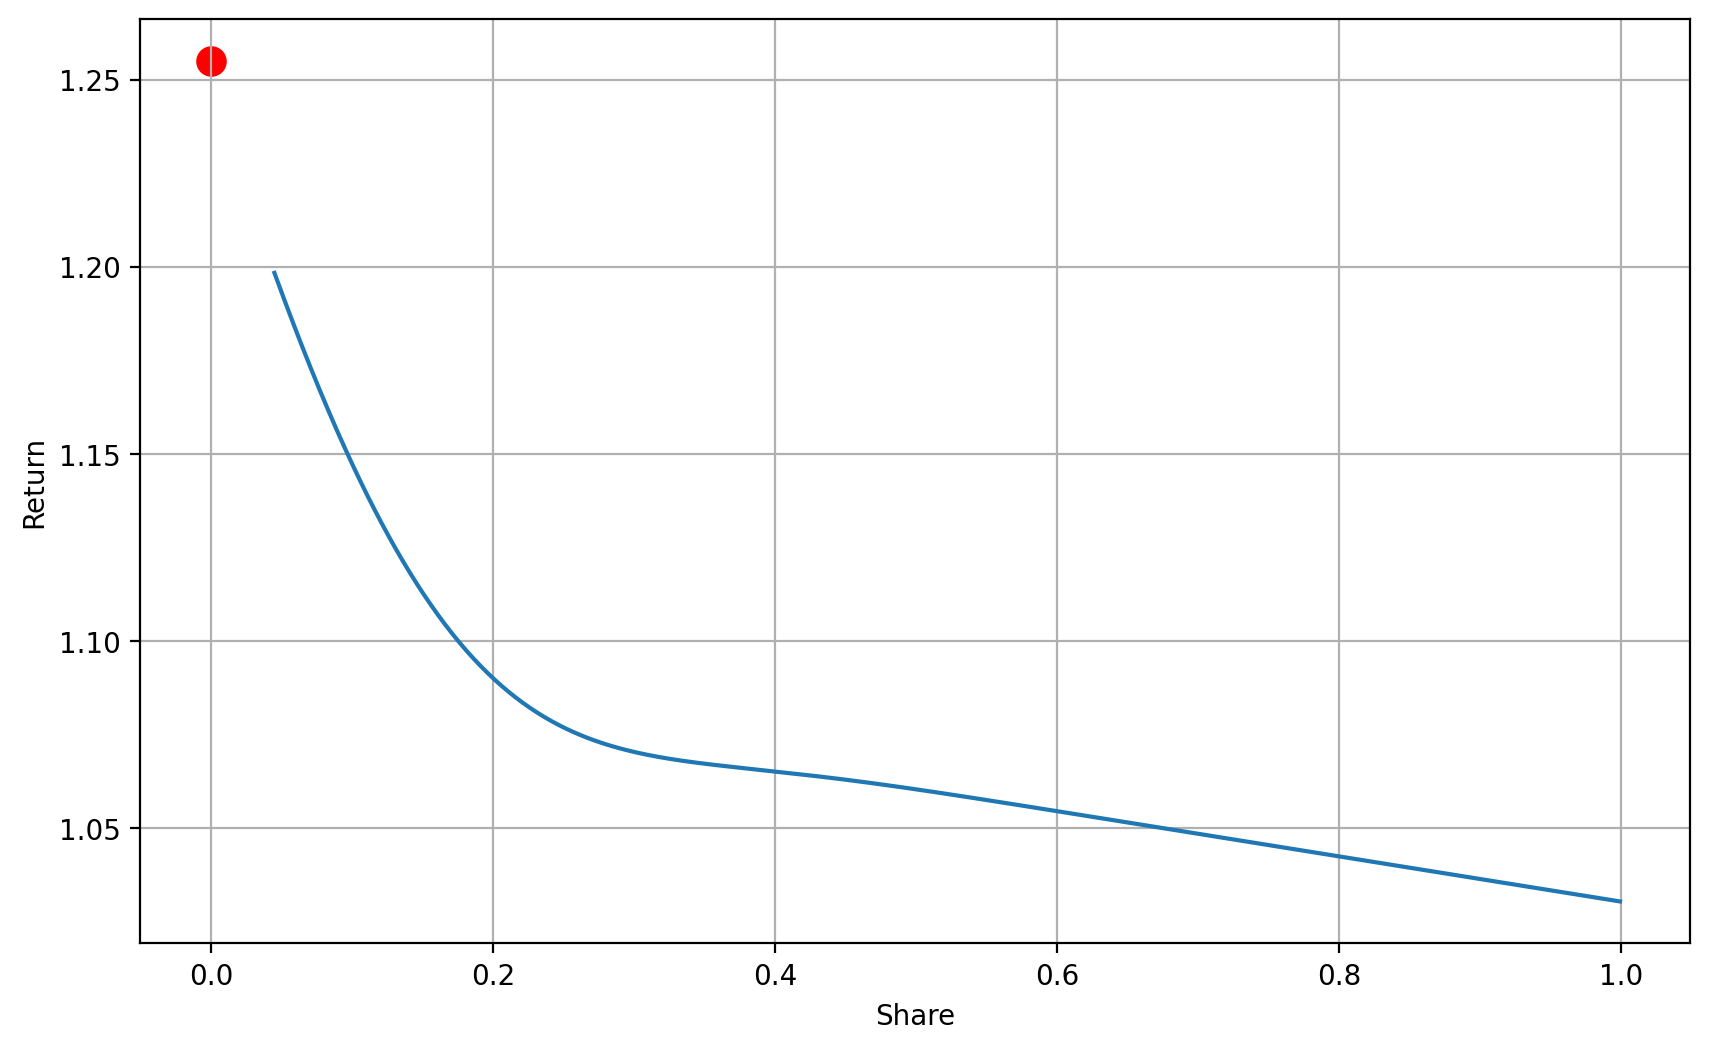

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], params['s'], params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], params['s'],params['r_cd'], params['r_be'], params['theta'], params['D'])

###Широкий диапазон высокая волатильность

<ipython-input-124-2872108846>:443: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V_F = np.trapz(int_expression, dx = 1 / self.n_steps)


Optimal MBP::  0


<ipython-input-124-2872108846>:446: RuntimeWarning: divide by zero encountered in scalar divide
  V_H = D * (x + (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) / (-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0))) * (-((((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1)**((2 * u) / s**2 - 1) * (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) + (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2)))) / 2 - (1 - erf(np.log(((-p_0 / np.sqrt(p_b) - np.sqrt(p_a) + 2 * np.sqrt(p_0)) * x) / (p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * (1 - x)) + 1) / (np.sqrt(2) * s * np.sqrt(t)) - (np.sqrt(t) * (u / s - s / 2)) / np.sqrt(2))) / 2 + 1) + (D * p_0 * (1 / np.sqrt(p_0) - 1 / np.sqrt(p_b)) * ((k * (-r + n - i)) / (k - i) - 1) * (1 - x) * (np.exp(t * u) - (np.exp(t * u) * ((((-p_0 / np.sqrt(p_b) -

Optimal LHP:  0


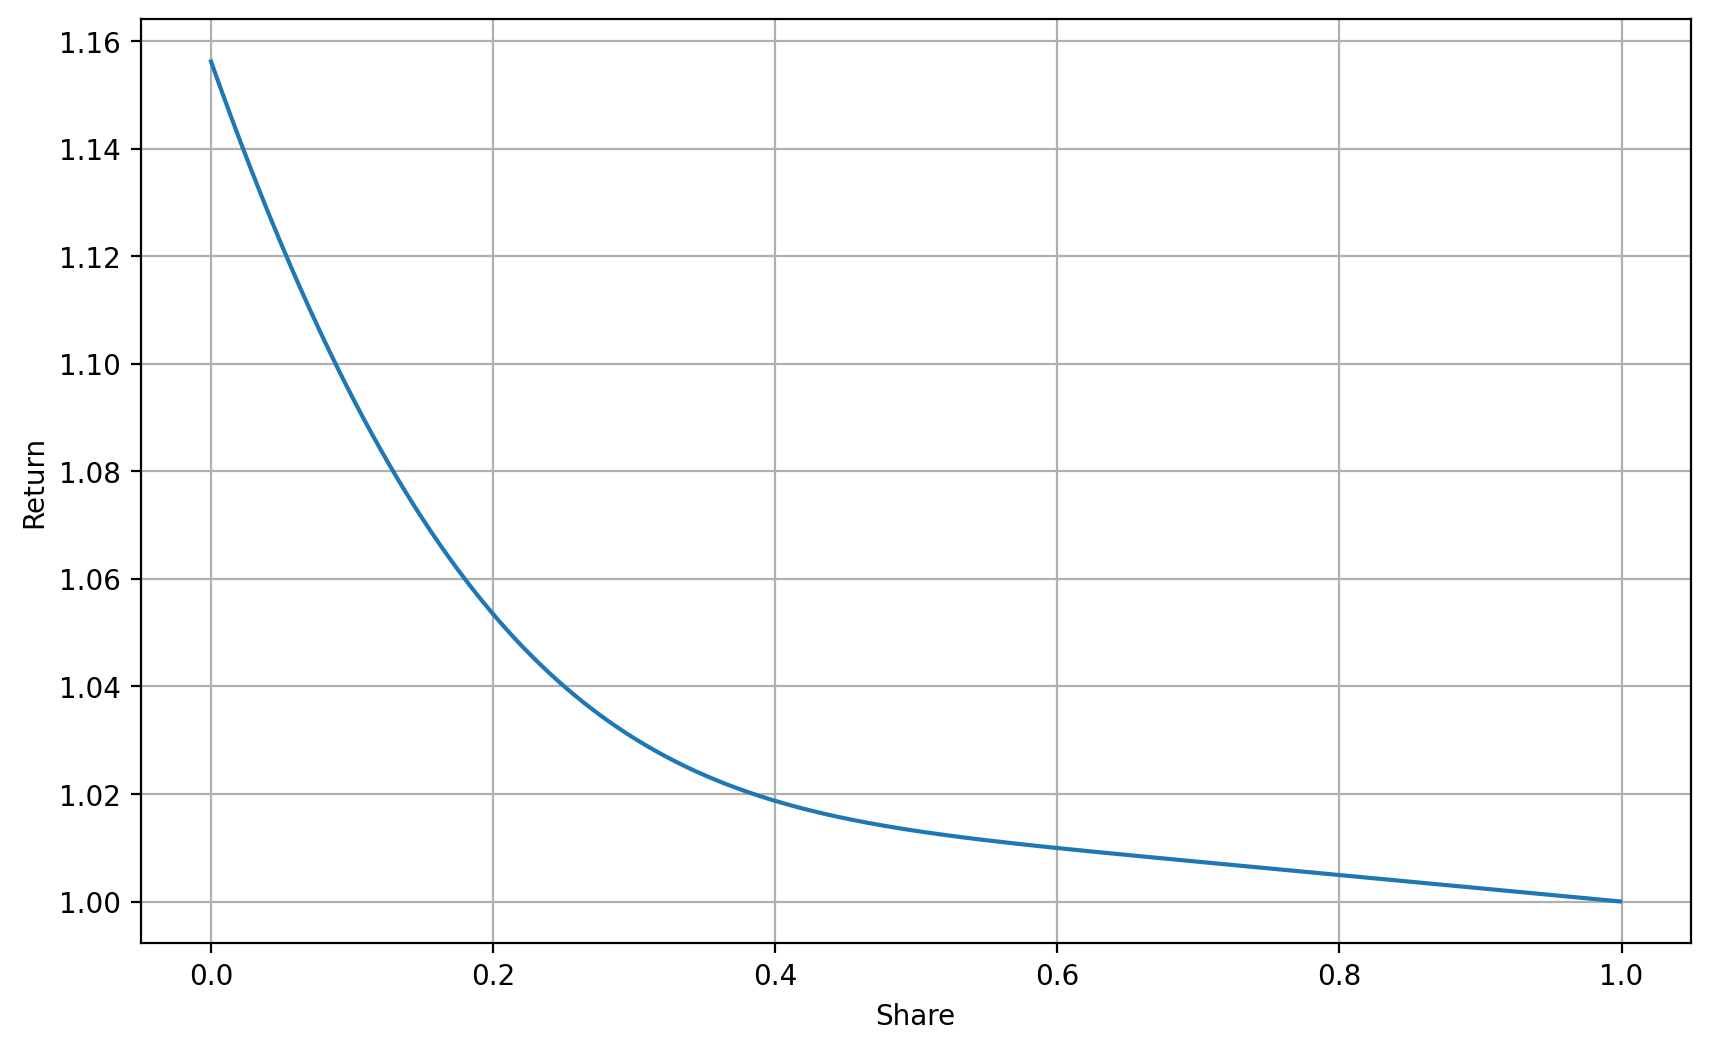

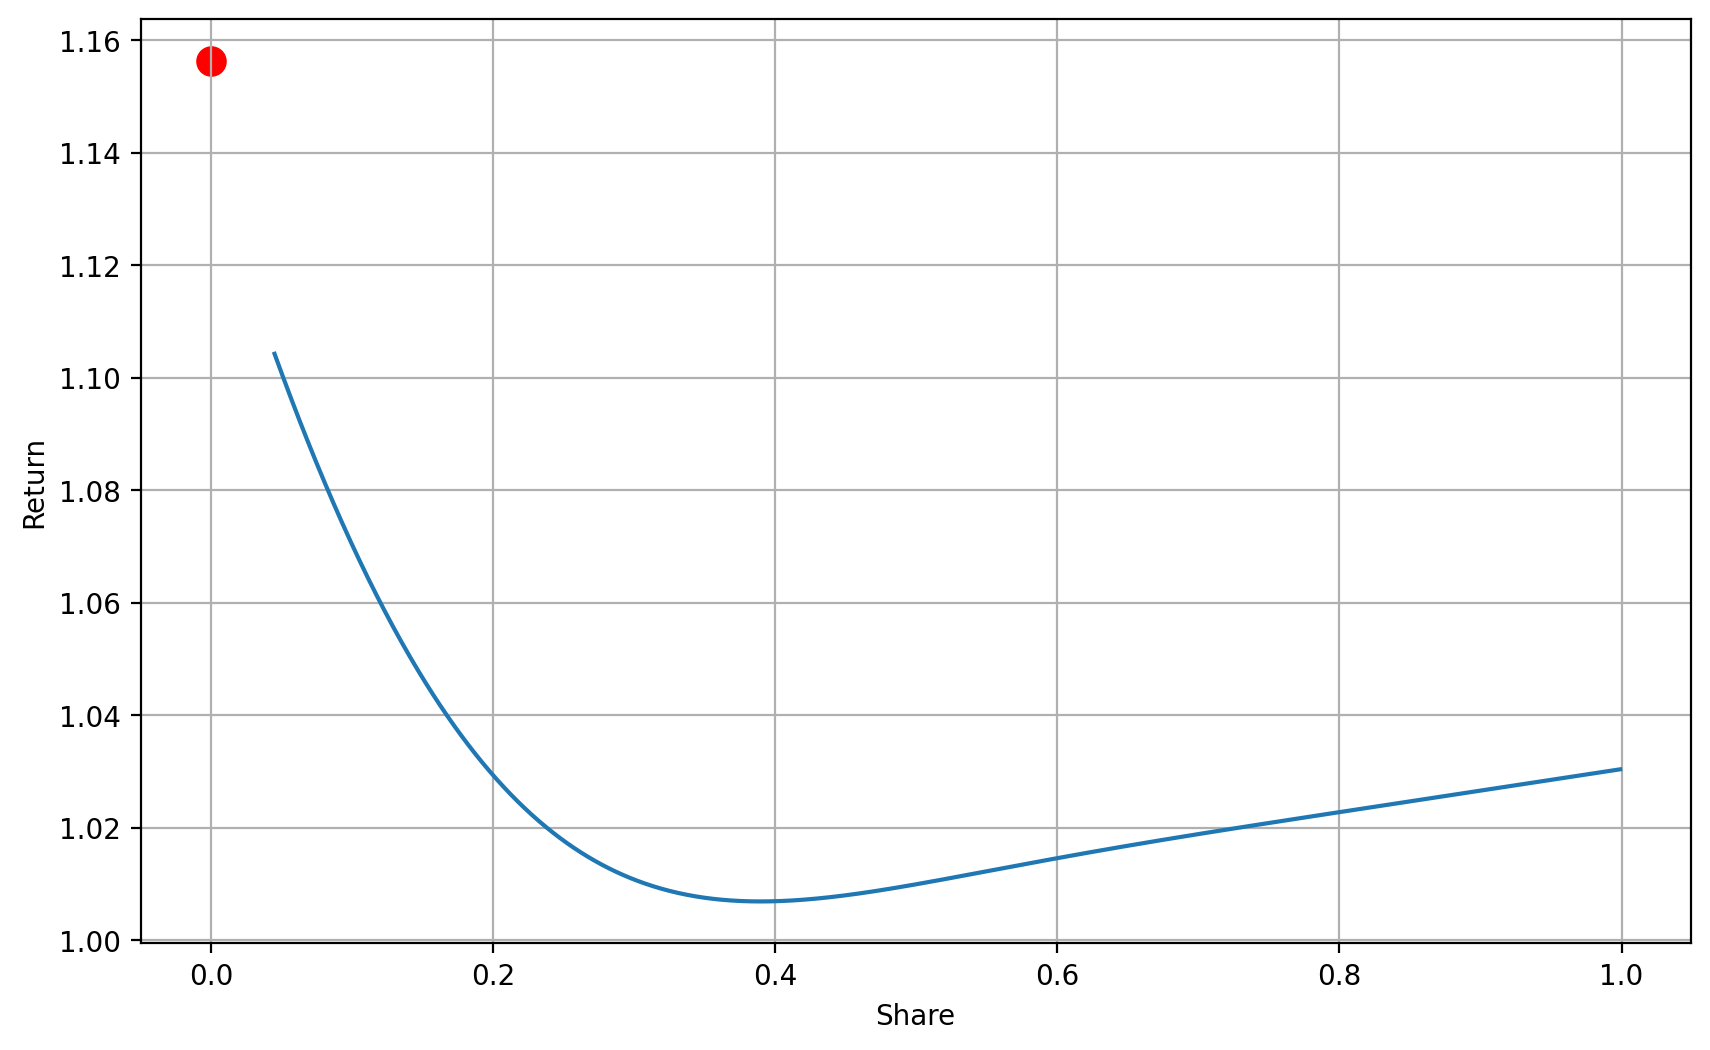

In [ ]:
lp.APY_MBP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.5, params['kappa'], params['iota'], params['r_a'], params['r_b'], params['D'])
lp.APY_LHP_dependency(params['p_0'], 2000, 4000, params['b'], params['l'], params['t'], params['u'], 0.5,params['r_cd'], params['r_be'], params['theta'], params['D'])

#Sensitivity of parameters

In [ ]:
def MBP_dependency(b, t, u, sigma, kappa, iota, r_a, r_b, l, D):
    n_points = 100
    param_grid = {
    'p_0': np.linspace(1000, 5000, n_points),
    'p_a': np.linspace(1000, 5000, n_points),
    'b': np.linspace(0.1, 0.3, n_points),
    't': np.linspace(0, 1.0, n_points),
    'u': np.linspace(-2, 2, n_points),
    's': np.linspace(0, 2, n_points),
    'kappa': np.linspace(0, 0.5, n_points),
    'iota': np.linspace(0, 0.5, n_points),
    'r_a': np.linspace(0, 1.0, n_points),
    'r_b': np.linspace(0, 1.0, n_points)
    }

    MBPs = np.zeros(n_points)
    #Beta
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (param_grid['param_b'][i], t, u, sigma, kappa, iota, r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_b'], MBPs)
    plt.grid()
    plt.xlabel('Beta')
    plt.ylabel('Margin balance percentage')

    #Time
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, param_grid['param_t'][i], u, sigma, kappa, iota, r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_t'], MBPs)
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Margin balance percentage')

    #Mu
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, param_grid['param_u'][i], sigma, kappa, iota, r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_u'], MBPs)
    plt.grid()
    plt.xlabel('Mu')
    plt.ylabel('Margin balance percentage')

    #Sigma
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, u, param_grid['param_s'][i], kappa, iota, r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_s'], MBPs)
    plt.grid()
    plt.xlabel('Sigma')
    plt.ylabel('Margin balance percentage')

    #Kappa
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, u, sigma, param_grid['param_kappa'][i], iota, r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_kappa'], MBPs)
    plt.grid()
    plt.xlabel('Kappa')
    plt.ylabel('Margin balance percentage')

    #Iota
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, u, sigma, kappa, param_grid['param_iota'][i], r_a, r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_iota'], MBPs)
    plt.grid()
    plt.xlabel('Iota')
    plt.ylabel('Margin balance percentage')

    #Risk-less asset
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, u, sigma, kappa, iota, param_grid['param_r_a'][i], r_b, l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_r_a'], MBPs)
    plt.grid()
    plt.xlabel('Risk-less asset rate')
    plt.ylabel('Margin balance percentage')

    #Risk asset
    for i in range (0, n_points):
      roots = fsolve(mean_first_derivative, 0, args = (b, t, u, sigma, kappa, iota, r_a, param_grid['param_r_b'][i], l, D))
      MBPs[i] = roots[0]

    plt.figure(figsize = (10, 6))
    plt.plot(param_grid['param_r_b'], MBPs)
    plt.grid()
    plt.xlabel('Risk asset rate')
    plt.ylabel('Margin balance percentage')
